# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir='summer2winter-yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

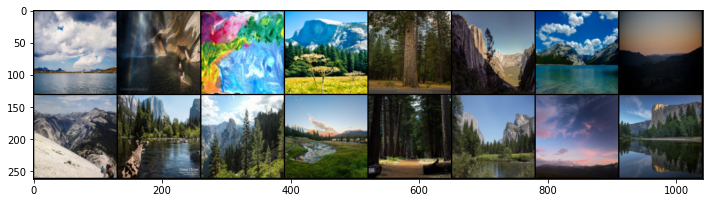

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

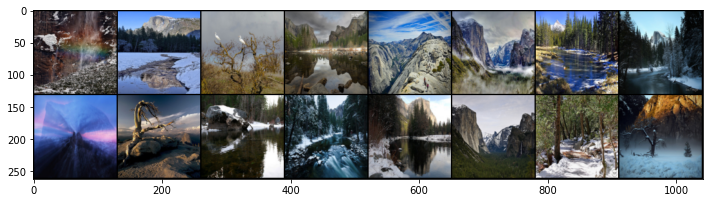

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0157)
Max:  tensor(0.9020)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9686)
Scaled max:  tensor(0.8039)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv1 = conv(in_channels=3,          out_channels=conv_dim,   kernel_size=4, batch_norm=False)
        self.conv2 = conv(in_channels=conv_dim,   out_channels=conv_dim*2, kernel_size=4)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4)
        self.conv4 = conv(in_channels=conv_dim*4, out_channels=conv_dim*8, kernel_size=4)
        self.conv5 = conv(in_channels=conv_dim*8, out_channels=1, kernel_size=4, stride=1, batch_norm=False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, batch_norm=True)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        
        return x + out
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.encoder = nn.Sequential(
            conv(in_channels=3, out_channels=conv_dim, kernel_size=4),
            nn.ReLU(),
            conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4),
            nn.ReLU(),
            conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4),
            nn.ReLU()            
        )

        # 2. Define the resnet part of the generator
        self.resnet = nn.Sequential(
            *[ResidualBlock(conv_dim*4) for i in range(n_res_blocks)]
        )
        
        # 3. Define the decoder part of the generator
        self.decoder = nn.Sequential(
            deconv(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4),
            nn.ReLU(),
            deconv(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4),
            nn.ReLU(),
            deconv(in_channels=conv_dim, out_channels=3, kernel_size=4, batch_norm=False),
            nn.Tanh()
        )


    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        x = self.encoder(x)
        x = self.resnet(x)
        x = self.decoder(x)
        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU()
  )
  (resnet): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Batch

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean((D_out-0)**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    
    # return weighted loss
    return lambda_weight * loss   


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [19]:
# import save code
from helpers import save_samples, checkpoint

In [20]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        d_x_loss_real = real_mse_loss(D_X(images_X))
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        images_X_fake = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        d_x_loss_fake = fake_mse_loss(D_X(images_X_fake))
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = d_x_loss_real + d_x_loss_fake

        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        
        d_y_loss_real = real_mse_loss(D_Y(images_Y))

        images_Y_fake = G_XtoY(images_X)
        
        d_y_loss_fake = fake_mse_loss(D_Y(images_Y_fake))
        
        d_y_loss = d_y_loss_real + d_y_loss_fake

        d_y_loss.backward()
        d_y_optimizer.step()
        

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        images_X_fake = G_YtoX(images_Y)
        
        # 2. Compute the generator loss based on domain X
        g_loss_fake_x = real_mse_loss(D_X(images_X_fake))  # We want them to become real
        
        # 3. Create a reconstructed y
        images_Y_reconstructed = G_XtoY(images_X_fake)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        cycle_loss_x = cycle_consistency_loss(images_Y, images_Y_reconstructed, lambda_weight=10.0)

        ##    Second: generate fake Y images and reconstructed X images    ##
        images_Y_fake = G_XtoY(images_X)
        g_loss_fake_y = real_mse_loss(D_Y(images_Y_fake))  # We want them to become real
        images_X_reconstructed = G_YtoX(images_Y_fake)
        cycle_loss_y = cycle_consistency_loss(images_X, images_X_reconstructed, lambda_weight=10.0)
        
        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_loss_fake_x + g_loss_fake_y + cycle_loss_x + cycle_loss_y

        g_total_loss.backward()
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
        checkpoint_every=1000
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [21]:
n_epochs = 20000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/20000] | d_X_loss: 0.2990 | d_Y_loss: 0.4329 | g_total_loss: 9.3067
Epoch [   20/20000] | d_X_loss: 0.3642 | d_Y_loss: 0.5018 | g_total_loss: 9.0848
Epoch [   30/20000] | d_X_loss: 0.3263 | d_Y_loss: 0.3025 | g_total_loss: 8.0991
Epoch [   40/20000] | d_X_loss: 0.5101 | d_Y_loss: 0.5328 | g_total_loss: 6.7469
Epoch [   50/20000] | d_X_loss: 0.3941 | d_Y_loss: 0.4164 | g_total_loss: 6.2000
Epoch [   60/20000] | d_X_loss: 0.4096 | d_Y_loss: 0.5158 | g_total_loss: 6.6450
Epoch [   70/20000] | d_X_loss: 0.2688 | d_Y_loss: 0.4558 | g_total_loss: 5.0177
Epoch [   80/20000] | d_X_loss: 0.3594 | d_Y_loss: 0.5680 | g_total_loss: 5.3874
Epoch [   90/20000] | d_X_loss: 0.3718 | d_Y_loss: 0.2622 | g_total_loss: 7.4255


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/20000] | d_X_loss: 0.2267 | d_Y_loss: 0.7540 | g_total_loss: 4.6358


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/20000] | d_X_loss: 0.3425 | d_Y_loss: 0.5238 | g_total_loss: 5.5445
Epoch [  120/20000] | d_X_loss: 0.3043 | d_Y_loss: 0.3382 | g_total_loss: 6.1569
Epoch [  130/20000] | d_X_loss: 0.3479 | d_Y_loss: 0.3715 | g_total_loss: 4.6097
Epoch [  140/20000] | d_X_loss: 0.2763 | d_Y_loss: 0.3840 | g_total_loss: 5.1172
Epoch [  150/20000] | d_X_loss: 0.3984 | d_Y_loss: 0.5122 | g_total_loss: 5.7878
Epoch [  160/20000] | d_X_loss: 0.3144 | d_Y_loss: 0.3297 | g_total_loss: 5.3128
Epoch [  170/20000] | d_X_loss: 0.2318 | d_Y_loss: 0.4052 | g_total_loss: 5.2223
Epoch [  180/20000] | d_X_loss: 0.3074 | d_Y_loss: 0.4273 | g_total_loss: 4.7187
Epoch [  190/20000] | d_X_loss: 0.3440 | d_Y_loss: 0.4406 | g_total_loss: 4.5468


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/20000] | d_X_loss: 0.2772 | d_Y_loss: 0.2843 | g_total_loss: 4.9272


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/20000] | d_X_loss: 0.5299 | d_Y_loss: 0.3680 | g_total_loss: 4.4621
Epoch [  220/20000] | d_X_loss: 0.3236 | d_Y_loss: 0.4787 | g_total_loss: 4.5039
Epoch [  230/20000] | d_X_loss: 0.3216 | d_Y_loss: 0.5546 | g_total_loss: 4.7692
Epoch [  240/20000] | d_X_loss: 0.4551 | d_Y_loss: 0.4676 | g_total_loss: 4.0627
Epoch [  250/20000] | d_X_loss: 0.3556 | d_Y_loss: 0.2732 | g_total_loss: 4.8427
Epoch [  260/20000] | d_X_loss: 0.3636 | d_Y_loss: 0.4678 | g_total_loss: 3.8288
Epoch [  270/20000] | d_X_loss: 0.4073 | d_Y_loss: 0.3744 | g_total_loss: 4.3196
Epoch [  280/20000] | d_X_loss: 0.3381 | d_Y_loss: 0.7032 | g_total_loss: 3.8216
Epoch [  290/20000] | d_X_loss: 0.4561 | d_Y_loss: 0.3403 | g_total_loss: 4.6648


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/20000] | d_X_loss: 0.3585 | d_Y_loss: 0.5769 | g_total_loss: 5.7042


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/20000] | d_X_loss: 0.5355 | d_Y_loss: 0.2667 | g_total_loss: 4.0488
Epoch [  320/20000] | d_X_loss: 0.3397 | d_Y_loss: 0.4772 | g_total_loss: 4.8221
Epoch [  330/20000] | d_X_loss: 0.2945 | d_Y_loss: 0.4074 | g_total_loss: 4.6458
Epoch [  340/20000] | d_X_loss: 0.2973 | d_Y_loss: 0.4703 | g_total_loss: 4.5581
Epoch [  350/20000] | d_X_loss: 0.4302 | d_Y_loss: 0.2433 | g_total_loss: 5.0726
Epoch [  360/20000] | d_X_loss: 0.3317 | d_Y_loss: 0.5548 | g_total_loss: 5.0962
Epoch [  370/20000] | d_X_loss: 0.3422 | d_Y_loss: 0.4109 | g_total_loss: 3.7129
Epoch [  380/20000] | d_X_loss: 0.5216 | d_Y_loss: 0.3294 | g_total_loss: 5.3608
Epoch [  390/20000] | d_X_loss: 0.3078 | d_Y_loss: 0.2584 | g_total_loss: 4.1033


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/20000] | d_X_loss: 0.3418 | d_Y_loss: 0.3495 | g_total_loss: 4.7462


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/20000] | d_X_loss: 0.4364 | d_Y_loss: 0.6068 | g_total_loss: 4.0286
Epoch [  420/20000] | d_X_loss: 0.6390 | d_Y_loss: 0.4658 | g_total_loss: 5.6225
Epoch [  430/20000] | d_X_loss: 0.3238 | d_Y_loss: 0.4432 | g_total_loss: 5.1941
Epoch [  440/20000] | d_X_loss: 0.3393 | d_Y_loss: 0.3718 | g_total_loss: 4.7775
Epoch [  450/20000] | d_X_loss: 0.4177 | d_Y_loss: 0.6862 | g_total_loss: 4.9665
Epoch [  460/20000] | d_X_loss: 0.4233 | d_Y_loss: 0.5266 | g_total_loss: 4.3904
Epoch [  470/20000] | d_X_loss: 0.3487 | d_Y_loss: 0.4799 | g_total_loss: 4.3147
Epoch [  480/20000] | d_X_loss: 0.2650 | d_Y_loss: 0.3027 | g_total_loss: 3.9885
Epoch [  490/20000] | d_X_loss: 0.5511 | d_Y_loss: 0.4085 | g_total_loss: 4.3148


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/20000] | d_X_loss: 0.3733 | d_Y_loss: 0.3527 | g_total_loss: 4.0580


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/20000] | d_X_loss: 0.3635 | d_Y_loss: 0.3684 | g_total_loss: 4.7562
Epoch [  520/20000] | d_X_loss: 0.3526 | d_Y_loss: 0.4247 | g_total_loss: 4.5097
Epoch [  530/20000] | d_X_loss: 0.3997 | d_Y_loss: 0.3815 | g_total_loss: 4.7213
Epoch [  540/20000] | d_X_loss: 0.3899 | d_Y_loss: 0.4593 | g_total_loss: 4.8070
Epoch [  550/20000] | d_X_loss: 0.3687 | d_Y_loss: 0.3810 | g_total_loss: 3.7164
Epoch [  560/20000] | d_X_loss: 0.3953 | d_Y_loss: 0.3504 | g_total_loss: 4.2838
Epoch [  570/20000] | d_X_loss: 0.3834 | d_Y_loss: 0.3251 | g_total_loss: 3.9779
Epoch [  580/20000] | d_X_loss: 0.5327 | d_Y_loss: 0.3014 | g_total_loss: 4.6143
Epoch [  590/20000] | d_X_loss: 0.5559 | d_Y_loss: 0.2885 | g_total_loss: 3.7001


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/20000] | d_X_loss: 0.3872 | d_Y_loss: 0.3356 | g_total_loss: 4.6020


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/20000] | d_X_loss: 0.3575 | d_Y_loss: 0.2285 | g_total_loss: 5.1520
Epoch [  620/20000] | d_X_loss: 0.3173 | d_Y_loss: 0.3683 | g_total_loss: 3.7001
Epoch [  630/20000] | d_X_loss: 0.3481 | d_Y_loss: 0.4678 | g_total_loss: 3.7502
Epoch [  640/20000] | d_X_loss: 0.8862 | d_Y_loss: 0.4165 | g_total_loss: 3.6282
Epoch [  650/20000] | d_X_loss: 0.3821 | d_Y_loss: 0.3596 | g_total_loss: 4.0136
Epoch [  660/20000] | d_X_loss: 0.3164 | d_Y_loss: 0.2561 | g_total_loss: 4.4890
Epoch [  670/20000] | d_X_loss: 0.4714 | d_Y_loss: 0.2657 | g_total_loss: 5.9843
Epoch [  680/20000] | d_X_loss: 0.3542 | d_Y_loss: 0.7584 | g_total_loss: 3.6629
Epoch [  690/20000] | d_X_loss: 0.3470 | d_Y_loss: 0.2997 | g_total_loss: 4.4132


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/20000] | d_X_loss: 0.4590 | d_Y_loss: 0.3224 | g_total_loss: 4.3026


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/20000] | d_X_loss: 0.3377 | d_Y_loss: 0.3095 | g_total_loss: 4.6727
Epoch [  720/20000] | d_X_loss: 0.4120 | d_Y_loss: 0.4190 | g_total_loss: 4.1463
Epoch [  730/20000] | d_X_loss: 0.3383 | d_Y_loss: 0.6820 | g_total_loss: 6.0114
Epoch [  740/20000] | d_X_loss: 0.4974 | d_Y_loss: 0.2686 | g_total_loss: 4.0133
Epoch [  750/20000] | d_X_loss: 0.1985 | d_Y_loss: 0.3613 | g_total_loss: 3.8921
Epoch [  760/20000] | d_X_loss: 0.5230 | d_Y_loss: 0.3803 | g_total_loss: 5.4180
Epoch [  770/20000] | d_X_loss: 0.2589 | d_Y_loss: 0.4613 | g_total_loss: 5.1227
Epoch [  780/20000] | d_X_loss: 0.3303 | d_Y_loss: 0.3240 | g_total_loss: 4.3703
Epoch [  790/20000] | d_X_loss: 0.2362 | d_Y_loss: 0.4008 | g_total_loss: 4.6284


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/20000] | d_X_loss: 0.3542 | d_Y_loss: 0.3035 | g_total_loss: 4.0794


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/20000] | d_X_loss: 0.2346 | d_Y_loss: 0.3708 | g_total_loss: 3.9525
Epoch [  820/20000] | d_X_loss: 0.3712 | d_Y_loss: 0.3195 | g_total_loss: 3.7059
Epoch [  830/20000] | d_X_loss: 0.6966 | d_Y_loss: 0.5259 | g_total_loss: 5.4406
Epoch [  840/20000] | d_X_loss: 0.2706 | d_Y_loss: 0.5519 | g_total_loss: 3.5067
Epoch [  850/20000] | d_X_loss: 0.3827 | d_Y_loss: 0.2677 | g_total_loss: 4.4710
Epoch [  860/20000] | d_X_loss: 0.3071 | d_Y_loss: 0.4575 | g_total_loss: 4.7720
Epoch [  870/20000] | d_X_loss: 0.4494 | d_Y_loss: 0.3318 | g_total_loss: 3.6545
Epoch [  880/20000] | d_X_loss: 0.4228 | d_Y_loss: 0.4203 | g_total_loss: 4.3156
Epoch [  890/20000] | d_X_loss: 0.2717 | d_Y_loss: 0.3029 | g_total_loss: 4.5004


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/20000] | d_X_loss: 0.3037 | d_Y_loss: 0.3302 | g_total_loss: 3.9166


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/20000] | d_X_loss: 0.3628 | d_Y_loss: 0.3211 | g_total_loss: 4.2867
Epoch [  920/20000] | d_X_loss: 0.3698 | d_Y_loss: 0.3314 | g_total_loss: 5.3772
Epoch [  930/20000] | d_X_loss: 0.1290 | d_Y_loss: 0.3109 | g_total_loss: 4.4690
Epoch [  940/20000] | d_X_loss: 0.5066 | d_Y_loss: 0.3978 | g_total_loss: 5.1527
Epoch [  950/20000] | d_X_loss: 0.3647 | d_Y_loss: 0.3932 | g_total_loss: 3.5328
Epoch [  960/20000] | d_X_loss: 0.7231 | d_Y_loss: 0.2551 | g_total_loss: 5.3177
Epoch [  970/20000] | d_X_loss: 0.3944 | d_Y_loss: 0.4024 | g_total_loss: 3.3304
Epoch [  980/20000] | d_X_loss: 0.2534 | d_Y_loss: 0.6709 | g_total_loss: 4.9634
Epoch [  990/20000] | d_X_loss: 0.5619 | d_Y_loss: 0.2457 | g_total_loss: 6.0901


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/20000] | d_X_loss: 0.2187 | d_Y_loss: 0.2777 | g_total_loss: 4.5987


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/20000] | d_X_loss: 0.4758 | d_Y_loss: 0.3879 | g_total_loss: 4.5526
Epoch [ 1020/20000] | d_X_loss: 0.2867 | d_Y_loss: 0.3841 | g_total_loss: 4.1848
Epoch [ 1030/20000] | d_X_loss: 0.7593 | d_Y_loss: 0.9302 | g_total_loss: 3.2647
Epoch [ 1040/20000] | d_X_loss: 0.2217 | d_Y_loss: 0.3117 | g_total_loss: 4.0647
Epoch [ 1050/20000] | d_X_loss: 0.1967 | d_Y_loss: 0.4321 | g_total_loss: 4.4387
Epoch [ 1060/20000] | d_X_loss: 0.4020 | d_Y_loss: 0.2428 | g_total_loss: 4.6997
Epoch [ 1070/20000] | d_X_loss: 0.4613 | d_Y_loss: 0.3163 | g_total_loss: 4.4527
Epoch [ 1080/20000] | d_X_loss: 0.3668 | d_Y_loss: 0.4353 | g_total_loss: 3.5312
Epoch [ 1090/20000] | d_X_loss: 0.2794 | d_Y_loss: 0.3186 | g_total_loss: 4.2883


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/20000] | d_X_loss: 0.2712 | d_Y_loss: 0.3301 | g_total_loss: 3.2685


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/20000] | d_X_loss: 0.6427 | d_Y_loss: 0.8749 | g_total_loss: 4.2887
Epoch [ 1120/20000] | d_X_loss: 0.2151 | d_Y_loss: 0.2660 | g_total_loss: 4.3454
Epoch [ 1130/20000] | d_X_loss: 0.3284 | d_Y_loss: 0.2179 | g_total_loss: 4.4617
Epoch [ 1140/20000] | d_X_loss: 0.3862 | d_Y_loss: 0.2811 | g_total_loss: 5.3077
Epoch [ 1150/20000] | d_X_loss: 0.3092 | d_Y_loss: 0.3977 | g_total_loss: 4.7841
Epoch [ 1160/20000] | d_X_loss: 0.1873 | d_Y_loss: 0.4501 | g_total_loss: 4.6993
Epoch [ 1170/20000] | d_X_loss: 0.9817 | d_Y_loss: 0.1751 | g_total_loss: 3.6035
Epoch [ 1180/20000] | d_X_loss: 0.1764 | d_Y_loss: 0.3350 | g_total_loss: 4.2283
Epoch [ 1190/20000] | d_X_loss: 0.2451 | d_Y_loss: 0.2590 | g_total_loss: 4.7009


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/20000] | d_X_loss: 0.2682 | d_Y_loss: 0.3489 | g_total_loss: 3.8722


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/20000] | d_X_loss: 0.2314 | d_Y_loss: 0.3750 | g_total_loss: 4.1703
Epoch [ 1220/20000] | d_X_loss: 0.5137 | d_Y_loss: 0.3008 | g_total_loss: 4.3333
Epoch [ 1230/20000] | d_X_loss: 0.2752 | d_Y_loss: 0.2944 | g_total_loss: 5.1496
Epoch [ 1240/20000] | d_X_loss: 0.1995 | d_Y_loss: 0.2824 | g_total_loss: 4.0976
Epoch [ 1250/20000] | d_X_loss: 0.1821 | d_Y_loss: 0.1896 | g_total_loss: 5.1716
Epoch [ 1260/20000] | d_X_loss: 0.3683 | d_Y_loss: 0.2213 | g_total_loss: 4.6495
Epoch [ 1270/20000] | d_X_loss: 0.3313 | d_Y_loss: 0.4316 | g_total_loss: 5.4198
Epoch [ 1280/20000] | d_X_loss: 0.3698 | d_Y_loss: 0.3671 | g_total_loss: 4.9410
Epoch [ 1290/20000] | d_X_loss: 0.1350 | d_Y_loss: 0.3755 | g_total_loss: 5.5191


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/20000] | d_X_loss: 0.3483 | d_Y_loss: 0.1299 | g_total_loss: 5.2440


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/20000] | d_X_loss: 0.1334 | d_Y_loss: 0.2311 | g_total_loss: 5.3730
Epoch [ 1320/20000] | d_X_loss: 0.2430 | d_Y_loss: 0.2935 | g_total_loss: 4.9676
Epoch [ 1330/20000] | d_X_loss: 0.3358 | d_Y_loss: 0.2286 | g_total_loss: 4.6290
Epoch [ 1340/20000] | d_X_loss: 0.1749 | d_Y_loss: 0.3248 | g_total_loss: 4.3370
Epoch [ 1350/20000] | d_X_loss: 0.6290 | d_Y_loss: 0.4267 | g_total_loss: 5.1988
Epoch [ 1360/20000] | d_X_loss: 0.4225 | d_Y_loss: 0.2504 | g_total_loss: 4.6448
Epoch [ 1370/20000] | d_X_loss: 0.2596 | d_Y_loss: 0.2015 | g_total_loss: 4.6070
Epoch [ 1380/20000] | d_X_loss: 0.6038 | d_Y_loss: 0.4077 | g_total_loss: 3.0142
Epoch [ 1390/20000] | d_X_loss: 0.3119 | d_Y_loss: 0.2694 | g_total_loss: 3.4868


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/20000] | d_X_loss: 0.4036 | d_Y_loss: 0.2968 | g_total_loss: 4.2885


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/20000] | d_X_loss: 0.1601 | d_Y_loss: 0.4219 | g_total_loss: 4.3006
Epoch [ 1420/20000] | d_X_loss: 0.3587 | d_Y_loss: 0.2554 | g_total_loss: 5.3412
Epoch [ 1430/20000] | d_X_loss: 0.2408 | d_Y_loss: 0.2970 | g_total_loss: 4.4981
Epoch [ 1440/20000] | d_X_loss: 0.2323 | d_Y_loss: 0.2514 | g_total_loss: 4.3349
Epoch [ 1450/20000] | d_X_loss: 0.5228 | d_Y_loss: 0.3307 | g_total_loss: 4.4177
Epoch [ 1460/20000] | d_X_loss: 0.3223 | d_Y_loss: 0.1816 | g_total_loss: 4.0599
Epoch [ 1470/20000] | d_X_loss: 0.2379 | d_Y_loss: 0.2645 | g_total_loss: 4.8044
Epoch [ 1480/20000] | d_X_loss: 0.3700 | d_Y_loss: 0.3008 | g_total_loss: 4.6639
Epoch [ 1490/20000] | d_X_loss: 0.9149 | d_Y_loss: 0.2572 | g_total_loss: 3.9635


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/20000] | d_X_loss: 0.1678 | d_Y_loss: 0.5460 | g_total_loss: 5.0390


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/20000] | d_X_loss: 0.2332 | d_Y_loss: 0.6312 | g_total_loss: 4.9879
Epoch [ 1520/20000] | d_X_loss: 0.1931 | d_Y_loss: 0.2324 | g_total_loss: 4.6840
Epoch [ 1530/20000] | d_X_loss: 0.1335 | d_Y_loss: 0.2741 | g_total_loss: 4.2079
Epoch [ 1540/20000] | d_X_loss: 0.1651 | d_Y_loss: 0.4882 | g_total_loss: 3.7718
Epoch [ 1550/20000] | d_X_loss: 0.1149 | d_Y_loss: 0.2293 | g_total_loss: 4.4896
Epoch [ 1560/20000] | d_X_loss: 0.2750 | d_Y_loss: 0.3180 | g_total_loss: 4.3389
Epoch [ 1570/20000] | d_X_loss: 0.0756 | d_Y_loss: 0.3891 | g_total_loss: 4.7626
Epoch [ 1580/20000] | d_X_loss: 0.3136 | d_Y_loss: 0.2190 | g_total_loss: 4.5943
Epoch [ 1590/20000] | d_X_loss: 0.2365 | d_Y_loss: 0.3456 | g_total_loss: 4.5600


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/20000] | d_X_loss: 0.1931 | d_Y_loss: 0.2643 | g_total_loss: 4.3691


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/20000] | d_X_loss: 0.2444 | d_Y_loss: 0.2556 | g_total_loss: 3.5534
Epoch [ 1620/20000] | d_X_loss: 0.2479 | d_Y_loss: 0.4841 | g_total_loss: 5.3463
Epoch [ 1630/20000] | d_X_loss: 0.3439 | d_Y_loss: 0.2156 | g_total_loss: 4.2265
Epoch [ 1640/20000] | d_X_loss: 0.3755 | d_Y_loss: 0.2858 | g_total_loss: 3.3967
Epoch [ 1650/20000] | d_X_loss: 0.2966 | d_Y_loss: 0.4443 | g_total_loss: 3.3126
Epoch [ 1660/20000] | d_X_loss: 0.4285 | d_Y_loss: 0.2238 | g_total_loss: 4.1740
Epoch [ 1670/20000] | d_X_loss: 0.3690 | d_Y_loss: 0.1918 | g_total_loss: 4.5366
Epoch [ 1680/20000] | d_X_loss: 0.1606 | d_Y_loss: 0.4190 | g_total_loss: 5.7095
Epoch [ 1690/20000] | d_X_loss: 0.1305 | d_Y_loss: 0.3154 | g_total_loss: 4.6895


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/20000] | d_X_loss: 0.4445 | d_Y_loss: 0.6346 | g_total_loss: 6.4799


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/20000] | d_X_loss: 0.3999 | d_Y_loss: 0.3199 | g_total_loss: 4.5028
Epoch [ 1720/20000] | d_X_loss: 0.2530 | d_Y_loss: 0.2610 | g_total_loss: 3.8200
Epoch [ 1730/20000] | d_X_loss: 0.1705 | d_Y_loss: 0.3092 | g_total_loss: 4.8618
Epoch [ 1740/20000] | d_X_loss: 0.2481 | d_Y_loss: 0.1410 | g_total_loss: 4.2550
Epoch [ 1750/20000] | d_X_loss: 0.0800 | d_Y_loss: 0.2283 | g_total_loss: 3.8043
Epoch [ 1760/20000] | d_X_loss: 0.2116 | d_Y_loss: 0.2410 | g_total_loss: 4.5129
Epoch [ 1770/20000] | d_X_loss: 0.0758 | d_Y_loss: 0.1801 | g_total_loss: 4.6080
Epoch [ 1780/20000] | d_X_loss: 0.2962 | d_Y_loss: 0.3088 | g_total_loss: 4.5938
Epoch [ 1790/20000] | d_X_loss: 0.0640 | d_Y_loss: 0.2085 | g_total_loss: 4.2266


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/20000] | d_X_loss: 0.1574 | d_Y_loss: 0.1517 | g_total_loss: 4.2487


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/20000] | d_X_loss: 0.3755 | d_Y_loss: 0.2414 | g_total_loss: 4.0401
Epoch [ 1820/20000] | d_X_loss: 0.1081 | d_Y_loss: 0.4836 | g_total_loss: 5.1597
Epoch [ 1830/20000] | d_X_loss: 0.2393 | d_Y_loss: 0.3032 | g_total_loss: 5.2392
Epoch [ 1840/20000] | d_X_loss: 0.3234 | d_Y_loss: 0.3072 | g_total_loss: 3.6320
Epoch [ 1850/20000] | d_X_loss: 0.1896 | d_Y_loss: 0.2595 | g_total_loss: 3.6857
Epoch [ 1860/20000] | d_X_loss: 0.3774 | d_Y_loss: 0.2227 | g_total_loss: 4.6004
Epoch [ 1870/20000] | d_X_loss: 0.2150 | d_Y_loss: 0.3117 | g_total_loss: 4.3926
Epoch [ 1880/20000] | d_X_loss: 0.1835 | d_Y_loss: 0.2676 | g_total_loss: 3.7864
Epoch [ 1890/20000] | d_X_loss: 0.1155 | d_Y_loss: 0.5590 | g_total_loss: 4.9524


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/20000] | d_X_loss: 0.1974 | d_Y_loss: 0.1637 | g_total_loss: 4.2535


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/20000] | d_X_loss: 0.3433 | d_Y_loss: 0.2126 | g_total_loss: 4.3367
Epoch [ 1920/20000] | d_X_loss: 0.3945 | d_Y_loss: 0.3049 | g_total_loss: 4.8210
Epoch [ 1930/20000] | d_X_loss: 0.3700 | d_Y_loss: 0.2306 | g_total_loss: 5.2997
Epoch [ 1940/20000] | d_X_loss: 0.1684 | d_Y_loss: 0.2241 | g_total_loss: 3.7333
Epoch [ 1950/20000] | d_X_loss: 0.0802 | d_Y_loss: 0.1364 | g_total_loss: 4.3882
Epoch [ 1960/20000] | d_X_loss: 0.2020 | d_Y_loss: 0.1877 | g_total_loss: 5.3450
Epoch [ 1970/20000] | d_X_loss: 0.1647 | d_Y_loss: 0.1710 | g_total_loss: 3.7196
Epoch [ 1980/20000] | d_X_loss: 0.3296 | d_Y_loss: 0.2034 | g_total_loss: 5.0365
Epoch [ 1990/20000] | d_X_loss: 0.1940 | d_Y_loss: 0.2161 | g_total_loss: 4.6505


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/20000] | d_X_loss: 0.1219 | d_Y_loss: 0.2377 | g_total_loss: 4.1344


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/20000] | d_X_loss: 0.1984 | d_Y_loss: 0.1720 | g_total_loss: 4.3151
Epoch [ 2020/20000] | d_X_loss: 0.1988 | d_Y_loss: 0.4266 | g_total_loss: 3.4629
Epoch [ 2030/20000] | d_X_loss: 0.1753 | d_Y_loss: 0.1356 | g_total_loss: 4.7560
Epoch [ 2040/20000] | d_X_loss: 0.1488 | d_Y_loss: 0.1808 | g_total_loss: 3.8537
Epoch [ 2050/20000] | d_X_loss: 0.2207 | d_Y_loss: 0.1081 | g_total_loss: 4.5338
Epoch [ 2060/20000] | d_X_loss: 0.6431 | d_Y_loss: 0.0842 | g_total_loss: 5.7041
Epoch [ 2070/20000] | d_X_loss: 0.2428 | d_Y_loss: 0.1988 | g_total_loss: 3.7998
Epoch [ 2080/20000] | d_X_loss: 0.0524 | d_Y_loss: 0.1072 | g_total_loss: 4.3294
Epoch [ 2090/20000] | d_X_loss: 0.0642 | d_Y_loss: 0.1231 | g_total_loss: 4.8001


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/20000] | d_X_loss: 0.2159 | d_Y_loss: 0.3809 | g_total_loss: 4.8236


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/20000] | d_X_loss: 0.1140 | d_Y_loss: 0.2447 | g_total_loss: 4.2594
Epoch [ 2120/20000] | d_X_loss: 0.0862 | d_Y_loss: 0.1549 | g_total_loss: 4.8619
Epoch [ 2130/20000] | d_X_loss: 0.1308 | d_Y_loss: 0.1826 | g_total_loss: 4.2767
Epoch [ 2140/20000] | d_X_loss: 0.3322 | d_Y_loss: 0.5663 | g_total_loss: 4.8296
Epoch [ 2150/20000] | d_X_loss: 0.3359 | d_Y_loss: 0.3183 | g_total_loss: 4.4317
Epoch [ 2160/20000] | d_X_loss: 0.1915 | d_Y_loss: 0.2051 | g_total_loss: 3.9067
Epoch [ 2170/20000] | d_X_loss: 0.1285 | d_Y_loss: 0.2248 | g_total_loss: 4.6944
Epoch [ 2180/20000] | d_X_loss: 0.0544 | d_Y_loss: 0.1946 | g_total_loss: 4.0023
Epoch [ 2190/20000] | d_X_loss: 0.1322 | d_Y_loss: 0.1425 | g_total_loss: 4.3859


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/20000] | d_X_loss: 0.1308 | d_Y_loss: 0.5719 | g_total_loss: 3.4642


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/20000] | d_X_loss: 0.0493 | d_Y_loss: 0.1780 | g_total_loss: 3.5352
Epoch [ 2220/20000] | d_X_loss: 0.2169 | d_Y_loss: 0.2639 | g_total_loss: 3.9368
Epoch [ 2230/20000] | d_X_loss: 0.3760 | d_Y_loss: 0.1692 | g_total_loss: 4.3375
Epoch [ 2240/20000] | d_X_loss: 0.1370 | d_Y_loss: 0.2041 | g_total_loss: 4.1585
Epoch [ 2250/20000] | d_X_loss: 0.1910 | d_Y_loss: 0.2859 | g_total_loss: 4.7447
Epoch [ 2260/20000] | d_X_loss: 0.2448 | d_Y_loss: 0.3200 | g_total_loss: 4.5023
Epoch [ 2270/20000] | d_X_loss: 0.1873 | d_Y_loss: 0.1745 | g_total_loss: 4.1773
Epoch [ 2280/20000] | d_X_loss: 0.0437 | d_Y_loss: 0.1847 | g_total_loss: 4.4434
Epoch [ 2290/20000] | d_X_loss: 0.0817 | d_Y_loss: 0.2298 | g_total_loss: 4.2397


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/20000] | d_X_loss: 0.0725 | d_Y_loss: 0.4748 | g_total_loss: 3.1682


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/20000] | d_X_loss: 0.1981 | d_Y_loss: 0.1225 | g_total_loss: 4.5661
Epoch [ 2320/20000] | d_X_loss: 0.1240 | d_Y_loss: 0.2370 | g_total_loss: 3.6200
Epoch [ 2330/20000] | d_X_loss: 0.0364 | d_Y_loss: 0.1736 | g_total_loss: 4.0085
Epoch [ 2340/20000] | d_X_loss: 0.2671 | d_Y_loss: 0.1766 | g_total_loss: 4.8285
Epoch [ 2350/20000] | d_X_loss: 0.6026 | d_Y_loss: 0.1900 | g_total_loss: 5.2582
Epoch [ 2360/20000] | d_X_loss: 0.2336 | d_Y_loss: 0.1585 | g_total_loss: 4.3673
Epoch [ 2370/20000] | d_X_loss: 0.0788 | d_Y_loss: 0.1468 | g_total_loss: 4.5160
Epoch [ 2380/20000] | d_X_loss: 0.1339 | d_Y_loss: 0.7312 | g_total_loss: 4.2451
Epoch [ 2390/20000] | d_X_loss: 0.2012 | d_Y_loss: 0.1850 | g_total_loss: 4.4660


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/20000] | d_X_loss: 0.1569 | d_Y_loss: 0.2339 | g_total_loss: 3.9528


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/20000] | d_X_loss: 0.0763 | d_Y_loss: 0.2018 | g_total_loss: 4.0089
Epoch [ 2420/20000] | d_X_loss: 0.1080 | d_Y_loss: 0.4613 | g_total_loss: 5.4785
Epoch [ 2430/20000] | d_X_loss: 0.1053 | d_Y_loss: 0.2304 | g_total_loss: 3.8589
Epoch [ 2440/20000] | d_X_loss: 0.0830 | d_Y_loss: 0.1573 | g_total_loss: 4.5607
Epoch [ 2450/20000] | d_X_loss: 0.0706 | d_Y_loss: 0.2117 | g_total_loss: 4.4909
Epoch [ 2460/20000] | d_X_loss: 0.0686 | d_Y_loss: 0.2124 | g_total_loss: 3.7826
Epoch [ 2470/20000] | d_X_loss: 0.3567 | d_Y_loss: 0.1566 | g_total_loss: 4.7142
Epoch [ 2480/20000] | d_X_loss: 0.1772 | d_Y_loss: 0.1118 | g_total_loss: 4.3915
Epoch [ 2490/20000] | d_X_loss: 0.1913 | d_Y_loss: 0.2672 | g_total_loss: 5.2133


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/20000] | d_X_loss: 0.0319 | d_Y_loss: 0.3786 | g_total_loss: 3.8995


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/20000] | d_X_loss: 0.1636 | d_Y_loss: 0.3190 | g_total_loss: 4.0072
Epoch [ 2520/20000] | d_X_loss: 0.0864 | d_Y_loss: 0.2142 | g_total_loss: 4.3593
Epoch [ 2530/20000] | d_X_loss: 0.0718 | d_Y_loss: 0.1415 | g_total_loss: 4.6259
Epoch [ 2540/20000] | d_X_loss: 0.1416 | d_Y_loss: 0.2928 | g_total_loss: 5.1750
Epoch [ 2550/20000] | d_X_loss: 0.4697 | d_Y_loss: 0.1193 | g_total_loss: 5.0458
Epoch [ 2560/20000] | d_X_loss: 0.0839 | d_Y_loss: 0.1381 | g_total_loss: 3.9589
Epoch [ 2570/20000] | d_X_loss: 0.0454 | d_Y_loss: 0.4977 | g_total_loss: 6.0526
Epoch [ 2580/20000] | d_X_loss: 0.2313 | d_Y_loss: 0.2715 | g_total_loss: 4.7974
Epoch [ 2590/20000] | d_X_loss: 0.0710 | d_Y_loss: 0.1359 | g_total_loss: 4.1657


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/20000] | d_X_loss: 0.1377 | d_Y_loss: 0.1361 | g_total_loss: 4.3971


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/20000] | d_X_loss: 0.1695 | d_Y_loss: 0.4156 | g_total_loss: 3.4557
Epoch [ 2620/20000] | d_X_loss: 0.1335 | d_Y_loss: 0.1368 | g_total_loss: 4.7516
Epoch [ 2630/20000] | d_X_loss: 0.0488 | d_Y_loss: 0.1870 | g_total_loss: 5.0858
Epoch [ 2640/20000] | d_X_loss: 0.2796 | d_Y_loss: 0.1313 | g_total_loss: 4.3199
Epoch [ 2650/20000] | d_X_loss: 0.3006 | d_Y_loss: 0.1232 | g_total_loss: 4.1471
Epoch [ 2660/20000] | d_X_loss: 0.0888 | d_Y_loss: 0.1170 | g_total_loss: 3.6986
Epoch [ 2670/20000] | d_X_loss: 0.3860 | d_Y_loss: 0.1828 | g_total_loss: 4.6782
Epoch [ 2680/20000] | d_X_loss: 0.0598 | d_Y_loss: 0.3124 | g_total_loss: 3.7440
Epoch [ 2690/20000] | d_X_loss: 0.1119 | d_Y_loss: 0.1271 | g_total_loss: 5.0251


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/20000] | d_X_loss: 0.0999 | d_Y_loss: 0.1510 | g_total_loss: 4.1947


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/20000] | d_X_loss: 0.0947 | d_Y_loss: 0.0952 | g_total_loss: 4.5293
Epoch [ 2720/20000] | d_X_loss: 0.0479 | d_Y_loss: 0.2397 | g_total_loss: 4.0133
Epoch [ 2730/20000] | d_X_loss: 0.0749 | d_Y_loss: 0.1546 | g_total_loss: 4.5166
Epoch [ 2740/20000] | d_X_loss: 0.1142 | d_Y_loss: 0.1591 | g_total_loss: 3.6917
Epoch [ 2750/20000] | d_X_loss: 0.2806 | d_Y_loss: 0.1702 | g_total_loss: 5.1164
Epoch [ 2760/20000] | d_X_loss: 0.0701 | d_Y_loss: 0.2059 | g_total_loss: 4.2225
Epoch [ 2770/20000] | d_X_loss: 0.1163 | d_Y_loss: 0.1774 | g_total_loss: 4.3674
Epoch [ 2780/20000] | d_X_loss: 0.1269 | d_Y_loss: 0.2877 | g_total_loss: 5.0618
Epoch [ 2790/20000] | d_X_loss: 0.0567 | d_Y_loss: 0.0913 | g_total_loss: 4.2313


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/20000] | d_X_loss: 0.0899 | d_Y_loss: 0.1458 | g_total_loss: 3.5627


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/20000] | d_X_loss: 0.0879 | d_Y_loss: 0.2618 | g_total_loss: 4.2957
Epoch [ 2820/20000] | d_X_loss: 0.1788 | d_Y_loss: 0.1644 | g_total_loss: 4.2721
Epoch [ 2830/20000] | d_X_loss: 0.2726 | d_Y_loss: 0.1863 | g_total_loss: 4.2135
Epoch [ 2840/20000] | d_X_loss: 0.0479 | d_Y_loss: 0.2555 | g_total_loss: 4.5431
Epoch [ 2850/20000] | d_X_loss: 0.3030 | d_Y_loss: 0.1265 | g_total_loss: 4.0870
Epoch [ 2860/20000] | d_X_loss: 0.1177 | d_Y_loss: 0.0998 | g_total_loss: 3.9319
Epoch [ 2870/20000] | d_X_loss: 0.1010 | d_Y_loss: 0.1576 | g_total_loss: 4.3924
Epoch [ 2880/20000] | d_X_loss: 0.0608 | d_Y_loss: 0.1514 | g_total_loss: 4.2842
Epoch [ 2890/20000] | d_X_loss: 0.0469 | d_Y_loss: 0.1368 | g_total_loss: 4.7434


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/20000] | d_X_loss: 0.2054 | d_Y_loss: 0.1127 | g_total_loss: 4.0064


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/20000] | d_X_loss: 0.1537 | d_Y_loss: 0.1875 | g_total_loss: 3.7087
Epoch [ 2920/20000] | d_X_loss: 0.1136 | d_Y_loss: 0.1398 | g_total_loss: 3.4928
Epoch [ 2930/20000] | d_X_loss: 0.2425 | d_Y_loss: 0.2955 | g_total_loss: 4.7994
Epoch [ 2940/20000] | d_X_loss: 0.1615 | d_Y_loss: 0.1285 | g_total_loss: 4.1547
Epoch [ 2950/20000] | d_X_loss: 0.2907 | d_Y_loss: 0.1925 | g_total_loss: 4.5382
Epoch [ 2960/20000] | d_X_loss: 0.2524 | d_Y_loss: 0.1011 | g_total_loss: 3.7471
Epoch [ 2970/20000] | d_X_loss: 0.1725 | d_Y_loss: 0.1749 | g_total_loss: 4.4019
Epoch [ 2980/20000] | d_X_loss: 0.0535 | d_Y_loss: 0.0976 | g_total_loss: 3.7781
Epoch [ 2990/20000] | d_X_loss: 0.1326 | d_Y_loss: 0.3109 | g_total_loss: 3.5758


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/20000] | d_X_loss: 0.1571 | d_Y_loss: 0.1384 | g_total_loss: 4.0405


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/20000] | d_X_loss: 0.1600 | d_Y_loss: 0.1766 | g_total_loss: 4.2900
Epoch [ 3020/20000] | d_X_loss: 0.2773 | d_Y_loss: 0.0931 | g_total_loss: 3.6660
Epoch [ 3030/20000] | d_X_loss: 0.1767 | d_Y_loss: 0.1076 | g_total_loss: 4.3948
Epoch [ 3040/20000] | d_X_loss: 0.0381 | d_Y_loss: 0.1685 | g_total_loss: 3.9472
Epoch [ 3050/20000] | d_X_loss: 0.2623 | d_Y_loss: 0.4899 | g_total_loss: 6.6798
Epoch [ 3060/20000] | d_X_loss: 0.1487 | d_Y_loss: 0.1083 | g_total_loss: 4.1331
Epoch [ 3070/20000] | d_X_loss: 0.0489 | d_Y_loss: 0.1836 | g_total_loss: 4.5812
Epoch [ 3080/20000] | d_X_loss: 0.0587 | d_Y_loss: 0.1053 | g_total_loss: 4.1671
Epoch [ 3090/20000] | d_X_loss: 0.1843 | d_Y_loss: 0.4286 | g_total_loss: 6.1762


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/20000] | d_X_loss: 0.1776 | d_Y_loss: 0.2216 | g_total_loss: 5.7731


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/20000] | d_X_loss: 0.0999 | d_Y_loss: 0.1527 | g_total_loss: 3.5906
Epoch [ 3120/20000] | d_X_loss: 0.1981 | d_Y_loss: 0.3082 | g_total_loss: 3.1399
Epoch [ 3130/20000] | d_X_loss: 0.1065 | d_Y_loss: 0.2547 | g_total_loss: 4.8239
Epoch [ 3140/20000] | d_X_loss: 0.1252 | d_Y_loss: 0.2148 | g_total_loss: 4.4453
Epoch [ 3150/20000] | d_X_loss: 0.0846 | d_Y_loss: 0.1242 | g_total_loss: 3.4425
Epoch [ 3160/20000] | d_X_loss: 0.1399 | d_Y_loss: 0.1950 | g_total_loss: 4.3905
Epoch [ 3170/20000] | d_X_loss: 0.2374 | d_Y_loss: 0.0842 | g_total_loss: 3.9760
Epoch [ 3180/20000] | d_X_loss: 0.5707 | d_Y_loss: 0.0809 | g_total_loss: 3.6435
Epoch [ 3190/20000] | d_X_loss: 0.0871 | d_Y_loss: 0.1056 | g_total_loss: 3.7696


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/20000] | d_X_loss: 0.1538 | d_Y_loss: 0.2001 | g_total_loss: 4.9202


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/20000] | d_X_loss: 0.1509 | d_Y_loss: 0.1161 | g_total_loss: 4.6035
Epoch [ 3220/20000] | d_X_loss: 0.2593 | d_Y_loss: 0.1026 | g_total_loss: 4.8730
Epoch [ 3230/20000] | d_X_loss: 0.1594 | d_Y_loss: 0.3275 | g_total_loss: 5.8112
Epoch [ 3240/20000] | d_X_loss: 0.1892 | d_Y_loss: 0.1682 | g_total_loss: 4.4362
Epoch [ 3250/20000] | d_X_loss: 0.1109 | d_Y_loss: 0.1244 | g_total_loss: 4.6222
Epoch [ 3260/20000] | d_X_loss: 0.0495 | d_Y_loss: 0.1781 | g_total_loss: 4.8306
Epoch [ 3270/20000] | d_X_loss: 0.1048 | d_Y_loss: 0.1991 | g_total_loss: 4.6886
Epoch [ 3280/20000] | d_X_loss: 0.0426 | d_Y_loss: 0.1648 | g_total_loss: 3.8486
Epoch [ 3290/20000] | d_X_loss: 0.1185 | d_Y_loss: 0.1604 | g_total_loss: 4.3683


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/20000] | d_X_loss: 0.1393 | d_Y_loss: 0.0673 | g_total_loss: 4.4526


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/20000] | d_X_loss: 0.3447 | d_Y_loss: 0.1650 | g_total_loss: 3.9595
Epoch [ 3320/20000] | d_X_loss: 0.0318 | d_Y_loss: 0.1117 | g_total_loss: 4.4351
Epoch [ 3330/20000] | d_X_loss: 0.0957 | d_Y_loss: 0.1591 | g_total_loss: 3.5456
Epoch [ 3340/20000] | d_X_loss: 0.1019 | d_Y_loss: 0.2131 | g_total_loss: 3.1991
Epoch [ 3350/20000] | d_X_loss: 1.0052 | d_Y_loss: 0.1359 | g_total_loss: 3.7848
Epoch [ 3360/20000] | d_X_loss: 0.0571 | d_Y_loss: 0.0877 | g_total_loss: 5.0835
Epoch [ 3370/20000] | d_X_loss: 0.0712 | d_Y_loss: 0.1391 | g_total_loss: 3.6598
Epoch [ 3380/20000] | d_X_loss: 0.1004 | d_Y_loss: 0.1070 | g_total_loss: 3.7687
Epoch [ 3390/20000] | d_X_loss: 0.4090 | d_Y_loss: 0.0865 | g_total_loss: 3.7550


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/20000] | d_X_loss: 0.1221 | d_Y_loss: 0.0866 | g_total_loss: 3.6903


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/20000] | d_X_loss: 0.0427 | d_Y_loss: 0.0963 | g_total_loss: 4.4936
Epoch [ 3420/20000] | d_X_loss: 0.1086 | d_Y_loss: 0.2983 | g_total_loss: 4.8370
Epoch [ 3430/20000] | d_X_loss: 0.0510 | d_Y_loss: 0.1319 | g_total_loss: 4.4106
Epoch [ 3440/20000] | d_X_loss: 0.1756 | d_Y_loss: 0.1203 | g_total_loss: 3.6775
Epoch [ 3450/20000] | d_X_loss: 0.0537 | d_Y_loss: 0.1467 | g_total_loss: 4.5557
Epoch [ 3460/20000] | d_X_loss: 0.0793 | d_Y_loss: 0.0982 | g_total_loss: 4.4292
Epoch [ 3470/20000] | d_X_loss: 0.0689 | d_Y_loss: 0.1645 | g_total_loss: 3.8442
Epoch [ 3480/20000] | d_X_loss: 0.0990 | d_Y_loss: 0.1025 | g_total_loss: 4.2105
Epoch [ 3490/20000] | d_X_loss: 0.1119 | d_Y_loss: 0.1304 | g_total_loss: 3.8346


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/20000] | d_X_loss: 0.1353 | d_Y_loss: 0.1201 | g_total_loss: 4.3484


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/20000] | d_X_loss: 0.1064 | d_Y_loss: 0.1289 | g_total_loss: 4.6524
Epoch [ 3520/20000] | d_X_loss: 0.0636 | d_Y_loss: 0.0889 | g_total_loss: 4.4264
Epoch [ 3530/20000] | d_X_loss: 0.0451 | d_Y_loss: 0.1384 | g_total_loss: 4.3467
Epoch [ 3540/20000] | d_X_loss: 0.0865 | d_Y_loss: 0.5465 | g_total_loss: 5.3843
Epoch [ 3550/20000] | d_X_loss: 0.1101 | d_Y_loss: 0.2013 | g_total_loss: 3.8157
Epoch [ 3560/20000] | d_X_loss: 0.3797 | d_Y_loss: 0.0907 | g_total_loss: 3.4360
Epoch [ 3570/20000] | d_X_loss: 0.2301 | d_Y_loss: 0.1642 | g_total_loss: 3.6623
Epoch [ 3580/20000] | d_X_loss: 0.1051 | d_Y_loss: 0.2719 | g_total_loss: 4.5910
Epoch [ 3590/20000] | d_X_loss: 0.0489 | d_Y_loss: 0.1099 | g_total_loss: 4.6167


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/20000] | d_X_loss: 0.0905 | d_Y_loss: 0.1255 | g_total_loss: 4.9094


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/20000] | d_X_loss: 0.3316 | d_Y_loss: 0.4096 | g_total_loss: 4.2599
Epoch [ 3620/20000] | d_X_loss: 0.1462 | d_Y_loss: 0.4249 | g_total_loss: 4.0279
Epoch [ 3630/20000] | d_X_loss: 0.2325 | d_Y_loss: 0.2104 | g_total_loss: 3.9950
Epoch [ 3640/20000] | d_X_loss: 0.1142 | d_Y_loss: 0.1992 | g_total_loss: 3.7783
Epoch [ 3650/20000] | d_X_loss: 0.1097 | d_Y_loss: 0.2008 | g_total_loss: 3.6216
Epoch [ 3660/20000] | d_X_loss: 0.2321 | d_Y_loss: 0.2477 | g_total_loss: 5.9675
Epoch [ 3670/20000] | d_X_loss: 0.2425 | d_Y_loss: 0.1079 | g_total_loss: 4.1947
Epoch [ 3680/20000] | d_X_loss: 0.1287 | d_Y_loss: 0.1563 | g_total_loss: 4.3620
Epoch [ 3690/20000] | d_X_loss: 0.0554 | d_Y_loss: 0.0946 | g_total_loss: 3.9298


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/20000] | d_X_loss: 0.1098 | d_Y_loss: 0.1918 | g_total_loss: 3.6372


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/20000] | d_X_loss: 0.0763 | d_Y_loss: 0.1213 | g_total_loss: 4.6730
Epoch [ 3720/20000] | d_X_loss: 0.0500 | d_Y_loss: 0.1027 | g_total_loss: 6.0662
Epoch [ 3730/20000] | d_X_loss: 0.1471 | d_Y_loss: 0.1061 | g_total_loss: 5.4355
Epoch [ 3740/20000] | d_X_loss: 0.1676 | d_Y_loss: 0.0945 | g_total_loss: 3.8129
Epoch [ 3750/20000] | d_X_loss: 0.0314 | d_Y_loss: 0.0983 | g_total_loss: 4.1226
Epoch [ 3760/20000] | d_X_loss: 0.2238 | d_Y_loss: 0.1929 | g_total_loss: 2.8043
Epoch [ 3770/20000] | d_X_loss: 0.2015 | d_Y_loss: 0.1608 | g_total_loss: 3.3062
Epoch [ 3780/20000] | d_X_loss: 0.1416 | d_Y_loss: 0.1112 | g_total_loss: 3.9394
Epoch [ 3790/20000] | d_X_loss: 0.2325 | d_Y_loss: 0.1887 | g_total_loss: 5.0783


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/20000] | d_X_loss: 0.1370 | d_Y_loss: 0.1162 | g_total_loss: 3.7097


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/20000] | d_X_loss: 0.1039 | d_Y_loss: 0.1356 | g_total_loss: 3.6851
Epoch [ 3820/20000] | d_X_loss: 0.2725 | d_Y_loss: 0.1826 | g_total_loss: 4.9847
Epoch [ 3830/20000] | d_X_loss: 0.0968 | d_Y_loss: 0.2099 | g_total_loss: 4.0618
Epoch [ 3840/20000] | d_X_loss: 0.5065 | d_Y_loss: 0.1021 | g_total_loss: 3.6173
Epoch [ 3850/20000] | d_X_loss: 0.1042 | d_Y_loss: 0.2315 | g_total_loss: 4.8648
Epoch [ 3860/20000] | d_X_loss: 0.0775 | d_Y_loss: 0.1211 | g_total_loss: 4.5570
Epoch [ 3870/20000] | d_X_loss: 0.0395 | d_Y_loss: 0.0532 | g_total_loss: 4.6239
Epoch [ 3880/20000] | d_X_loss: 0.1265 | d_Y_loss: 0.0762 | g_total_loss: 3.5654
Epoch [ 3890/20000] | d_X_loss: 0.1847 | d_Y_loss: 0.2466 | g_total_loss: 4.2293


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/20000] | d_X_loss: 0.0375 | d_Y_loss: 0.0789 | g_total_loss: 3.8024


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/20000] | d_X_loss: 0.0611 | d_Y_loss: 0.1143 | g_total_loss: 3.5954
Epoch [ 3920/20000] | d_X_loss: 0.1130 | d_Y_loss: 0.0949 | g_total_loss: 5.5941
Epoch [ 3930/20000] | d_X_loss: 0.1960 | d_Y_loss: 0.1868 | g_total_loss: 5.5790
Epoch [ 3940/20000] | d_X_loss: 0.0665 | d_Y_loss: 0.0883 | g_total_loss: 5.1039
Epoch [ 3950/20000] | d_X_loss: 0.0857 | d_Y_loss: 0.1255 | g_total_loss: 3.9482
Epoch [ 3960/20000] | d_X_loss: 0.1603 | d_Y_loss: 0.0621 | g_total_loss: 4.4720
Epoch [ 3970/20000] | d_X_loss: 0.0991 | d_Y_loss: 0.1241 | g_total_loss: 3.5714
Epoch [ 3980/20000] | d_X_loss: 0.0583 | d_Y_loss: 0.0782 | g_total_loss: 4.2980
Epoch [ 3990/20000] | d_X_loss: 0.1189 | d_Y_loss: 0.0916 | g_total_loss: 4.5182


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/20000] | d_X_loss: 0.0640 | d_Y_loss: 0.3067 | g_total_loss: 5.3490


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/20000] | d_X_loss: 0.0442 | d_Y_loss: 0.1411 | g_total_loss: 3.6044
Epoch [ 4020/20000] | d_X_loss: 0.1922 | d_Y_loss: 0.0995 | g_total_loss: 4.0364
Epoch [ 4030/20000] | d_X_loss: 0.1757 | d_Y_loss: 0.1024 | g_total_loss: 3.3358
Epoch [ 4040/20000] | d_X_loss: 0.1137 | d_Y_loss: 0.0932 | g_total_loss: 3.8995
Epoch [ 4050/20000] | d_X_loss: 0.0410 | d_Y_loss: 0.0818 | g_total_loss: 4.4635
Epoch [ 4060/20000] | d_X_loss: 0.2154 | d_Y_loss: 0.1160 | g_total_loss: 3.6130
Epoch [ 4070/20000] | d_X_loss: 0.0513 | d_Y_loss: 0.0989 | g_total_loss: 4.0761
Epoch [ 4080/20000] | d_X_loss: 0.1618 | d_Y_loss: 0.1150 | g_total_loss: 3.2418
Epoch [ 4090/20000] | d_X_loss: 0.0591 | d_Y_loss: 0.1402 | g_total_loss: 4.0945


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4100/20000] | d_X_loss: 0.1186 | d_Y_loss: 0.1638 | g_total_loss: 4.6703


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/20000] | d_X_loss: 0.0353 | d_Y_loss: 0.1622 | g_total_loss: 5.1058
Epoch [ 4120/20000] | d_X_loss: 0.0522 | d_Y_loss: 0.0862 | g_total_loss: 4.5523
Epoch [ 4130/20000] | d_X_loss: 0.1313 | d_Y_loss: 0.0804 | g_total_loss: 5.1534
Epoch [ 4140/20000] | d_X_loss: 0.0572 | d_Y_loss: 0.0901 | g_total_loss: 3.8147
Epoch [ 4150/20000] | d_X_loss: 0.2290 | d_Y_loss: 0.0758 | g_total_loss: 3.6528
Epoch [ 4160/20000] | d_X_loss: 0.1568 | d_Y_loss: 0.0991 | g_total_loss: 5.1940
Epoch [ 4170/20000] | d_X_loss: 0.1339 | d_Y_loss: 0.1857 | g_total_loss: 5.1089
Epoch [ 4180/20000] | d_X_loss: 0.0749 | d_Y_loss: 0.0774 | g_total_loss: 4.2299
Epoch [ 4190/20000] | d_X_loss: 0.0877 | d_Y_loss: 0.1443 | g_total_loss: 3.4233


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4200/20000] | d_X_loss: 0.0484 | d_Y_loss: 0.0829 | g_total_loss: 4.0497


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/20000] | d_X_loss: 0.1382 | d_Y_loss: 0.7704 | g_total_loss: 3.4300
Epoch [ 4220/20000] | d_X_loss: 0.0561 | d_Y_loss: 0.1163 | g_total_loss: 4.4275
Epoch [ 4230/20000] | d_X_loss: 0.0883 | d_Y_loss: 0.2500 | g_total_loss: 4.5323
Epoch [ 4240/20000] | d_X_loss: 0.0545 | d_Y_loss: 0.2040 | g_total_loss: 3.5309
Epoch [ 4250/20000] | d_X_loss: 0.0842 | d_Y_loss: 0.0597 | g_total_loss: 4.1228
Epoch [ 4260/20000] | d_X_loss: 0.0685 | d_Y_loss: 0.0931 | g_total_loss: 4.3593
Epoch [ 4270/20000] | d_X_loss: 0.0578 | d_Y_loss: 0.3808 | g_total_loss: 6.6513
Epoch [ 4280/20000] | d_X_loss: 0.0677 | d_Y_loss: 0.1414 | g_total_loss: 4.5192
Epoch [ 4290/20000] | d_X_loss: 0.0769 | d_Y_loss: 0.1377 | g_total_loss: 4.3209


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4300/20000] | d_X_loss: 0.1042 | d_Y_loss: 0.1341 | g_total_loss: 3.7766


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/20000] | d_X_loss: 0.1069 | d_Y_loss: 0.0882 | g_total_loss: 3.7163
Epoch [ 4320/20000] | d_X_loss: 0.1223 | d_Y_loss: 0.0819 | g_total_loss: 4.0565
Epoch [ 4330/20000] | d_X_loss: 0.1221 | d_Y_loss: 0.1107 | g_total_loss: 7.3061
Epoch [ 4340/20000] | d_X_loss: 0.0907 | d_Y_loss: 0.0923 | g_total_loss: 4.4301
Epoch [ 4350/20000] | d_X_loss: 0.2717 | d_Y_loss: 0.0810 | g_total_loss: 5.0189
Epoch [ 4360/20000] | d_X_loss: 0.0619 | d_Y_loss: 0.0928 | g_total_loss: 3.9341
Epoch [ 4370/20000] | d_X_loss: 0.1277 | d_Y_loss: 0.0781 | g_total_loss: 4.3715
Epoch [ 4380/20000] | d_X_loss: 0.0611 | d_Y_loss: 0.0960 | g_total_loss: 4.4298
Epoch [ 4390/20000] | d_X_loss: 0.1822 | d_Y_loss: 0.1358 | g_total_loss: 3.9229


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4400/20000] | d_X_loss: 0.3726 | d_Y_loss: 0.1706 | g_total_loss: 5.7113


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/20000] | d_X_loss: 0.0857 | d_Y_loss: 0.0847 | g_total_loss: 4.3232
Epoch [ 4420/20000] | d_X_loss: 0.0716 | d_Y_loss: 0.1346 | g_total_loss: 3.9349
Epoch [ 4430/20000] | d_X_loss: 0.0365 | d_Y_loss: 0.0911 | g_total_loss: 4.5211
Epoch [ 4440/20000] | d_X_loss: 0.0986 | d_Y_loss: 0.0721 | g_total_loss: 4.0068
Epoch [ 4450/20000] | d_X_loss: 0.2183 | d_Y_loss: 0.0848 | g_total_loss: 4.7647
Epoch [ 4460/20000] | d_X_loss: 0.1139 | d_Y_loss: 0.1596 | g_total_loss: 5.2537
Epoch [ 4470/20000] | d_X_loss: 0.1142 | d_Y_loss: 0.0497 | g_total_loss: 3.7968
Epoch [ 4480/20000] | d_X_loss: 0.2010 | d_Y_loss: 0.0972 | g_total_loss: 3.5558
Epoch [ 4490/20000] | d_X_loss: 0.0489 | d_Y_loss: 0.1464 | g_total_loss: 3.9662


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4500/20000] | d_X_loss: 0.0774 | d_Y_loss: 0.1218 | g_total_loss: 4.6297


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/20000] | d_X_loss: 0.2296 | d_Y_loss: 0.0747 | g_total_loss: 5.3580
Epoch [ 4520/20000] | d_X_loss: 0.0869 | d_Y_loss: 0.0658 | g_total_loss: 4.2164
Epoch [ 4530/20000] | d_X_loss: 0.0662 | d_Y_loss: 0.0585 | g_total_loss: 4.4215
Epoch [ 4540/20000] | d_X_loss: 0.0717 | d_Y_loss: 0.0957 | g_total_loss: 3.8208
Epoch [ 4550/20000] | d_X_loss: 0.0452 | d_Y_loss: 0.1530 | g_total_loss: 3.3709
Epoch [ 4560/20000] | d_X_loss: 0.0550 | d_Y_loss: 0.1238 | g_total_loss: 4.2520
Epoch [ 4570/20000] | d_X_loss: 0.4913 | d_Y_loss: 0.1306 | g_total_loss: 3.4978
Epoch [ 4580/20000] | d_X_loss: 0.1278 | d_Y_loss: 0.1589 | g_total_loss: 3.6966
Epoch [ 4590/20000] | d_X_loss: 0.2031 | d_Y_loss: 0.1238 | g_total_loss: 3.6495


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4600/20000] | d_X_loss: 0.3628 | d_Y_loss: 0.0997 | g_total_loss: 4.2849


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/20000] | d_X_loss: 0.1133 | d_Y_loss: 0.0613 | g_total_loss: 4.2593
Epoch [ 4620/20000] | d_X_loss: 0.1259 | d_Y_loss: 0.1075 | g_total_loss: 4.4897
Epoch [ 4630/20000] | d_X_loss: 0.0803 | d_Y_loss: 0.0571 | g_total_loss: 4.1633
Epoch [ 4640/20000] | d_X_loss: 0.7148 | d_Y_loss: 0.1275 | g_total_loss: 3.3097
Epoch [ 4650/20000] | d_X_loss: 0.2696 | d_Y_loss: 0.1347 | g_total_loss: 4.4986
Epoch [ 4660/20000] | d_X_loss: 0.0718 | d_Y_loss: 0.0840 | g_total_loss: 4.3599
Epoch [ 4670/20000] | d_X_loss: 0.2535 | d_Y_loss: 0.0572 | g_total_loss: 3.3753
Epoch [ 4680/20000] | d_X_loss: 0.0959 | d_Y_loss: 0.0822 | g_total_loss: 3.8426
Epoch [ 4690/20000] | d_X_loss: 0.1430 | d_Y_loss: 0.0998 | g_total_loss: 4.5938


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4700/20000] | d_X_loss: 0.0470 | d_Y_loss: 0.2525 | g_total_loss: 3.3811


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/20000] | d_X_loss: 0.0738 | d_Y_loss: 0.1430 | g_total_loss: 4.3352
Epoch [ 4720/20000] | d_X_loss: 0.0466 | d_Y_loss: 0.0789 | g_total_loss: 3.7455
Epoch [ 4730/20000] | d_X_loss: 0.1340 | d_Y_loss: 0.0608 | g_total_loss: 4.4841
Epoch [ 4740/20000] | d_X_loss: 0.0318 | d_Y_loss: 0.0697 | g_total_loss: 3.9700
Epoch [ 4750/20000] | d_X_loss: 0.1705 | d_Y_loss: 0.0870 | g_total_loss: 4.5526
Epoch [ 4760/20000] | d_X_loss: 0.1454 | d_Y_loss: 0.1881 | g_total_loss: 3.7924
Epoch [ 4770/20000] | d_X_loss: 0.0793 | d_Y_loss: 0.0875 | g_total_loss: 4.3922
Epoch [ 4780/20000] | d_X_loss: 0.2450 | d_Y_loss: 0.0903 | g_total_loss: 3.7840
Epoch [ 4790/20000] | d_X_loss: 0.1095 | d_Y_loss: 0.0987 | g_total_loss: 4.7213


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4800/20000] | d_X_loss: 0.1948 | d_Y_loss: 0.3119 | g_total_loss: 5.3340


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/20000] | d_X_loss: 0.2057 | d_Y_loss: 0.0613 | g_total_loss: 3.2704
Epoch [ 4820/20000] | d_X_loss: 0.1488 | d_Y_loss: 0.0768 | g_total_loss: 3.7334
Epoch [ 4830/20000] | d_X_loss: 0.1874 | d_Y_loss: 0.0724 | g_total_loss: 4.1383
Epoch [ 4840/20000] | d_X_loss: 0.2262 | d_Y_loss: 0.0754 | g_total_loss: 3.8368
Epoch [ 4850/20000] | d_X_loss: 0.3278 | d_Y_loss: 0.0824 | g_total_loss: 5.0865
Epoch [ 4860/20000] | d_X_loss: 0.0925 | d_Y_loss: 0.0863 | g_total_loss: 4.0180
Epoch [ 4870/20000] | d_X_loss: 0.2766 | d_Y_loss: 0.0798 | g_total_loss: 3.2130
Epoch [ 4880/20000] | d_X_loss: 0.0773 | d_Y_loss: 0.3202 | g_total_loss: 5.3993
Epoch [ 4890/20000] | d_X_loss: 0.1727 | d_Y_loss: 0.0835 | g_total_loss: 4.2616


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4900/20000] | d_X_loss: 0.0965 | d_Y_loss: 0.0719 | g_total_loss: 4.7061


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/20000] | d_X_loss: 0.1066 | d_Y_loss: 0.1014 | g_total_loss: 3.5705
Epoch [ 4920/20000] | d_X_loss: 0.0556 | d_Y_loss: 0.0800 | g_total_loss: 4.2434
Epoch [ 4930/20000] | d_X_loss: 0.0479 | d_Y_loss: 0.1087 | g_total_loss: 4.1047
Epoch [ 4940/20000] | d_X_loss: 0.0899 | d_Y_loss: 0.3434 | g_total_loss: 4.5191
Epoch [ 4950/20000] | d_X_loss: 0.1668 | d_Y_loss: 0.0978 | g_total_loss: 4.3940
Epoch [ 4960/20000] | d_X_loss: 0.2047 | d_Y_loss: 0.0842 | g_total_loss: 3.5978
Epoch [ 4970/20000] | d_X_loss: 0.1311 | d_Y_loss: 0.0867 | g_total_loss: 5.0851
Epoch [ 4980/20000] | d_X_loss: 0.2398 | d_Y_loss: 0.1401 | g_total_loss: 4.9221
Epoch [ 4990/20000] | d_X_loss: 0.0707 | d_Y_loss: 0.1279 | g_total_loss: 3.7184


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5000/20000] | d_X_loss: 0.1144 | d_Y_loss: 0.0654 | g_total_loss: 4.2437


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png
Epoch [ 5010/20000] | d_X_loss: 0.1478 | d_Y_loss: 0.5076 | g_total_loss: 4.4209
Epoch [ 5020/20000] | d_X_loss: 0.1385 | d_Y_loss: 0.1756 | g_total_loss: 3.4128
Epoch [ 5030/20000] | d_X_loss: 0.2089 | d_Y_loss: 0.1215 | g_total_loss: 4.2458
Epoch [ 5040/20000] | d_X_loss: 0.1009 | d_Y_loss: 0.0882 | g_total_loss: 4.0945
Epoch [ 5050/20000] | d_X_loss: 0.2011 | d_Y_loss: 0.1446 | g_total_loss: 3.9646
Epoch [ 5060/20000] | d_X_loss: 0.0780 | d_Y_loss: 0.0769 | g_total_loss: 4.1519
Epoch [ 5070/20000] | d_X_loss: 0.0738 | d_Y_loss: 0.2971 | g_total_loss: 3.0986
Epoch [ 5080/20000] | d_X_loss: 0.0569 | d_Y_loss: 0.0704 | g_total_loss: 4.1980
Epoch [ 5090/20000] | d_X_loss: 0.1290 | d_Y_loss: 0.0730 | g_total_loss: 4.4002


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5100/20000] | d_X_loss: 0.2144 | d_Y_loss: 0.0733 | g_total_loss: 4.5039


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005100-X-Y.png
Saved samples_cyclegan/sample-005100-Y-X.png
Epoch [ 5110/20000] | d_X_loss: 0.1558 | d_Y_loss: 0.1614 | g_total_loss: 4.5682
Epoch [ 5120/20000] | d_X_loss: 0.1095 | d_Y_loss: 0.0984 | g_total_loss: 3.4705
Epoch [ 5130/20000] | d_X_loss: 0.1138 | d_Y_loss: 0.0812 | g_total_loss: 4.3002
Epoch [ 5140/20000] | d_X_loss: 0.1996 | d_Y_loss: 0.1057 | g_total_loss: 4.7238
Epoch [ 5150/20000] | d_X_loss: 0.0301 | d_Y_loss: 0.1659 | g_total_loss: 3.8013
Epoch [ 5160/20000] | d_X_loss: 0.1051 | d_Y_loss: 0.0679 | g_total_loss: 4.6546
Epoch [ 5170/20000] | d_X_loss: 0.2162 | d_Y_loss: 0.1456 | g_total_loss: 4.9684
Epoch [ 5180/20000] | d_X_loss: 0.0874 | d_Y_loss: 0.1414 | g_total_loss: 4.0890
Epoch [ 5190/20000] | d_X_loss: 0.2146 | d_Y_loss: 0.1252 | g_total_loss: 5.2182


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5200/20000] | d_X_loss: 0.0814 | d_Y_loss: 0.0633 | g_total_loss: 3.4412


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005200-X-Y.png
Saved samples_cyclegan/sample-005200-Y-X.png
Epoch [ 5210/20000] | d_X_loss: 0.3347 | d_Y_loss: 0.1044 | g_total_loss: 3.2173
Epoch [ 5220/20000] | d_X_loss: 0.0605 | d_Y_loss: 0.1606 | g_total_loss: 4.5142
Epoch [ 5230/20000] | d_X_loss: 0.0470 | d_Y_loss: 0.0500 | g_total_loss: 4.0126
Epoch [ 5240/20000] | d_X_loss: 0.0560 | d_Y_loss: 0.0500 | g_total_loss: 3.7923
Epoch [ 5250/20000] | d_X_loss: 0.0584 | d_Y_loss: 0.0879 | g_total_loss: 3.6727
Epoch [ 5260/20000] | d_X_loss: 0.1562 | d_Y_loss: 0.0685 | g_total_loss: 3.3152
Epoch [ 5270/20000] | d_X_loss: 0.1348 | d_Y_loss: 0.0870 | g_total_loss: 4.2280
Epoch [ 5280/20000] | d_X_loss: 0.1001 | d_Y_loss: 0.0716 | g_total_loss: 3.7429
Epoch [ 5290/20000] | d_X_loss: 0.1683 | d_Y_loss: 0.0592 | g_total_loss: 3.9644


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5300/20000] | d_X_loss: 0.1039 | d_Y_loss: 0.0613 | g_total_loss: 4.5302


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005300-X-Y.png
Saved samples_cyclegan/sample-005300-Y-X.png
Epoch [ 5310/20000] | d_X_loss: 0.1660 | d_Y_loss: 0.1306 | g_total_loss: 4.6467
Epoch [ 5320/20000] | d_X_loss: 0.0366 | d_Y_loss: 0.0639 | g_total_loss: 4.5319
Epoch [ 5330/20000] | d_X_loss: 0.0435 | d_Y_loss: 0.0809 | g_total_loss: 4.0272
Epoch [ 5340/20000] | d_X_loss: 0.0766 | d_Y_loss: 0.1376 | g_total_loss: 4.9770
Epoch [ 5350/20000] | d_X_loss: 0.1381 | d_Y_loss: 0.0611 | g_total_loss: 4.6191
Epoch [ 5360/20000] | d_X_loss: 0.1348 | d_Y_loss: 0.0570 | g_total_loss: 4.4979
Epoch [ 5370/20000] | d_X_loss: 0.1501 | d_Y_loss: 0.1107 | g_total_loss: 3.9055
Epoch [ 5380/20000] | d_X_loss: 0.0684 | d_Y_loss: 0.0938 | g_total_loss: 3.6086
Epoch [ 5390/20000] | d_X_loss: 0.1073 | d_Y_loss: 0.0751 | g_total_loss: 3.6606


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5400/20000] | d_X_loss: 0.2751 | d_Y_loss: 0.0674 | g_total_loss: 3.7086


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005400-X-Y.png
Saved samples_cyclegan/sample-005400-Y-X.png
Epoch [ 5410/20000] | d_X_loss: 0.1398 | d_Y_loss: 0.0885 | g_total_loss: 3.1345
Epoch [ 5420/20000] | d_X_loss: 0.0412 | d_Y_loss: 0.0528 | g_total_loss: 4.5538
Epoch [ 5430/20000] | d_X_loss: 0.3682 | d_Y_loss: 1.1567 | g_total_loss: 3.1581
Epoch [ 5440/20000] | d_X_loss: 0.0442 | d_Y_loss: 0.1195 | g_total_loss: 3.7327
Epoch [ 5450/20000] | d_X_loss: 0.0910 | d_Y_loss: 0.1271 | g_total_loss: 3.2003
Epoch [ 5460/20000] | d_X_loss: 0.1265 | d_Y_loss: 0.0518 | g_total_loss: 4.7845
Epoch [ 5470/20000] | d_X_loss: 0.1288 | d_Y_loss: 0.1067 | g_total_loss: 3.2417
Epoch [ 5480/20000] | d_X_loss: 0.0384 | d_Y_loss: 0.0822 | g_total_loss: 4.3391
Epoch [ 5490/20000] | d_X_loss: 0.0577 | d_Y_loss: 0.4466 | g_total_loss: 5.6651


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5500/20000] | d_X_loss: 0.0753 | d_Y_loss: 0.3288 | g_total_loss: 4.0488


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005500-X-Y.png
Saved samples_cyclegan/sample-005500-Y-X.png
Epoch [ 5510/20000] | d_X_loss: 0.0467 | d_Y_loss: 0.1333 | g_total_loss: 4.2245
Epoch [ 5520/20000] | d_X_loss: 0.0850 | d_Y_loss: 0.1472 | g_total_loss: 4.4235
Epoch [ 5530/20000] | d_X_loss: 0.1076 | d_Y_loss: 0.0808 | g_total_loss: 4.3303
Epoch [ 5540/20000] | d_X_loss: 0.0553 | d_Y_loss: 0.0817 | g_total_loss: 4.2931
Epoch [ 5550/20000] | d_X_loss: 0.0946 | d_Y_loss: 0.1460 | g_total_loss: 5.1731
Epoch [ 5560/20000] | d_X_loss: 0.0451 | d_Y_loss: 0.0714 | g_total_loss: 4.2118
Epoch [ 5570/20000] | d_X_loss: 0.0917 | d_Y_loss: 0.0782 | g_total_loss: 4.5952
Epoch [ 5580/20000] | d_X_loss: 0.1275 | d_Y_loss: 0.1679 | g_total_loss: 5.0584
Epoch [ 5590/20000] | d_X_loss: 0.0598 | d_Y_loss: 0.1445 | g_total_loss: 3.7382


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5600/20000] | d_X_loss: 0.0872 | d_Y_loss: 0.0752 | g_total_loss: 4.0231


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005600-X-Y.png
Saved samples_cyclegan/sample-005600-Y-X.png
Epoch [ 5610/20000] | d_X_loss: 0.2749 | d_Y_loss: 0.0628 | g_total_loss: 5.0918
Epoch [ 5620/20000] | d_X_loss: 0.1712 | d_Y_loss: 0.1314 | g_total_loss: 3.4122
Epoch [ 5630/20000] | d_X_loss: 0.1207 | d_Y_loss: 0.0676 | g_total_loss: 4.4490
Epoch [ 5640/20000] | d_X_loss: 0.1796 | d_Y_loss: 0.0607 | g_total_loss: 4.2770
Epoch [ 5650/20000] | d_X_loss: 0.1427 | d_Y_loss: 0.0611 | g_total_loss: 3.7416
Epoch [ 5660/20000] | d_X_loss: 0.2331 | d_Y_loss: 0.0792 | g_total_loss: 4.4142
Epoch [ 5670/20000] | d_X_loss: 0.1140 | d_Y_loss: 0.0831 | g_total_loss: 4.0643
Epoch [ 5680/20000] | d_X_loss: 0.1106 | d_Y_loss: 0.1460 | g_total_loss: 3.4490
Epoch [ 5690/20000] | d_X_loss: 0.0864 | d_Y_loss: 0.1095 | g_total_loss: 3.7631


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5700/20000] | d_X_loss: 0.0721 | d_Y_loss: 0.0571 | g_total_loss: 3.6756


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005700-X-Y.png
Saved samples_cyclegan/sample-005700-Y-X.png
Epoch [ 5710/20000] | d_X_loss: 0.0855 | d_Y_loss: 0.0898 | g_total_loss: 3.8559
Epoch [ 5720/20000] | d_X_loss: 0.1695 | d_Y_loss: 0.0553 | g_total_loss: 4.7923
Epoch [ 5730/20000] | d_X_loss: 0.1688 | d_Y_loss: 0.0441 | g_total_loss: 4.2728
Epoch [ 5740/20000] | d_X_loss: 0.2627 | d_Y_loss: 0.0703 | g_total_loss: 3.5264
Epoch [ 5750/20000] | d_X_loss: 0.0841 | d_Y_loss: 0.3154 | g_total_loss: 4.6716
Epoch [ 5760/20000] | d_X_loss: 0.0783 | d_Y_loss: 0.0747 | g_total_loss: 4.1758
Epoch [ 5770/20000] | d_X_loss: 0.0943 | d_Y_loss: 0.0791 | g_total_loss: 3.8590
Epoch [ 5780/20000] | d_X_loss: 0.1015 | d_Y_loss: 0.0517 | g_total_loss: 3.3342
Epoch [ 5790/20000] | d_X_loss: 0.1252 | d_Y_loss: 0.0643 | g_total_loss: 4.6848


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5800/20000] | d_X_loss: 0.1280 | d_Y_loss: 0.1687 | g_total_loss: 4.5053


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005800-X-Y.png
Saved samples_cyclegan/sample-005800-Y-X.png
Epoch [ 5810/20000] | d_X_loss: 0.0955 | d_Y_loss: 0.0575 | g_total_loss: 4.1777
Epoch [ 5820/20000] | d_X_loss: 0.1657 | d_Y_loss: 0.0626 | g_total_loss: 3.9602
Epoch [ 5830/20000] | d_X_loss: 0.1260 | d_Y_loss: 0.0661 | g_total_loss: 4.4023
Epoch [ 5840/20000] | d_X_loss: 0.0785 | d_Y_loss: 0.1842 | g_total_loss: 5.1804
Epoch [ 5850/20000] | d_X_loss: 0.1493 | d_Y_loss: 0.0712 | g_total_loss: 4.0750
Epoch [ 5860/20000] | d_X_loss: 0.0607 | d_Y_loss: 0.0521 | g_total_loss: 4.5055
Epoch [ 5870/20000] | d_X_loss: 0.0637 | d_Y_loss: 0.1387 | g_total_loss: 3.4115
Epoch [ 5880/20000] | d_X_loss: 0.0838 | d_Y_loss: 0.0660 | g_total_loss: 4.1083
Epoch [ 5890/20000] | d_X_loss: 0.0845 | d_Y_loss: 0.0862 | g_total_loss: 4.2271


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5900/20000] | d_X_loss: 0.0738 | d_Y_loss: 0.0669 | g_total_loss: 4.4227


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005900-X-Y.png
Saved samples_cyclegan/sample-005900-Y-X.png
Epoch [ 5910/20000] | d_X_loss: 0.1269 | d_Y_loss: 0.2460 | g_total_loss: 3.6370
Epoch [ 5920/20000] | d_X_loss: 0.0996 | d_Y_loss: 0.1424 | g_total_loss: 4.3736
Epoch [ 5930/20000] | d_X_loss: 0.0766 | d_Y_loss: 0.0919 | g_total_loss: 4.2518
Epoch [ 5940/20000] | d_X_loss: 0.0894 | d_Y_loss: 0.0753 | g_total_loss: 4.0253
Epoch [ 5950/20000] | d_X_loss: 0.0844 | d_Y_loss: 0.0868 | g_total_loss: 3.5058
Epoch [ 5960/20000] | d_X_loss: 0.0682 | d_Y_loss: 0.0788 | g_total_loss: 4.0023
Epoch [ 5970/20000] | d_X_loss: 0.0899 | d_Y_loss: 0.0715 | g_total_loss: 4.2941
Epoch [ 5980/20000] | d_X_loss: 0.1754 | d_Y_loss: 1.0932 | g_total_loss: 5.8148
Epoch [ 5990/20000] | d_X_loss: 0.0876 | d_Y_loss: 16.0858 | g_total_loss: 6.6152


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6000/20000] | d_X_loss: 0.1010 | d_Y_loss: 0.4859 | g_total_loss: 3.0136


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006000-X-Y.png
Saved samples_cyclegan/sample-006000-Y-X.png
Epoch [ 6010/20000] | d_X_loss: 0.1092 | d_Y_loss: 0.3767 | g_total_loss: 3.4140
Epoch [ 6020/20000] | d_X_loss: 0.1102 | d_Y_loss: 0.5571 | g_total_loss: 3.5426
Epoch [ 6030/20000] | d_X_loss: 0.1877 | d_Y_loss: 0.4627 | g_total_loss: 3.0139
Epoch [ 6040/20000] | d_X_loss: 0.0590 | d_Y_loss: 0.4966 | g_total_loss: 3.9609
Epoch [ 6050/20000] | d_X_loss: 0.0977 | d_Y_loss: 0.4665 | g_total_loss: 3.6690
Epoch [ 6060/20000] | d_X_loss: 0.1046 | d_Y_loss: 0.5421 | g_total_loss: 4.4617
Epoch [ 6070/20000] | d_X_loss: 0.0498 | d_Y_loss: 0.4380 | g_total_loss: 3.4171
Epoch [ 6080/20000] | d_X_loss: 0.0683 | d_Y_loss: 0.4369 | g_total_loss: 3.5414
Epoch [ 6090/20000] | d_X_loss: 0.1783 | d_Y_loss: 0.4607 | g_total_loss: 4.3660


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6100/20000] | d_X_loss: 0.0641 | d_Y_loss: 0.4819 | g_total_loss: 3.5190


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006100-X-Y.png
Saved samples_cyclegan/sample-006100-Y-X.png
Epoch [ 6110/20000] | d_X_loss: 0.0505 | d_Y_loss: 0.5070 | g_total_loss: 3.4090
Epoch [ 6120/20000] | d_X_loss: 0.2400 | d_Y_loss: 0.4577 | g_total_loss: 4.0986
Epoch [ 6130/20000] | d_X_loss: 0.1138 | d_Y_loss: 0.4701 | g_total_loss: 3.2786
Epoch [ 6140/20000] | d_X_loss: 0.1014 | d_Y_loss: 0.4962 | g_total_loss: 3.2376
Epoch [ 6150/20000] | d_X_loss: 0.1536 | d_Y_loss: 0.4594 | g_total_loss: 3.1255
Epoch [ 6160/20000] | d_X_loss: 0.3413 | d_Y_loss: 0.5120 | g_total_loss: 6.4996
Epoch [ 6170/20000] | d_X_loss: 0.0859 | d_Y_loss: 0.4517 | g_total_loss: 3.7520
Epoch [ 6180/20000] | d_X_loss: 0.0702 | d_Y_loss: 0.4638 | g_total_loss: 3.9249
Epoch [ 6190/20000] | d_X_loss: 0.1720 | d_Y_loss: 0.4860 | g_total_loss: 2.6150


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6200/20000] | d_X_loss: 0.1315 | d_Y_loss: 0.4696 | g_total_loss: 2.9361


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006200-X-Y.png
Saved samples_cyclegan/sample-006200-Y-X.png
Epoch [ 6210/20000] | d_X_loss: 0.0602 | d_Y_loss: 0.4947 | g_total_loss: 3.4142
Epoch [ 6220/20000] | d_X_loss: 0.0808 | d_Y_loss: 0.4636 | g_total_loss: 3.4561
Epoch [ 6230/20000] | d_X_loss: 0.0949 | d_Y_loss: 0.5342 | g_total_loss: 2.9523
Epoch [ 6240/20000] | d_X_loss: 0.2107 | d_Y_loss: 0.4348 | g_total_loss: 2.9355
Epoch [ 6250/20000] | d_X_loss: 0.1002 | d_Y_loss: 0.4603 | g_total_loss: 2.8760
Epoch [ 6260/20000] | d_X_loss: 0.0827 | d_Y_loss: 0.4745 | g_total_loss: 3.4784
Epoch [ 6270/20000] | d_X_loss: 0.1090 | d_Y_loss: 0.4479 | g_total_loss: 2.8968
Epoch [ 6280/20000] | d_X_loss: 0.0762 | d_Y_loss: 0.4337 | g_total_loss: 2.8585
Epoch [ 6290/20000] | d_X_loss: 0.1711 | d_Y_loss: 0.4726 | g_total_loss: 3.9102


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6300/20000] | d_X_loss: 0.2052 | d_Y_loss: 0.4159 | g_total_loss: 3.0592


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006300-X-Y.png
Saved samples_cyclegan/sample-006300-Y-X.png
Epoch [ 6310/20000] | d_X_loss: 0.1227 | d_Y_loss: 0.4364 | g_total_loss: 3.6299
Epoch [ 6320/20000] | d_X_loss: 0.3649 | d_Y_loss: 0.4272 | g_total_loss: 2.5284
Epoch [ 6330/20000] | d_X_loss: 0.2102 | d_Y_loss: 0.4818 | g_total_loss: 3.9160
Epoch [ 6340/20000] | d_X_loss: 0.0615 | d_Y_loss: 0.4499 | g_total_loss: 3.3519
Epoch [ 6350/20000] | d_X_loss: 0.1382 | d_Y_loss: 0.3848 | g_total_loss: 3.5240
Epoch [ 6360/20000] | d_X_loss: 0.1212 | d_Y_loss: 0.3588 | g_total_loss: 2.9158
Epoch [ 6370/20000] | d_X_loss: 0.0697 | d_Y_loss: 0.4721 | g_total_loss: 4.1216
Epoch [ 6380/20000] | d_X_loss: 0.0867 | d_Y_loss: 0.3946 | g_total_loss: 3.0115
Epoch [ 6390/20000] | d_X_loss: 0.0822 | d_Y_loss: 0.4094 | g_total_loss: 3.7318


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6400/20000] | d_X_loss: 0.0577 | d_Y_loss: 0.4040 | g_total_loss: 3.5209


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006400-X-Y.png
Saved samples_cyclegan/sample-006400-Y-X.png
Epoch [ 6410/20000] | d_X_loss: 0.1414 | d_Y_loss: 0.3948 | g_total_loss: 4.1146
Epoch [ 6420/20000] | d_X_loss: 0.0408 | d_Y_loss: 0.3055 | g_total_loss: 3.3859
Epoch [ 6430/20000] | d_X_loss: 0.1328 | d_Y_loss: 0.3449 | g_total_loss: 2.9902
Epoch [ 6440/20000] | d_X_loss: 0.1080 | d_Y_loss: 0.3839 | g_total_loss: 3.7410
Epoch [ 6450/20000] | d_X_loss: 0.0634 | d_Y_loss: 0.3467 | g_total_loss: 3.4249
Epoch [ 6460/20000] | d_X_loss: 0.0771 | d_Y_loss: 0.3478 | g_total_loss: 3.6902
Epoch [ 6470/20000] | d_X_loss: 0.1134 | d_Y_loss: 0.3799 | g_total_loss: 2.9068
Epoch [ 6480/20000] | d_X_loss: 0.1078 | d_Y_loss: 0.2623 | g_total_loss: 3.7699
Epoch [ 6490/20000] | d_X_loss: 0.1362 | d_Y_loss: 0.4055 | g_total_loss: 2.9096


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6500/20000] | d_X_loss: 0.0971 | d_Y_loss: 0.2904 | g_total_loss: 3.3269


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006500-X-Y.png
Saved samples_cyclegan/sample-006500-Y-X.png
Epoch [ 6510/20000] | d_X_loss: 0.0816 | d_Y_loss: 0.3219 | g_total_loss: 3.3169
Epoch [ 6520/20000] | d_X_loss: 0.0571 | d_Y_loss: 0.3534 | g_total_loss: 2.8814
Epoch [ 6530/20000] | d_X_loss: 0.0679 | d_Y_loss: 0.2544 | g_total_loss: 3.5643
Epoch [ 6540/20000] | d_X_loss: 0.1841 | d_Y_loss: 0.3506 | g_total_loss: 3.1871
Epoch [ 6550/20000] | d_X_loss: 0.0448 | d_Y_loss: 0.2413 | g_total_loss: 3.8568
Epoch [ 6560/20000] | d_X_loss: 0.0779 | d_Y_loss: 0.1859 | g_total_loss: 3.7016
Epoch [ 6570/20000] | d_X_loss: 0.1739 | d_Y_loss: 0.1791 | g_total_loss: 3.5576
Epoch [ 6580/20000] | d_X_loss: 0.1082 | d_Y_loss: 0.1734 | g_total_loss: 3.6848
Epoch [ 6590/20000] | d_X_loss: 0.1172 | d_Y_loss: 0.1474 | g_total_loss: 3.7894


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6600/20000] | d_X_loss: 0.1141 | d_Y_loss: 0.2631 | g_total_loss: 3.5018


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006600-X-Y.png
Saved samples_cyclegan/sample-006600-Y-X.png
Epoch [ 6610/20000] | d_X_loss: 0.0426 | d_Y_loss: 0.1816 | g_total_loss: 3.8075
Epoch [ 6620/20000] | d_X_loss: 0.0590 | d_Y_loss: 0.2017 | g_total_loss: 4.4099
Epoch [ 6630/20000] | d_X_loss: 0.0530 | d_Y_loss: 0.1488 | g_total_loss: 4.0348
Epoch [ 6640/20000] | d_X_loss: 0.0763 | d_Y_loss: 0.1889 | g_total_loss: 4.5152
Epoch [ 6650/20000] | d_X_loss: 0.1252 | d_Y_loss: 0.1262 | g_total_loss: 4.4504
Epoch [ 6660/20000] | d_X_loss: 0.1968 | d_Y_loss: 0.1217 | g_total_loss: 3.8582
Epoch [ 6670/20000] | d_X_loss: 0.1427 | d_Y_loss: 0.2273 | g_total_loss: 3.4320
Epoch [ 6680/20000] | d_X_loss: 0.0894 | d_Y_loss: 0.3380 | g_total_loss: 4.0944
Epoch [ 6690/20000] | d_X_loss: 0.0735 | d_Y_loss: 0.1399 | g_total_loss: 3.3903


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6700/20000] | d_X_loss: 0.1003 | d_Y_loss: 0.1194 | g_total_loss: 3.0973


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006700-X-Y.png
Saved samples_cyclegan/sample-006700-Y-X.png
Epoch [ 6710/20000] | d_X_loss: 0.0672 | d_Y_loss: 0.1236 | g_total_loss: 4.2825
Epoch [ 6720/20000] | d_X_loss: 0.3342 | d_Y_loss: 0.2237 | g_total_loss: 2.7651
Epoch [ 6730/20000] | d_X_loss: 0.1197 | d_Y_loss: 0.1341 | g_total_loss: 3.3211
Epoch [ 6740/20000] | d_X_loss: 0.0568 | d_Y_loss: 0.1237 | g_total_loss: 3.7381
Epoch [ 6750/20000] | d_X_loss: 0.0617 | d_Y_loss: 0.1334 | g_total_loss: 3.8789
Epoch [ 6760/20000] | d_X_loss: 0.2722 | d_Y_loss: 0.1406 | g_total_loss: 3.0364
Epoch [ 6770/20000] | d_X_loss: 0.2527 | d_Y_loss: 0.1660 | g_total_loss: 4.7597
Epoch [ 6780/20000] | d_X_loss: 0.1013 | d_Y_loss: 0.1825 | g_total_loss: 3.9808
Epoch [ 6790/20000] | d_X_loss: 0.0993 | d_Y_loss: 0.1129 | g_total_loss: 4.4861


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6800/20000] | d_X_loss: 0.0494 | d_Y_loss: 0.1115 | g_total_loss: 3.7292


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006800-X-Y.png
Saved samples_cyclegan/sample-006800-Y-X.png
Epoch [ 6810/20000] | d_X_loss: 0.2220 | d_Y_loss: 0.1090 | g_total_loss: 3.4941
Epoch [ 6820/20000] | d_X_loss: 0.1807 | d_Y_loss: 0.1172 | g_total_loss: 3.2261
Epoch [ 6830/20000] | d_X_loss: 0.1456 | d_Y_loss: 0.1078 | g_total_loss: 4.2671
Epoch [ 6840/20000] | d_X_loss: 0.1591 | d_Y_loss: 0.2716 | g_total_loss: 3.5598
Epoch [ 6850/20000] | d_X_loss: 0.0750 | d_Y_loss: 0.0751 | g_total_loss: 3.9254
Epoch [ 6860/20000] | d_X_loss: 0.0821 | d_Y_loss: 0.1172 | g_total_loss: 3.5900
Epoch [ 6870/20000] | d_X_loss: 0.0567 | d_Y_loss: 0.0806 | g_total_loss: 4.3469
Epoch [ 6880/20000] | d_X_loss: 0.1000 | d_Y_loss: 0.0617 | g_total_loss: 4.1918
Epoch [ 6890/20000] | d_X_loss: 0.1243 | d_Y_loss: 0.1138 | g_total_loss: 4.9434


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6900/20000] | d_X_loss: 0.0942 | d_Y_loss: 0.0796 | g_total_loss: 4.2776


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006900-X-Y.png
Saved samples_cyclegan/sample-006900-Y-X.png
Epoch [ 6910/20000] | d_X_loss: 0.1811 | d_Y_loss: 0.1014 | g_total_loss: 4.8034
Epoch [ 6920/20000] | d_X_loss: 0.1158 | d_Y_loss: 0.0735 | g_total_loss: 3.8426
Epoch [ 6930/20000] | d_X_loss: 0.0480 | d_Y_loss: 0.0853 | g_total_loss: 4.4651
Epoch [ 6940/20000] | d_X_loss: 0.0736 | d_Y_loss: 0.0912 | g_total_loss: 4.2935
Epoch [ 6950/20000] | d_X_loss: 0.1041 | d_Y_loss: 0.0540 | g_total_loss: 3.8345
Epoch [ 6960/20000] | d_X_loss: 0.1049 | d_Y_loss: 0.0783 | g_total_loss: 4.7890
Epoch [ 6970/20000] | d_X_loss: 0.0805 | d_Y_loss: 0.0737 | g_total_loss: 3.8271
Epoch [ 6980/20000] | d_X_loss: 0.0405 | d_Y_loss: 0.0645 | g_total_loss: 3.8546
Epoch [ 6990/20000] | d_X_loss: 0.0401 | d_Y_loss: 0.1450 | g_total_loss: 3.5990


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7000/20000] | d_X_loss: 0.0719 | d_Y_loss: 0.0698 | g_total_loss: 4.4525


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007000-X-Y.png
Saved samples_cyclegan/sample-007000-Y-X.png
Epoch [ 7010/20000] | d_X_loss: 0.1083 | d_Y_loss: 0.1194 | g_total_loss: 3.4235
Epoch [ 7020/20000] | d_X_loss: 0.0877 | d_Y_loss: 0.0604 | g_total_loss: 4.4500
Epoch [ 7030/20000] | d_X_loss: 0.0403 | d_Y_loss: 0.0634 | g_total_loss: 3.7801
Epoch [ 7040/20000] | d_X_loss: 0.0795 | d_Y_loss: 0.0797 | g_total_loss: 3.3045
Epoch [ 7050/20000] | d_X_loss: 0.0840 | d_Y_loss: 0.1742 | g_total_loss: 2.8435
Epoch [ 7060/20000] | d_X_loss: 0.0632 | d_Y_loss: 0.0535 | g_total_loss: 3.6803
Epoch [ 7070/20000] | d_X_loss: 0.2411 | d_Y_loss: 0.1139 | g_total_loss: 3.4766
Epoch [ 7080/20000] | d_X_loss: 0.1313 | d_Y_loss: 0.2206 | g_total_loss: 3.8705
Epoch [ 7090/20000] | d_X_loss: 0.1340 | d_Y_loss: 0.1121 | g_total_loss: 3.5313


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7100/20000] | d_X_loss: 0.1431 | d_Y_loss: 0.2540 | g_total_loss: 4.2846


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007100-X-Y.png
Saved samples_cyclegan/sample-007100-Y-X.png
Epoch [ 7110/20000] | d_X_loss: 0.1574 | d_Y_loss: 0.0968 | g_total_loss: 4.0918
Epoch [ 7120/20000] | d_X_loss: 0.0416 | d_Y_loss: 0.1504 | g_total_loss: 3.6997
Epoch [ 7130/20000] | d_X_loss: 0.1133 | d_Y_loss: 0.1120 | g_total_loss: 3.9302
Epoch [ 7140/20000] | d_X_loss: 0.0775 | d_Y_loss: 0.1939 | g_total_loss: 3.7408
Epoch [ 7150/20000] | d_X_loss: 0.0507 | d_Y_loss: 0.1065 | g_total_loss: 3.9234
Epoch [ 7160/20000] | d_X_loss: 0.0966 | d_Y_loss: 0.0607 | g_total_loss: 3.5267
Epoch [ 7170/20000] | d_X_loss: 0.2215 | d_Y_loss: 0.1604 | g_total_loss: 3.9571
Epoch [ 7180/20000] | d_X_loss: 0.0590 | d_Y_loss: 0.0758 | g_total_loss: 3.7793
Epoch [ 7190/20000] | d_X_loss: 0.0506 | d_Y_loss: 0.2051 | g_total_loss: 3.6801


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7200/20000] | d_X_loss: 0.0544 | d_Y_loss: 0.1153 | g_total_loss: 3.2096


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007200-X-Y.png
Saved samples_cyclegan/sample-007200-Y-X.png
Epoch [ 7210/20000] | d_X_loss: 0.0783 | d_Y_loss: 0.0663 | g_total_loss: 3.9295
Epoch [ 7220/20000] | d_X_loss: 0.0454 | d_Y_loss: 0.1108 | g_total_loss: 4.3432
Epoch [ 7230/20000] | d_X_loss: 0.1125 | d_Y_loss: 0.0824 | g_total_loss: 4.3860
Epoch [ 7240/20000] | d_X_loss: 0.2924 | d_Y_loss: 0.1028 | g_total_loss: 3.4961
Epoch [ 7250/20000] | d_X_loss: 0.0660 | d_Y_loss: 0.1124 | g_total_loss: 3.5222
Epoch [ 7260/20000] | d_X_loss: 0.0863 | d_Y_loss: 0.0820 | g_total_loss: 3.7275
Epoch [ 7270/20000] | d_X_loss: 0.0788 | d_Y_loss: 0.0784 | g_total_loss: 4.2812
Epoch [ 7280/20000] | d_X_loss: 0.0824 | d_Y_loss: 0.0775 | g_total_loss: 4.0063
Epoch [ 7290/20000] | d_X_loss: 0.0819 | d_Y_loss: 0.1152 | g_total_loss: 3.8405


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7300/20000] | d_X_loss: 0.1384 | d_Y_loss: 0.0894 | g_total_loss: 3.3419


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007300-X-Y.png
Saved samples_cyclegan/sample-007300-Y-X.png
Epoch [ 7310/20000] | d_X_loss: 0.0735 | d_Y_loss: 0.0465 | g_total_loss: 3.8085
Epoch [ 7320/20000] | d_X_loss: 0.0922 | d_Y_loss: 0.1572 | g_total_loss: 4.8104
Epoch [ 7330/20000] | d_X_loss: 0.0866 | d_Y_loss: 0.1499 | g_total_loss: 3.5544
Epoch [ 7340/20000] | d_X_loss: 0.1991 | d_Y_loss: 0.0715 | g_total_loss: 4.2127
Epoch [ 7350/20000] | d_X_loss: 0.0841 | d_Y_loss: 0.1171 | g_total_loss: 4.1773
Epoch [ 7360/20000] | d_X_loss: 0.0876 | d_Y_loss: 0.0810 | g_total_loss: 4.3561
Epoch [ 7370/20000] | d_X_loss: 0.0502 | d_Y_loss: 0.0703 | g_total_loss: 3.5132
Epoch [ 7380/20000] | d_X_loss: 0.1826 | d_Y_loss: 0.1872 | g_total_loss: 2.7318
Epoch [ 7390/20000] | d_X_loss: 0.1251 | d_Y_loss: 0.1413 | g_total_loss: 3.8014


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7400/20000] | d_X_loss: 0.1279 | d_Y_loss: 0.1690 | g_total_loss: 4.8196


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007400-X-Y.png
Saved samples_cyclegan/sample-007400-Y-X.png
Epoch [ 7410/20000] | d_X_loss: 0.0649 | d_Y_loss: 0.1284 | g_total_loss: 3.6902
Epoch [ 7420/20000] | d_X_loss: 0.1723 | d_Y_loss: 0.0931 | g_total_loss: 4.4689
Epoch [ 7430/20000] | d_X_loss: 0.0723 | d_Y_loss: 0.1691 | g_total_loss: 3.8629
Epoch [ 7440/20000] | d_X_loss: 0.1135 | d_Y_loss: 0.1030 | g_total_loss: 4.4084
Epoch [ 7450/20000] | d_X_loss: 0.0473 | d_Y_loss: 0.2980 | g_total_loss: 3.5062
Epoch [ 7460/20000] | d_X_loss: 0.0618 | d_Y_loss: 0.0962 | g_total_loss: 4.3790
Epoch [ 7470/20000] | d_X_loss: 0.3080 | d_Y_loss: 0.2053 | g_total_loss: 5.3324
Epoch [ 7480/20000] | d_X_loss: 0.0635 | d_Y_loss: 0.1662 | g_total_loss: 3.5505
Epoch [ 7490/20000] | d_X_loss: 0.0627 | d_Y_loss: 0.0893 | g_total_loss: 4.0877


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7500/20000] | d_X_loss: 0.0850 | d_Y_loss: 0.1385 | g_total_loss: 4.3032


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007500-X-Y.png
Saved samples_cyclegan/sample-007500-Y-X.png
Epoch [ 7510/20000] | d_X_loss: 0.1731 | d_Y_loss: 0.1224 | g_total_loss: 3.5346
Epoch [ 7520/20000] | d_X_loss: 0.1090 | d_Y_loss: 0.1023 | g_total_loss: 3.3797
Epoch [ 7530/20000] | d_X_loss: 0.1401 | d_Y_loss: 0.0808 | g_total_loss: 4.3563
Epoch [ 7540/20000] | d_X_loss: 0.0430 | d_Y_loss: 0.0487 | g_total_loss: 4.6350
Epoch [ 7550/20000] | d_X_loss: 0.0897 | d_Y_loss: 0.1756 | g_total_loss: 4.0862
Epoch [ 7560/20000] | d_X_loss: 0.0509 | d_Y_loss: 0.0748 | g_total_loss: 3.7753
Epoch [ 7570/20000] | d_X_loss: 0.2191 | d_Y_loss: 0.0644 | g_total_loss: 4.8552
Epoch [ 7580/20000] | d_X_loss: 0.0950 | d_Y_loss: 0.0773 | g_total_loss: 4.2802
Epoch [ 7590/20000] | d_X_loss: 0.0633 | d_Y_loss: 0.0459 | g_total_loss: 4.0601


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7600/20000] | d_X_loss: 0.1019 | d_Y_loss: 0.2135 | g_total_loss: 3.7596


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007600-X-Y.png
Saved samples_cyclegan/sample-007600-Y-X.png
Epoch [ 7610/20000] | d_X_loss: 0.0476 | d_Y_loss: 0.0700 | g_total_loss: 4.0820
Epoch [ 7620/20000] | d_X_loss: 0.0623 | d_Y_loss: 0.1075 | g_total_loss: 3.6858
Epoch [ 7630/20000] | d_X_loss: 0.0548 | d_Y_loss: 0.0707 | g_total_loss: 3.6947
Epoch [ 7640/20000] | d_X_loss: 0.1246 | d_Y_loss: 0.0624 | g_total_loss: 3.6876
Epoch [ 7650/20000] | d_X_loss: 0.1260 | d_Y_loss: 0.0593 | g_total_loss: 4.2138
Epoch [ 7660/20000] | d_X_loss: 0.0597 | d_Y_loss: 0.0663 | g_total_loss: 4.5037
Epoch [ 7670/20000] | d_X_loss: 0.0807 | d_Y_loss: 0.0517 | g_total_loss: 4.2737
Epoch [ 7680/20000] | d_X_loss: 0.0439 | d_Y_loss: 0.0686 | g_total_loss: 4.0432
Epoch [ 7690/20000] | d_X_loss: 0.1373 | d_Y_loss: 0.0876 | g_total_loss: 3.9925


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7700/20000] | d_X_loss: 0.0848 | d_Y_loss: 0.3648 | g_total_loss: 3.6742


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007700-X-Y.png
Saved samples_cyclegan/sample-007700-Y-X.png
Epoch [ 7710/20000] | d_X_loss: 0.0870 | d_Y_loss: 0.0644 | g_total_loss: 4.2614
Epoch [ 7720/20000] | d_X_loss: 0.0611 | d_Y_loss: 0.0699 | g_total_loss: 3.8511
Epoch [ 7730/20000] | d_X_loss: 0.1212 | d_Y_loss: 0.0635 | g_total_loss: 4.4765
Epoch [ 7740/20000] | d_X_loss: 0.0808 | d_Y_loss: 0.0604 | g_total_loss: 4.2517
Epoch [ 7750/20000] | d_X_loss: 0.1403 | d_Y_loss: 0.1593 | g_total_loss: 4.0094
Epoch [ 7760/20000] | d_X_loss: 0.3734 | d_Y_loss: 0.1149 | g_total_loss: 4.6082
Epoch [ 7770/20000] | d_X_loss: 0.1422 | d_Y_loss: 0.1130 | g_total_loss: 3.7244
Epoch [ 7780/20000] | d_X_loss: 0.0692 | d_Y_loss: 0.0764 | g_total_loss: 3.9483
Epoch [ 7790/20000] | d_X_loss: 0.0708 | d_Y_loss: 0.0981 | g_total_loss: 3.7410


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7800/20000] | d_X_loss: 0.0416 | d_Y_loss: 0.0810 | g_total_loss: 3.7012


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007800-X-Y.png
Saved samples_cyclegan/sample-007800-Y-X.png
Epoch [ 7810/20000] | d_X_loss: 0.1015 | d_Y_loss: 0.1654 | g_total_loss: 3.9918
Epoch [ 7820/20000] | d_X_loss: 0.1354 | d_Y_loss: 0.0625 | g_total_loss: 3.8816
Epoch [ 7830/20000] | d_X_loss: 0.1951 | d_Y_loss: 0.1138 | g_total_loss: 4.6336
Epoch [ 7840/20000] | d_X_loss: 0.0877 | d_Y_loss: 0.0695 | g_total_loss: 3.4956
Epoch [ 7850/20000] | d_X_loss: 0.2241 | d_Y_loss: 0.2321 | g_total_loss: 2.5656
Epoch [ 7860/20000] | d_X_loss: 0.1200 | d_Y_loss: 0.0980 | g_total_loss: 4.4209
Epoch [ 7870/20000] | d_X_loss: 0.0976 | d_Y_loss: 1.1136 | g_total_loss: 3.3917
Epoch [ 7880/20000] | d_X_loss: 0.0491 | d_Y_loss: 0.0918 | g_total_loss: 4.0244
Epoch [ 7890/20000] | d_X_loss: 0.1013 | d_Y_loss: 0.0689 | g_total_loss: 4.7012


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7900/20000] | d_X_loss: 0.0531 | d_Y_loss: 0.1194 | g_total_loss: 3.4952


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007900-X-Y.png
Saved samples_cyclegan/sample-007900-Y-X.png
Epoch [ 7910/20000] | d_X_loss: 0.0545 | d_Y_loss: 0.0902 | g_total_loss: 4.5450
Epoch [ 7920/20000] | d_X_loss: 0.0595 | d_Y_loss: 0.1161 | g_total_loss: 3.7297
Epoch [ 7930/20000] | d_X_loss: 0.0984 | d_Y_loss: 0.2253 | g_total_loss: 5.1934
Epoch [ 7940/20000] | d_X_loss: 0.0853 | d_Y_loss: 0.0915 | g_total_loss: 3.2871
Epoch [ 7950/20000] | d_X_loss: 0.0626 | d_Y_loss: 0.0928 | g_total_loss: 4.6179
Epoch [ 7960/20000] | d_X_loss: 0.0378 | d_Y_loss: 0.0921 | g_total_loss: 3.8327
Epoch [ 7970/20000] | d_X_loss: 0.0780 | d_Y_loss: 0.1108 | g_total_loss: 3.8775
Epoch [ 7980/20000] | d_X_loss: 0.1928 | d_Y_loss: 0.1470 | g_total_loss: 3.8435
Epoch [ 7990/20000] | d_X_loss: 0.0497 | d_Y_loss: 0.0612 | g_total_loss: 4.6960


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8000/20000] | d_X_loss: 0.0661 | d_Y_loss: 0.1796 | g_total_loss: 3.8433


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008000-X-Y.png
Saved samples_cyclegan/sample-008000-Y-X.png
Epoch [ 8010/20000] | d_X_loss: 0.0612 | d_Y_loss: 0.0686 | g_total_loss: 4.4474
Epoch [ 8020/20000] | d_X_loss: 0.2920 | d_Y_loss: 0.0557 | g_total_loss: 3.1144
Epoch [ 8030/20000] | d_X_loss: 0.0460 | d_Y_loss: 0.3448 | g_total_loss: 5.0787
Epoch [ 8040/20000] | d_X_loss: 0.1623 | d_Y_loss: 0.0604 | g_total_loss: 3.4624
Epoch [ 8050/20000] | d_X_loss: 0.1226 | d_Y_loss: 0.0640 | g_total_loss: 4.6457
Epoch [ 8060/20000] | d_X_loss: 0.1319 | d_Y_loss: 0.0878 | g_total_loss: 4.4001
Epoch [ 8070/20000] | d_X_loss: 0.0977 | d_Y_loss: 0.0840 | g_total_loss: 3.8809
Epoch [ 8080/20000] | d_X_loss: 0.1103 | d_Y_loss: 0.1246 | g_total_loss: 3.5992
Epoch [ 8090/20000] | d_X_loss: 0.0622 | d_Y_loss: 0.0751 | g_total_loss: 3.6435


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8100/20000] | d_X_loss: 0.0696 | d_Y_loss: 0.1204 | g_total_loss: 3.8740


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008100-X-Y.png
Saved samples_cyclegan/sample-008100-Y-X.png
Epoch [ 8110/20000] | d_X_loss: 0.1205 | d_Y_loss: 0.0765 | g_total_loss: 4.8470
Epoch [ 8120/20000] | d_X_loss: 0.0613 | d_Y_loss: 0.0974 | g_total_loss: 3.9739
Epoch [ 8130/20000] | d_X_loss: 0.0615 | d_Y_loss: 0.0795 | g_total_loss: 4.1612
Epoch [ 8140/20000] | d_X_loss: 0.0952 | d_Y_loss: 0.1497 | g_total_loss: 3.8747
Epoch [ 8150/20000] | d_X_loss: 0.1239 | d_Y_loss: 0.0817 | g_total_loss: 4.8333
Epoch [ 8160/20000] | d_X_loss: 0.1080 | d_Y_loss: 0.0489 | g_total_loss: 3.8841
Epoch [ 8170/20000] | d_X_loss: 0.0948 | d_Y_loss: 0.1045 | g_total_loss: 3.2940
Epoch [ 8180/20000] | d_X_loss: 0.0541 | d_Y_loss: 0.0785 | g_total_loss: 3.6388
Epoch [ 8190/20000] | d_X_loss: 0.1248 | d_Y_loss: 0.1172 | g_total_loss: 3.1174


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8200/20000] | d_X_loss: 0.0835 | d_Y_loss: 0.0481 | g_total_loss: 3.9536


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008200-X-Y.png
Saved samples_cyclegan/sample-008200-Y-X.png
Epoch [ 8210/20000] | d_X_loss: 0.1834 | d_Y_loss: 0.1765 | g_total_loss: 4.9074
Epoch [ 8220/20000] | d_X_loss: 0.0765 | d_Y_loss: 0.1614 | g_total_loss: 3.2272
Epoch [ 8230/20000] | d_X_loss: 0.0989 | d_Y_loss: 0.1093 | g_total_loss: 4.8518
Epoch [ 8240/20000] | d_X_loss: 0.2081 | d_Y_loss: 0.1627 | g_total_loss: 3.4947
Epoch [ 8250/20000] | d_X_loss: 0.0779 | d_Y_loss: 0.0860 | g_total_loss: 3.8970
Epoch [ 8260/20000] | d_X_loss: 0.0647 | d_Y_loss: 0.0945 | g_total_loss: 3.6576
Epoch [ 8270/20000] | d_X_loss: 0.1653 | d_Y_loss: 0.0978 | g_total_loss: 3.3721
Epoch [ 8280/20000] | d_X_loss: 0.0410 | d_Y_loss: 0.2573 | g_total_loss: 3.5098
Epoch [ 8290/20000] | d_X_loss: 0.0622 | d_Y_loss: 0.0829 | g_total_loss: 4.4392


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8300/20000] | d_X_loss: 0.2326 | d_Y_loss: 0.7712 | g_total_loss: 3.4735


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008300-X-Y.png
Saved samples_cyclegan/sample-008300-Y-X.png
Epoch [ 8310/20000] | d_X_loss: 0.0980 | d_Y_loss: 0.2356 | g_total_loss: 3.6621
Epoch [ 8320/20000] | d_X_loss: 0.1412 | d_Y_loss: 0.1081 | g_total_loss: 3.5653
Epoch [ 8330/20000] | d_X_loss: 0.0821 | d_Y_loss: 0.1215 | g_total_loss: 4.0301
Epoch [ 8340/20000] | d_X_loss: 0.0532 | d_Y_loss: 0.0799 | g_total_loss: 4.0298
Epoch [ 8350/20000] | d_X_loss: 0.0986 | d_Y_loss: 0.1010 | g_total_loss: 4.0703
Epoch [ 8360/20000] | d_X_loss: 0.0700 | d_Y_loss: 0.1250 | g_total_loss: 3.5120
Epoch [ 8370/20000] | d_X_loss: 0.0605 | d_Y_loss: 0.0994 | g_total_loss: 4.1149
Epoch [ 8380/20000] | d_X_loss: 0.1745 | d_Y_loss: 0.0616 | g_total_loss: 4.2157
Epoch [ 8390/20000] | d_X_loss: 0.1960 | d_Y_loss: 0.0845 | g_total_loss: 3.3360


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8400/20000] | d_X_loss: 0.1842 | d_Y_loss: 0.0690 | g_total_loss: 3.4289


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008400-X-Y.png
Saved samples_cyclegan/sample-008400-Y-X.png
Epoch [ 8410/20000] | d_X_loss: 0.1043 | d_Y_loss: 0.2647 | g_total_loss: 4.7432
Epoch [ 8420/20000] | d_X_loss: 0.0687 | d_Y_loss: 0.1346 | g_total_loss: 3.2608
Epoch [ 8430/20000] | d_X_loss: 0.0901 | d_Y_loss: 0.0959 | g_total_loss: 3.3567
Epoch [ 8440/20000] | d_X_loss: 0.0631 | d_Y_loss: 0.0878 | g_total_loss: 4.5408
Epoch [ 8450/20000] | d_X_loss: 0.0705 | d_Y_loss: 0.1770 | g_total_loss: 5.1906
Epoch [ 8460/20000] | d_X_loss: 0.1013 | d_Y_loss: 0.0949 | g_total_loss: 3.7382
Epoch [ 8470/20000] | d_X_loss: 0.2250 | d_Y_loss: 0.1300 | g_total_loss: 3.1423
Epoch [ 8480/20000] | d_X_loss: 0.2112 | d_Y_loss: 0.0902 | g_total_loss: 3.6527
Epoch [ 8490/20000] | d_X_loss: 0.1215 | d_Y_loss: 0.0778 | g_total_loss: 3.5702


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8500/20000] | d_X_loss: 0.1116 | d_Y_loss: 0.0663 | g_total_loss: 3.4051


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008500-X-Y.png
Saved samples_cyclegan/sample-008500-Y-X.png
Epoch [ 8510/20000] | d_X_loss: 0.1161 | d_Y_loss: 0.0691 | g_total_loss: 4.3200
Epoch [ 8520/20000] | d_X_loss: 0.1519 | d_Y_loss: 0.0656 | g_total_loss: 4.6974
Epoch [ 8530/20000] | d_X_loss: 0.2045 | d_Y_loss: 0.0551 | g_total_loss: 3.2255
Epoch [ 8540/20000] | d_X_loss: 0.1856 | d_Y_loss: 0.3341 | g_total_loss: 6.5854
Epoch [ 8550/20000] | d_X_loss: 0.1327 | d_Y_loss: 0.1120 | g_total_loss: 3.3654
Epoch [ 8560/20000] | d_X_loss: 0.2040 | d_Y_loss: 0.0946 | g_total_loss: 3.6041
Epoch [ 8570/20000] | d_X_loss: 0.0744 | d_Y_loss: 0.1869 | g_total_loss: 3.1495
Epoch [ 8580/20000] | d_X_loss: 0.2653 | d_Y_loss: 0.0512 | g_total_loss: 3.4212
Epoch [ 8590/20000] | d_X_loss: 0.0993 | d_Y_loss: 0.0582 | g_total_loss: 4.0855


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8600/20000] | d_X_loss: 0.3056 | d_Y_loss: 0.1535 | g_total_loss: 7.4916


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008600-X-Y.png
Saved samples_cyclegan/sample-008600-Y-X.png
Epoch [ 8610/20000] | d_X_loss: 52.9043 | d_Y_loss: 0.1527 | g_total_loss: 9.4442
Epoch [ 8620/20000] | d_X_loss: 0.4922 | d_Y_loss: 0.1467 | g_total_loss: 4.7120
Epoch [ 8630/20000] | d_X_loss: 0.4775 | d_Y_loss: 0.0539 | g_total_loss: 3.6941
Epoch [ 8640/20000] | d_X_loss: 0.4946 | d_Y_loss: 0.0731 | g_total_loss: 4.1558
Epoch [ 8650/20000] | d_X_loss: 0.4675 | d_Y_loss: 0.0552 | g_total_loss: 3.7019
Epoch [ 8660/20000] | d_X_loss: 0.5023 | d_Y_loss: 0.0597 | g_total_loss: 3.3228
Epoch [ 8670/20000] | d_X_loss: 0.4956 | d_Y_loss: 0.1519 | g_total_loss: 3.3702
Epoch [ 8680/20000] | d_X_loss: 0.4715 | d_Y_loss: 0.1339 | g_total_loss: 3.1268
Epoch [ 8690/20000] | d_X_loss: 0.4757 | d_Y_loss: 0.0460 | g_total_loss: 3.6571


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8700/20000] | d_X_loss: 0.4843 | d_Y_loss: 0.0635 | g_total_loss: 3.5529


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008700-X-Y.png
Saved samples_cyclegan/sample-008700-Y-X.png
Epoch [ 8710/20000] | d_X_loss: 0.4574 | d_Y_loss: 0.0533 | g_total_loss: 3.0726
Epoch [ 8720/20000] | d_X_loss: 0.4993 | d_Y_loss: 0.0651 | g_total_loss: 3.8127
Epoch [ 8730/20000] | d_X_loss: 0.4625 | d_Y_loss: 0.1112 | g_total_loss: 3.1200
Epoch [ 8740/20000] | d_X_loss: 0.5206 | d_Y_loss: 0.1106 | g_total_loss: 3.2186
Epoch [ 8750/20000] | d_X_loss: 0.5258 | d_Y_loss: 0.0881 | g_total_loss: 2.8183
Epoch [ 8760/20000] | d_X_loss: 0.4804 | d_Y_loss: 0.0967 | g_total_loss: 3.4967
Epoch [ 8770/20000] | d_X_loss: 0.5027 | d_Y_loss: 0.0830 | g_total_loss: 3.4759
Epoch [ 8780/20000] | d_X_loss: 0.4898 | d_Y_loss: 0.0630 | g_total_loss: 3.4448
Epoch [ 8790/20000] | d_X_loss: 0.5264 | d_Y_loss: 0.1227 | g_total_loss: 2.9605


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8800/20000] | d_X_loss: 0.4975 | d_Y_loss: 0.2444 | g_total_loss: 3.6761


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008800-X-Y.png
Saved samples_cyclegan/sample-008800-Y-X.png
Epoch [ 8810/20000] | d_X_loss: 0.5116 | d_Y_loss: 0.2306 | g_total_loss: 3.1010
Epoch [ 8820/20000] | d_X_loss: 0.5008 | d_Y_loss: 0.0701 | g_total_loss: 2.9527
Epoch [ 8830/20000] | d_X_loss: 0.5100 | d_Y_loss: 0.1071 | g_total_loss: 2.9988
Epoch [ 8840/20000] | d_X_loss: 0.4959 | d_Y_loss: 0.0743 | g_total_loss: 2.9738
Epoch [ 8850/20000] | d_X_loss: 0.5130 | d_Y_loss: 0.1042 | g_total_loss: 3.2947
Epoch [ 8860/20000] | d_X_loss: 0.4917 | d_Y_loss: 0.0659 | g_total_loss: 3.1389
Epoch [ 8870/20000] | d_X_loss: 0.4772 | d_Y_loss: 0.1072 | g_total_loss: 2.7717
Epoch [ 8880/20000] | d_X_loss: 0.4865 | d_Y_loss: 0.0466 | g_total_loss: 3.2762
Epoch [ 8890/20000] | d_X_loss: 0.4932 | d_Y_loss: 0.0568 | g_total_loss: 3.2613


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8900/20000] | d_X_loss: 0.4728 | d_Y_loss: 0.0506 | g_total_loss: 3.2715


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008900-X-Y.png
Saved samples_cyclegan/sample-008900-Y-X.png
Epoch [ 8910/20000] | d_X_loss: 0.5205 | d_Y_loss: 0.0794 | g_total_loss: 3.2281
Epoch [ 8920/20000] | d_X_loss: 0.4595 | d_Y_loss: 0.1878 | g_total_loss: 3.5784
Epoch [ 8930/20000] | d_X_loss: 0.5037 | d_Y_loss: 0.1418 | g_total_loss: 3.7239
Epoch [ 8940/20000] | d_X_loss: 0.4850 | d_Y_loss: 0.0619 | g_total_loss: 3.4766
Epoch [ 8950/20000] | d_X_loss: 0.4998 | d_Y_loss: 0.0904 | g_total_loss: 3.6595
Epoch [ 8960/20000] | d_X_loss: 0.4849 | d_Y_loss: 0.0627 | g_total_loss: 3.5369
Epoch [ 8970/20000] | d_X_loss: 0.5143 | d_Y_loss: 0.3438 | g_total_loss: 2.7538
Epoch [ 8980/20000] | d_X_loss: 0.4959 | d_Y_loss: 0.2267 | g_total_loss: 2.9830
Epoch [ 8990/20000] | d_X_loss: 0.5117 | d_Y_loss: 0.1689 | g_total_loss: 2.7691


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9000/20000] | d_X_loss: 0.4788 | d_Y_loss: 0.0872 | g_total_loss: 3.2103


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009000-X-Y.png
Saved samples_cyclegan/sample-009000-Y-X.png
Epoch [ 9010/20000] | d_X_loss: 0.5016 | d_Y_loss: 0.0903 | g_total_loss: 3.0585
Epoch [ 9020/20000] | d_X_loss: 0.4732 | d_Y_loss: 0.0748 | g_total_loss: 3.0930
Epoch [ 9030/20000] | d_X_loss: 0.4928 | d_Y_loss: 0.2531 | g_total_loss: 3.5598
Epoch [ 9040/20000] | d_X_loss: 0.4831 | d_Y_loss: 0.1024 | g_total_loss: 2.9080
Epoch [ 9050/20000] | d_X_loss: 0.4890 | d_Y_loss: 0.1789 | g_total_loss: 3.6714
Epoch [ 9060/20000] | d_X_loss: 0.5108 | d_Y_loss: 0.1026 | g_total_loss: 3.1848
Epoch [ 9070/20000] | d_X_loss: 0.4889 | d_Y_loss: 0.0850 | g_total_loss: 3.1445
Epoch [ 9080/20000] | d_X_loss: 0.5030 | d_Y_loss: 0.0682 | g_total_loss: 3.1771
Epoch [ 9090/20000] | d_X_loss: 0.4738 | d_Y_loss: 0.3188 | g_total_loss: 2.4057


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9100/20000] | d_X_loss: 0.4864 | d_Y_loss: 0.0647 | g_total_loss: 3.2889


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009100-X-Y.png
Saved samples_cyclegan/sample-009100-Y-X.png
Epoch [ 9110/20000] | d_X_loss: 0.4844 | d_Y_loss: 0.0714 | g_total_loss: 2.7967
Epoch [ 9120/20000] | d_X_loss: 0.4894 | d_Y_loss: 0.0713 | g_total_loss: 3.2535
Epoch [ 9130/20000] | d_X_loss: 0.5342 | d_Y_loss: 0.0822 | g_total_loss: 2.8663
Epoch [ 9140/20000] | d_X_loss: 0.4945 | d_Y_loss: 0.0614 | g_total_loss: 3.0306
Epoch [ 9150/20000] | d_X_loss: 0.5006 | d_Y_loss: 0.0727 | g_total_loss: 3.6210
Epoch [ 9160/20000] | d_X_loss: 0.4970 | d_Y_loss: 0.0928 | g_total_loss: 3.2112
Epoch [ 9170/20000] | d_X_loss: 0.4792 | d_Y_loss: 0.1716 | g_total_loss: 4.2968
Epoch [ 9180/20000] | d_X_loss: 0.4900 | d_Y_loss: 0.0845 | g_total_loss: 3.0485
Epoch [ 9190/20000] | d_X_loss: 0.5089 | d_Y_loss: 0.1124 | g_total_loss: 3.0155


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9200/20000] | d_X_loss: 0.4496 | d_Y_loss: 0.0739 | g_total_loss: 3.4913


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009200-X-Y.png
Saved samples_cyclegan/sample-009200-Y-X.png
Epoch [ 9210/20000] | d_X_loss: 0.4339 | d_Y_loss: 0.1321 | g_total_loss: 2.5721
Epoch [ 9220/20000] | d_X_loss: 0.4665 | d_Y_loss: 0.1078 | g_total_loss: 3.1961
Epoch [ 9230/20000] | d_X_loss: 0.4918 | d_Y_loss: 0.0839 | g_total_loss: 2.9106
Epoch [ 9240/20000] | d_X_loss: 0.5476 | d_Y_loss: 0.0743 | g_total_loss: 3.1041
Epoch [ 9250/20000] | d_X_loss: 0.4485 | d_Y_loss: 0.0680 | g_total_loss: 3.3030
Epoch [ 9260/20000] | d_X_loss: 0.4942 | d_Y_loss: 0.0688 | g_total_loss: 3.4281
Epoch [ 9270/20000] | d_X_loss: 0.4504 | d_Y_loss: 0.0578 | g_total_loss: 3.2044
Epoch [ 9280/20000] | d_X_loss: 0.4715 | d_Y_loss: 0.0799 | g_total_loss: 3.6666
Epoch [ 9290/20000] | d_X_loss: 0.4600 | d_Y_loss: 0.0910 | g_total_loss: 3.0174


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9300/20000] | d_X_loss: 0.4820 | d_Y_loss: 0.0824 | g_total_loss: 2.9930


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009300-X-Y.png
Saved samples_cyclegan/sample-009300-Y-X.png
Epoch [ 9310/20000] | d_X_loss: 0.4573 | d_Y_loss: 0.1041 | g_total_loss: 3.3496
Epoch [ 9320/20000] | d_X_loss: 0.4802 | d_Y_loss: 0.0895 | g_total_loss: 3.2866
Epoch [ 9330/20000] | d_X_loss: 0.5035 | d_Y_loss: 0.0787 | g_total_loss: 3.4466
Epoch [ 9340/20000] | d_X_loss: 0.4824 | d_Y_loss: 0.1346 | g_total_loss: 3.1488
Epoch [ 9350/20000] | d_X_loss: 0.4673 | d_Y_loss: 0.0760 | g_total_loss: 3.5766
Epoch [ 9360/20000] | d_X_loss: 0.4712 | d_Y_loss: 0.1301 | g_total_loss: 3.7489
Epoch [ 9370/20000] | d_X_loss: 0.5027 | d_Y_loss: 0.2013 | g_total_loss: 2.8693
Epoch [ 9380/20000] | d_X_loss: 0.4656 | d_Y_loss: 0.0645 | g_total_loss: 3.3172
Epoch [ 9390/20000] | d_X_loss: 0.4861 | d_Y_loss: 0.0919 | g_total_loss: 3.2113


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9400/20000] | d_X_loss: 0.4923 | d_Y_loss: 0.0913 | g_total_loss: 3.2972


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009400-X-Y.png
Saved samples_cyclegan/sample-009400-Y-X.png
Epoch [ 9410/20000] | d_X_loss: 0.4930 | d_Y_loss: 0.0969 | g_total_loss: 2.8519
Epoch [ 9420/20000] | d_X_loss: 0.4818 | d_Y_loss: 0.0924 | g_total_loss: 2.8545
Epoch [ 9430/20000] | d_X_loss: 0.4379 | d_Y_loss: 0.0795 | g_total_loss: 3.4937
Epoch [ 9440/20000] | d_X_loss: 0.4530 | d_Y_loss: 0.0431 | g_total_loss: 2.8937
Epoch [ 9450/20000] | d_X_loss: 0.4654 | d_Y_loss: 0.0708 | g_total_loss: 3.0556
Epoch [ 9460/20000] | d_X_loss: 0.5017 | d_Y_loss: 0.1167 | g_total_loss: 3.6246
Epoch [ 9470/20000] | d_X_loss: 0.5074 | d_Y_loss: 0.0991 | g_total_loss: 3.3003
Epoch [ 9480/20000] | d_X_loss: 0.5177 | d_Y_loss: 0.0669 | g_total_loss: 3.4483
Epoch [ 9490/20000] | d_X_loss: 0.5002 | d_Y_loss: 0.0863 | g_total_loss: 2.9187


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9500/20000] | d_X_loss: 0.4852 | d_Y_loss: 0.0718 | g_total_loss: 3.0328


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009500-X-Y.png
Saved samples_cyclegan/sample-009500-Y-X.png
Epoch [ 9510/20000] | d_X_loss: 0.4837 | d_Y_loss: 0.0934 | g_total_loss: 2.6714
Epoch [ 9520/20000] | d_X_loss: 0.5532 | d_Y_loss: 0.0907 | g_total_loss: 2.9988
Epoch [ 9530/20000] | d_X_loss: 0.4609 | d_Y_loss: 0.1212 | g_total_loss: 3.1298
Epoch [ 9540/20000] | d_X_loss: 0.5224 | d_Y_loss: 0.1091 | g_total_loss: 2.8705
Epoch [ 9550/20000] | d_X_loss: 0.4437 | d_Y_loss: 0.0502 | g_total_loss: 3.1610
Epoch [ 9560/20000] | d_X_loss: 0.5110 | d_Y_loss: 0.0962 | g_total_loss: 3.2666
Epoch [ 9570/20000] | d_X_loss: 0.4671 | d_Y_loss: 0.0750 | g_total_loss: 2.7810
Epoch [ 9580/20000] | d_X_loss: 0.4598 | d_Y_loss: 0.0554 | g_total_loss: 3.4623
Epoch [ 9590/20000] | d_X_loss: 0.5036 | d_Y_loss: 0.1896 | g_total_loss: 3.8018


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9600/20000] | d_X_loss: 0.4932 | d_Y_loss: 0.1076 | g_total_loss: 3.6225


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009600-X-Y.png
Saved samples_cyclegan/sample-009600-Y-X.png
Epoch [ 9610/20000] | d_X_loss: 0.5001 | d_Y_loss: 0.0790 | g_total_loss: 3.2325
Epoch [ 9620/20000] | d_X_loss: 0.4953 | d_Y_loss: 0.0700 | g_total_loss: 3.0142
Epoch [ 9630/20000] | d_X_loss: 0.4860 | d_Y_loss: 0.0602 | g_total_loss: 3.0989
Epoch [ 9640/20000] | d_X_loss: 0.4939 | d_Y_loss: 0.1665 | g_total_loss: 3.5836
Epoch [ 9650/20000] | d_X_loss: 0.4817 | d_Y_loss: 0.0766 | g_total_loss: 2.8571
Epoch [ 9660/20000] | d_X_loss: 0.5413 | d_Y_loss: 0.1486 | g_total_loss: 3.7080
Epoch [ 9670/20000] | d_X_loss: 0.5569 | d_Y_loss: 0.0733 | g_total_loss: 3.3540
Epoch [ 9680/20000] | d_X_loss: 0.4774 | d_Y_loss: 0.0777 | g_total_loss: 2.9264
Epoch [ 9690/20000] | d_X_loss: 0.4881 | d_Y_loss: 0.0734 | g_total_loss: 3.3473


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9700/20000] | d_X_loss: 0.4855 | d_Y_loss: 0.1724 | g_total_loss: 2.8487


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009700-X-Y.png
Saved samples_cyclegan/sample-009700-Y-X.png
Epoch [ 9710/20000] | d_X_loss: 0.4949 | d_Y_loss: 0.1297 | g_total_loss: 2.5454
Epoch [ 9720/20000] | d_X_loss: 0.4731 | d_Y_loss: 0.0649 | g_total_loss: 3.0585
Epoch [ 9730/20000] | d_X_loss: 0.4777 | d_Y_loss: 0.0435 | g_total_loss: 3.4278
Epoch [ 9740/20000] | d_X_loss: 0.4729 | d_Y_loss: 0.1002 | g_total_loss: 2.9807
Epoch [ 9750/20000] | d_X_loss: 0.4937 | d_Y_loss: 0.1270 | g_total_loss: 3.4847
Epoch [ 9760/20000] | d_X_loss: 0.4834 | d_Y_loss: 0.1136 | g_total_loss: 3.4166
Epoch [ 9770/20000] | d_X_loss: 0.5082 | d_Y_loss: 0.1107 | g_total_loss: 2.6646
Epoch [ 9780/20000] | d_X_loss: 0.4968 | d_Y_loss: 0.1204 | g_total_loss: 3.1731
Epoch [ 9790/20000] | d_X_loss: 0.4929 | d_Y_loss: 0.2888 | g_total_loss: 4.1489


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9800/20000] | d_X_loss: 0.4706 | d_Y_loss: 0.0769 | g_total_loss: 3.0980


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009800-X-Y.png
Saved samples_cyclegan/sample-009800-Y-X.png
Epoch [ 9810/20000] | d_X_loss: 0.5053 | d_Y_loss: 0.0716 | g_total_loss: 3.0362
Epoch [ 9820/20000] | d_X_loss: 0.4507 | d_Y_loss: 0.1282 | g_total_loss: 4.1442
Epoch [ 9830/20000] | d_X_loss: 0.4649 | d_Y_loss: 0.0712 | g_total_loss: 2.8516
Epoch [ 9840/20000] | d_X_loss: 0.4606 | d_Y_loss: 0.1097 | g_total_loss: 2.7413
Epoch [ 9850/20000] | d_X_loss: 0.4668 | d_Y_loss: 0.0925 | g_total_loss: 3.5208
Epoch [ 9860/20000] | d_X_loss: 0.4649 | d_Y_loss: 0.1018 | g_total_loss: 2.9060
Epoch [ 9870/20000] | d_X_loss: 0.5095 | d_Y_loss: 0.0666 | g_total_loss: 3.1549
Epoch [ 9880/20000] | d_X_loss: 0.5063 | d_Y_loss: 0.1052 | g_total_loss: 2.8378
Epoch [ 9890/20000] | d_X_loss: 0.5491 | d_Y_loss: 0.0803 | g_total_loss: 3.1477


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 9900/20000] | d_X_loss: 0.4659 | d_Y_loss: 0.1652 | g_total_loss: 2.5305


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-009900-X-Y.png
Saved samples_cyclegan/sample-009900-Y-X.png
Epoch [ 9910/20000] | d_X_loss: 0.4859 | d_Y_loss: 0.0886 | g_total_loss: 3.3437
Epoch [ 9920/20000] | d_X_loss: 0.4609 | d_Y_loss: 0.0880 | g_total_loss: 2.9399
Epoch [ 9930/20000] | d_X_loss: 0.4224 | d_Y_loss: 0.0730 | g_total_loss: 2.7550
Epoch [ 9940/20000] | d_X_loss: 0.4865 | d_Y_loss: 0.0719 | g_total_loss: 3.3241
Epoch [ 9950/20000] | d_X_loss: 0.4804 | d_Y_loss: 0.0779 | g_total_loss: 3.1319
Epoch [ 9960/20000] | d_X_loss: 0.4873 | d_Y_loss: 0.0690 | g_total_loss: 3.1448
Epoch [ 9970/20000] | d_X_loss: 0.4595 | d_Y_loss: 0.0519 | g_total_loss: 3.0431
Epoch [ 9980/20000] | d_X_loss: 0.4870 | d_Y_loss: 0.0985 | g_total_loss: 3.4973
Epoch [ 9990/20000] | d_X_loss: 0.4762 | d_Y_loss: 0.0539 | g_total_loss: 3.3051


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10000/20000] | d_X_loss: 0.4722 | d_Y_loss: 0.1536 | g_total_loss: 2.4812


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010000-X-Y.png
Saved samples_cyclegan/sample-010000-Y-X.png
Epoch [10010/20000] | d_X_loss: 0.4865 | d_Y_loss: 0.0724 | g_total_loss: 3.1724
Epoch [10020/20000] | d_X_loss: 0.4610 | d_Y_loss: 0.0666 | g_total_loss: 3.1275
Epoch [10030/20000] | d_X_loss: 0.4820 | d_Y_loss: 0.1369 | g_total_loss: 2.6461
Epoch [10040/20000] | d_X_loss: 0.4992 | d_Y_loss: 0.1075 | g_total_loss: 3.7910
Epoch [10050/20000] | d_X_loss: 0.4896 | d_Y_loss: 0.0467 | g_total_loss: 3.0953
Epoch [10060/20000] | d_X_loss: 0.5082 | d_Y_loss: 0.0839 | g_total_loss: 3.0552
Epoch [10070/20000] | d_X_loss: 0.4498 | d_Y_loss: 0.0974 | g_total_loss: 3.0789
Epoch [10080/20000] | d_X_loss: 0.4595 | d_Y_loss: 0.1152 | g_total_loss: 3.7605
Epoch [10090/20000] | d_X_loss: 0.4797 | d_Y_loss: 0.1081 | g_total_loss: 3.3251


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10100/20000] | d_X_loss: 0.4561 | d_Y_loss: 0.0685 | g_total_loss: 3.0236


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010100-X-Y.png
Saved samples_cyclegan/sample-010100-Y-X.png
Epoch [10110/20000] | d_X_loss: 0.4516 | d_Y_loss: 0.1750 | g_total_loss: 2.4702
Epoch [10120/20000] | d_X_loss: 0.5049 | d_Y_loss: 0.0988 | g_total_loss: 2.9462
Epoch [10130/20000] | d_X_loss: 0.4674 | d_Y_loss: 0.0998 | g_total_loss: 3.5478
Epoch [10140/20000] | d_X_loss: 0.4485 | d_Y_loss: 0.0863 | g_total_loss: 3.8650
Epoch [10150/20000] | d_X_loss: 0.4928 | d_Y_loss: 0.1076 | g_total_loss: 2.9896
Epoch [10160/20000] | d_X_loss: 0.5137 | d_Y_loss: 0.1218 | g_total_loss: 3.1761
Epoch [10170/20000] | d_X_loss: 0.5020 | d_Y_loss: 0.0872 | g_total_loss: 2.8770
Epoch [10180/20000] | d_X_loss: 0.4715 | d_Y_loss: 0.1514 | g_total_loss: 2.5692
Epoch [10190/20000] | d_X_loss: 0.5009 | d_Y_loss: 0.1138 | g_total_loss: 3.6287


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10200/20000] | d_X_loss: 0.4665 | d_Y_loss: 0.0967 | g_total_loss: 3.1406


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010200-X-Y.png
Saved samples_cyclegan/sample-010200-Y-X.png
Epoch [10210/20000] | d_X_loss: 0.4436 | d_Y_loss: 0.1019 | g_total_loss: 3.2817
Epoch [10220/20000] | d_X_loss: 0.5110 | d_Y_loss: 0.0542 | g_total_loss: 3.1615
Epoch [10230/20000] | d_X_loss: 0.4515 | d_Y_loss: 0.0690 | g_total_loss: 3.2696
Epoch [10240/20000] | d_X_loss: 0.4625 | d_Y_loss: 0.0667 | g_total_loss: 3.0102
Epoch [10250/20000] | d_X_loss: 0.4542 | d_Y_loss: 0.2383 | g_total_loss: 3.3297
Epoch [10260/20000] | d_X_loss: 0.4771 | d_Y_loss: 0.0879 | g_total_loss: 3.2475
Epoch [10270/20000] | d_X_loss: 0.4635 | d_Y_loss: 0.0713 | g_total_loss: 2.9026
Epoch [10280/20000] | d_X_loss: 0.4498 | d_Y_loss: 0.0731 | g_total_loss: 3.0174
Epoch [10290/20000] | d_X_loss: 0.5102 | d_Y_loss: 0.1700 | g_total_loss: 3.2137


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10300/20000] | d_X_loss: 0.4656 | d_Y_loss: 0.0928 | g_total_loss: 2.6903


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010300-X-Y.png
Saved samples_cyclegan/sample-010300-Y-X.png
Epoch [10310/20000] | d_X_loss: 0.4523 | d_Y_loss: 0.4710 | g_total_loss: 2.5414
Epoch [10320/20000] | d_X_loss: 0.4453 | d_Y_loss: 0.0636 | g_total_loss: 3.2963
Epoch [10330/20000] | d_X_loss: 0.4574 | d_Y_loss: 0.1439 | g_total_loss: 3.5938
Epoch [10340/20000] | d_X_loss: 0.4741 | d_Y_loss: 0.1009 | g_total_loss: 3.2618
Epoch [10350/20000] | d_X_loss: 0.4552 | d_Y_loss: 0.0752 | g_total_loss: 2.9296
Epoch [10360/20000] | d_X_loss: 0.4544 | d_Y_loss: 0.0939 | g_total_loss: 3.3795
Epoch [10370/20000] | d_X_loss: 0.4635 | d_Y_loss: 0.1917 | g_total_loss: 4.0121
Epoch [10380/20000] | d_X_loss: 0.4857 | d_Y_loss: 0.0998 | g_total_loss: 2.9789
Epoch [10390/20000] | d_X_loss: 0.5612 | d_Y_loss: 0.0654 | g_total_loss: 3.3659


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10400/20000] | d_X_loss: 0.4862 | d_Y_loss: 0.0664 | g_total_loss: 3.0356


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010400-X-Y.png
Saved samples_cyclegan/sample-010400-Y-X.png
Epoch [10410/20000] | d_X_loss: 0.4538 | d_Y_loss: 0.0852 | g_total_loss: 3.8063
Epoch [10420/20000] | d_X_loss: 0.4155 | d_Y_loss: 0.0443 | g_total_loss: 3.4974
Epoch [10430/20000] | d_X_loss: 0.4804 | d_Y_loss: 0.0511 | g_total_loss: 3.7323
Epoch [10440/20000] | d_X_loss: 0.4814 | d_Y_loss: 0.0545 | g_total_loss: 2.9907
Epoch [10450/20000] | d_X_loss: 0.4729 | d_Y_loss: 0.1485 | g_total_loss: 2.5786
Epoch [10460/20000] | d_X_loss: 0.4485 | d_Y_loss: 0.0620 | g_total_loss: 3.1862
Epoch [10470/20000] | d_X_loss: 0.4495 | d_Y_loss: 0.0729 | g_total_loss: 3.1788
Epoch [10480/20000] | d_X_loss: 0.4695 | d_Y_loss: 0.1588 | g_total_loss: 2.4947
Epoch [10490/20000] | d_X_loss: 0.4879 | d_Y_loss: 0.0588 | g_total_loss: 3.0316


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10500/20000] | d_X_loss: 0.4287 | d_Y_loss: 0.0729 | g_total_loss: 3.0715


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010500-X-Y.png
Saved samples_cyclegan/sample-010500-Y-X.png
Epoch [10510/20000] | d_X_loss: 0.4722 | d_Y_loss: 0.0526 | g_total_loss: 3.3117
Epoch [10520/20000] | d_X_loss: 0.4494 | d_Y_loss: 0.0748 | g_total_loss: 3.2253
Epoch [10530/20000] | d_X_loss: 0.4578 | d_Y_loss: 0.0793 | g_total_loss: 2.9822
Epoch [10540/20000] | d_X_loss: 0.4834 | d_Y_loss: 0.2172 | g_total_loss: 3.4697
Epoch [10550/20000] | d_X_loss: 0.4793 | d_Y_loss: 0.1087 | g_total_loss: 2.9423
Epoch [10560/20000] | d_X_loss: 0.4242 | d_Y_loss: 0.1482 | g_total_loss: 2.9463
Epoch [10570/20000] | d_X_loss: 0.4420 | d_Y_loss: 0.1269 | g_total_loss: 3.0414
Epoch [10580/20000] | d_X_loss: 0.4786 | d_Y_loss: 0.0630 | g_total_loss: 3.2025
Epoch [10590/20000] | d_X_loss: 0.4557 | d_Y_loss: 0.0830 | g_total_loss: 3.2694


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10600/20000] | d_X_loss: 0.4889 | d_Y_loss: 0.1381 | g_total_loss: 3.1552


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010600-X-Y.png
Saved samples_cyclegan/sample-010600-Y-X.png
Epoch [10610/20000] | d_X_loss: 0.4766 | d_Y_loss: 0.0713 | g_total_loss: 3.0609
Epoch [10620/20000] | d_X_loss: 0.4838 | d_Y_loss: 0.2285 | g_total_loss: 2.9752
Epoch [10630/20000] | d_X_loss: 0.4853 | d_Y_loss: 0.1218 | g_total_loss: 2.7993
Epoch [10640/20000] | d_X_loss: 0.4494 | d_Y_loss: 0.0542 | g_total_loss: 2.9428
Epoch [10650/20000] | d_X_loss: 0.4670 | d_Y_loss: 0.0766 | g_total_loss: 2.8701
Epoch [10660/20000] | d_X_loss: 0.4971 | d_Y_loss: 0.0709 | g_total_loss: 3.0526
Epoch [10670/20000] | d_X_loss: 0.4588 | d_Y_loss: 0.1260 | g_total_loss: 3.6597
Epoch [10680/20000] | d_X_loss: 0.4423 | d_Y_loss: 0.1319 | g_total_loss: 3.5932
Epoch [10690/20000] | d_X_loss: 0.4457 | d_Y_loss: 0.0984 | g_total_loss: 3.4502


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10700/20000] | d_X_loss: 0.4570 | d_Y_loss: 0.0733 | g_total_loss: 2.9749


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010700-X-Y.png
Saved samples_cyclegan/sample-010700-Y-X.png
Epoch [10710/20000] | d_X_loss: 0.4732 | d_Y_loss: 0.1749 | g_total_loss: 3.0134
Epoch [10720/20000] | d_X_loss: 0.4252 | d_Y_loss: 0.0719 | g_total_loss: 3.2518
Epoch [10730/20000] | d_X_loss: 0.4366 | d_Y_loss: 0.0422 | g_total_loss: 3.0751
Epoch [10740/20000] | d_X_loss: 0.4401 | d_Y_loss: 0.1782 | g_total_loss: 3.2027
Epoch [10750/20000] | d_X_loss: 0.4475 | d_Y_loss: 0.0818 | g_total_loss: 3.0718
Epoch [10760/20000] | d_X_loss: 0.4942 | d_Y_loss: 0.0578 | g_total_loss: 3.0621
Epoch [10770/20000] | d_X_loss: 0.4323 | d_Y_loss: 0.1138 | g_total_loss: 2.7879
Epoch [10780/20000] | d_X_loss: 0.4421 | d_Y_loss: 0.0819 | g_total_loss: 3.0759
Epoch [10790/20000] | d_X_loss: 0.4427 | d_Y_loss: 0.1474 | g_total_loss: 3.5517


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10800/20000] | d_X_loss: 0.4877 | d_Y_loss: 0.0964 | g_total_loss: 2.9400


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010800-X-Y.png
Saved samples_cyclegan/sample-010800-Y-X.png
Epoch [10810/20000] | d_X_loss: 0.5013 | d_Y_loss: 0.2165 | g_total_loss: 2.9536
Epoch [10820/20000] | d_X_loss: 0.4790 | d_Y_loss: 0.3570 | g_total_loss: 2.5514
Epoch [10830/20000] | d_X_loss: 0.4324 | d_Y_loss: 0.1926 | g_total_loss: 3.6664
Epoch [10840/20000] | d_X_loss: 0.3860 | d_Y_loss: 0.0805 | g_total_loss: 2.8382
Epoch [10850/20000] | d_X_loss: 0.4104 | d_Y_loss: 0.0692 | g_total_loss: 2.8611
Epoch [10860/20000] | d_X_loss: 0.4123 | d_Y_loss: 0.1059 | g_total_loss: 2.7087
Epoch [10870/20000] | d_X_loss: 0.5197 | d_Y_loss: 0.1009 | g_total_loss: 2.8135
Epoch [10880/20000] | d_X_loss: 0.4126 | d_Y_loss: 0.0915 | g_total_loss: 3.0983
Epoch [10890/20000] | d_X_loss: 0.4935 | d_Y_loss: 0.0993 | g_total_loss: 3.1932


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [10900/20000] | d_X_loss: 0.3955 | d_Y_loss: 0.1285 | g_total_loss: 3.4435


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-010900-X-Y.png
Saved samples_cyclegan/sample-010900-Y-X.png
Epoch [10910/20000] | d_X_loss: 0.4645 | d_Y_loss: 0.0768 | g_total_loss: 3.0881
Epoch [10920/20000] | d_X_loss: 0.4868 | d_Y_loss: 0.4887 | g_total_loss: 2.2663
Epoch [10930/20000] | d_X_loss: 0.4599 | d_Y_loss: 0.1027 | g_total_loss: 2.8560
Epoch [10940/20000] | d_X_loss: 0.4412 | d_Y_loss: 0.0849 | g_total_loss: 3.1919
Epoch [10950/20000] | d_X_loss: 0.4078 | d_Y_loss: 0.0774 | g_total_loss: 3.2929
Epoch [10960/20000] | d_X_loss: 0.4389 | d_Y_loss: 0.0691 | g_total_loss: 3.3235
Epoch [10970/20000] | d_X_loss: 0.4792 | d_Y_loss: 0.0635 | g_total_loss: 3.0217
Epoch [10980/20000] | d_X_loss: 0.4266 | d_Y_loss: 0.4236 | g_total_loss: 4.7786
Epoch [10990/20000] | d_X_loss: 0.4365 | d_Y_loss: 0.3060 | g_total_loss: 2.7678


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11000/20000] | d_X_loss: 0.3997 | d_Y_loss: 0.1778 | g_total_loss: 3.0098


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011000-X-Y.png
Saved samples_cyclegan/sample-011000-Y-X.png
Epoch [11010/20000] | d_X_loss: 0.4696 | d_Y_loss: 0.1348 | g_total_loss: 2.8619
Epoch [11020/20000] | d_X_loss: 0.4234 | d_Y_loss: 0.1645 | g_total_loss: 3.3484
Epoch [11030/20000] | d_X_loss: 0.4699 | d_Y_loss: 0.0822 | g_total_loss: 3.2451
Epoch [11040/20000] | d_X_loss: 0.3994 | d_Y_loss: 0.2925 | g_total_loss: 2.9280
Epoch [11050/20000] | d_X_loss: 0.4526 | d_Y_loss: 2.7951 | g_total_loss: 3.1758
Epoch [11060/20000] | d_X_loss: 0.4597 | d_Y_loss: 0.6102 | g_total_loss: 2.2843
Epoch [11070/20000] | d_X_loss: 0.4349 | d_Y_loss: 0.4545 | g_total_loss: 2.4410
Epoch [11080/20000] | d_X_loss: 0.5902 | d_Y_loss: 0.4828 | g_total_loss: 2.9494
Epoch [11090/20000] | d_X_loss: 0.4680 | d_Y_loss: 0.5016 | g_total_loss: 2.4963


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11100/20000] | d_X_loss: 0.4440 | d_Y_loss: 0.4487 | g_total_loss: 2.6794


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011100-X-Y.png
Saved samples_cyclegan/sample-011100-Y-X.png
Epoch [11110/20000] | d_X_loss: 0.4316 | d_Y_loss: 0.3827 | g_total_loss: 2.4235
Epoch [11120/20000] | d_X_loss: 0.5244 | d_Y_loss: 0.4061 | g_total_loss: 2.3882
Epoch [11130/20000] | d_X_loss: 0.4135 | d_Y_loss: 0.3324 | g_total_loss: 2.7439
Epoch [11140/20000] | d_X_loss: 0.4466 | d_Y_loss: 0.2928 | g_total_loss: 2.6222
Epoch [11150/20000] | d_X_loss: 0.4052 | d_Y_loss: 0.2461 | g_total_loss: 2.4920
Epoch [11160/20000] | d_X_loss: 0.4287 | d_Y_loss: 0.2974 | g_total_loss: 2.5981
Epoch [11170/20000] | d_X_loss: 0.4573 | d_Y_loss: 0.2261 | g_total_loss: 2.7886
Epoch [11180/20000] | d_X_loss: 0.4202 | d_Y_loss: 0.1777 | g_total_loss: 3.0974
Epoch [11190/20000] | d_X_loss: 0.4043 | d_Y_loss: 0.1888 | g_total_loss: 2.3464


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11200/20000] | d_X_loss: 0.4895 | d_Y_loss: 0.1916 | g_total_loss: 2.7666


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011200-X-Y.png
Saved samples_cyclegan/sample-011200-Y-X.png
Epoch [11210/20000] | d_X_loss: 0.4696 | d_Y_loss: 0.1841 | g_total_loss: 2.6894
Epoch [11220/20000] | d_X_loss: 0.4834 | d_Y_loss: 0.1358 | g_total_loss: 2.9236
Epoch [11230/20000] | d_X_loss: 0.4042 | d_Y_loss: 0.0898 | g_total_loss: 3.1149
Epoch [11240/20000] | d_X_loss: 0.4136 | d_Y_loss: 0.1086 | g_total_loss: 2.8398
Epoch [11250/20000] | d_X_loss: 0.5039 | d_Y_loss: 0.0932 | g_total_loss: 2.8399
Epoch [11260/20000] | d_X_loss: 0.4175 | d_Y_loss: 0.1248 | g_total_loss: 2.5736
Epoch [11270/20000] | d_X_loss: 0.4663 | d_Y_loss: 0.1009 | g_total_loss: 3.0394
Epoch [11280/20000] | d_X_loss: 0.5080 | d_Y_loss: 0.0996 | g_total_loss: 2.6255
Epoch [11290/20000] | d_X_loss: 0.4063 | d_Y_loss: 0.1409 | g_total_loss: 2.9477


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11300/20000] | d_X_loss: 0.3716 | d_Y_loss: 0.0868 | g_total_loss: 3.3503


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011300-X-Y.png
Saved samples_cyclegan/sample-011300-Y-X.png
Epoch [11310/20000] | d_X_loss: 0.4099 | d_Y_loss: 0.0959 | g_total_loss: 2.9259
Epoch [11320/20000] | d_X_loss: 0.5089 | d_Y_loss: 0.0797 | g_total_loss: 3.4278
Epoch [11330/20000] | d_X_loss: 0.4834 | d_Y_loss: 0.1311 | g_total_loss: 2.9577
Epoch [11340/20000] | d_X_loss: 0.4067 | d_Y_loss: 0.0782 | g_total_loss: 3.5397
Epoch [11350/20000] | d_X_loss: 0.3966 | d_Y_loss: 0.0528 | g_total_loss: 3.1456
Epoch [11360/20000] | d_X_loss: 0.4472 | d_Y_loss: 0.0617 | g_total_loss: 2.8700
Epoch [11370/20000] | d_X_loss: 0.4037 | d_Y_loss: 0.0496 | g_total_loss: 3.7328
Epoch [11380/20000] | d_X_loss: 0.3335 | d_Y_loss: 0.0961 | g_total_loss: 2.8120
Epoch [11390/20000] | d_X_loss: 0.3835 | d_Y_loss: 0.0970 | g_total_loss: 3.4265


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11400/20000] | d_X_loss: 0.3880 | d_Y_loss: 0.0477 | g_total_loss: 3.3256


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011400-X-Y.png
Saved samples_cyclegan/sample-011400-Y-X.png
Epoch [11410/20000] | d_X_loss: 0.4483 | d_Y_loss: 0.1092 | g_total_loss: 3.3703
Epoch [11420/20000] | d_X_loss: 0.5944 | d_Y_loss: 0.0864 | g_total_loss: 3.1252
Epoch [11430/20000] | d_X_loss: 0.4266 | d_Y_loss: 0.0950 | g_total_loss: 3.1162
Epoch [11440/20000] | d_X_loss: 0.3170 | d_Y_loss: 0.0532 | g_total_loss: 3.4276
Epoch [11450/20000] | d_X_loss: 0.4464 | d_Y_loss: 0.0666 | g_total_loss: 2.9750
Epoch [11460/20000] | d_X_loss: 0.4468 | d_Y_loss: 0.0712 | g_total_loss: 3.1457
Epoch [11470/20000] | d_X_loss: 0.5076 | d_Y_loss: 0.0660 | g_total_loss: 3.4995
Epoch [11480/20000] | d_X_loss: 0.3801 | d_Y_loss: 0.1180 | g_total_loss: 2.8094
Epoch [11490/20000] | d_X_loss: 0.4440 | d_Y_loss: 0.0939 | g_total_loss: 2.8734


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11500/20000] | d_X_loss: 0.3983 | d_Y_loss: 0.2039 | g_total_loss: 3.7712


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011500-X-Y.png
Saved samples_cyclegan/sample-011500-Y-X.png
Epoch [11510/20000] | d_X_loss: 0.4033 | d_Y_loss: 0.1108 | g_total_loss: 3.2741
Epoch [11520/20000] | d_X_loss: 0.3548 | d_Y_loss: 0.0898 | g_total_loss: 3.7484
Epoch [11530/20000] | d_X_loss: 0.3274 | d_Y_loss: 0.7889 | g_total_loss: 2.8084
Epoch [11540/20000] | d_X_loss: 0.3977 | d_Y_loss: 0.0608 | g_total_loss: 3.4801
Epoch [11550/20000] | d_X_loss: 0.4531 | d_Y_loss: 0.2134 | g_total_loss: 2.6478
Epoch [11560/20000] | d_X_loss: 0.4544 | d_Y_loss: 0.0765 | g_total_loss: 3.3045
Epoch [11570/20000] | d_X_loss: 0.3708 | d_Y_loss: 0.0599 | g_total_loss: 3.3803
Epoch [11580/20000] | d_X_loss: 0.4420 | d_Y_loss: 0.0618 | g_total_loss: 3.0300
Epoch [11590/20000] | d_X_loss: 0.3990 | d_Y_loss: 0.0624 | g_total_loss: 4.3466


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11600/20000] | d_X_loss: 0.3900 | d_Y_loss: 0.1382 | g_total_loss: 3.6241


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011600-X-Y.png
Saved samples_cyclegan/sample-011600-Y-X.png
Epoch [11610/20000] | d_X_loss: 0.4121 | d_Y_loss: 0.0583 | g_total_loss: 3.2920
Epoch [11620/20000] | d_X_loss: 0.3913 | d_Y_loss: 0.0658 | g_total_loss: 3.1099
Epoch [11630/20000] | d_X_loss: 0.4617 | d_Y_loss: 0.0682 | g_total_loss: 2.9025
Epoch [11640/20000] | d_X_loss: 0.4472 | d_Y_loss: 0.0582 | g_total_loss: 2.8385
Epoch [11650/20000] | d_X_loss: 0.3759 | d_Y_loss: 0.1280 | g_total_loss: 3.7374
Epoch [11660/20000] | d_X_loss: 0.4263 | d_Y_loss: 0.0769 | g_total_loss: 3.0424
Epoch [11670/20000] | d_X_loss: 0.4491 | d_Y_loss: 0.0561 | g_total_loss: 3.0781
Epoch [11680/20000] | d_X_loss: 0.5368 | d_Y_loss: 0.0477 | g_total_loss: 3.4183
Epoch [11690/20000] | d_X_loss: 0.3868 | d_Y_loss: 0.1132 | g_total_loss: 3.4246


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11700/20000] | d_X_loss: 0.3653 | d_Y_loss: 0.0525 | g_total_loss: 3.4538


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011700-X-Y.png
Saved samples_cyclegan/sample-011700-Y-X.png
Epoch [11710/20000] | d_X_loss: 0.4188 | d_Y_loss: 0.0774 | g_total_loss: 2.8820
Epoch [11720/20000] | d_X_loss: 0.3140 | d_Y_loss: 0.0907 | g_total_loss: 3.8731
Epoch [11730/20000] | d_X_loss: 0.3295 | d_Y_loss: 0.0876 | g_total_loss: 3.3560
Epoch [11740/20000] | d_X_loss: 0.5151 | d_Y_loss: 0.0580 | g_total_loss: 3.1665
Epoch [11750/20000] | d_X_loss: 0.4381 | d_Y_loss: 0.0578 | g_total_loss: 3.1904
Epoch [11760/20000] | d_X_loss: 0.3853 | d_Y_loss: 0.0548 | g_total_loss: 3.4957
Epoch [11770/20000] | d_X_loss: 0.4497 | d_Y_loss: 0.0544 | g_total_loss: 3.5516
Epoch [11780/20000] | d_X_loss: 0.3738 | d_Y_loss: 0.1074 | g_total_loss: 3.0302
Epoch [11790/20000] | d_X_loss: 0.3482 | d_Y_loss: 0.1020 | g_total_loss: 3.0197


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11800/20000] | d_X_loss: 0.3755 | d_Y_loss: 0.0690 | g_total_loss: 3.1891


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011800-X-Y.png
Saved samples_cyclegan/sample-011800-Y-X.png
Epoch [11810/20000] | d_X_loss: 0.3801 | d_Y_loss: 0.1062 | g_total_loss: 4.3376
Epoch [11820/20000] | d_X_loss: 0.4373 | d_Y_loss: 0.2086 | g_total_loss: 3.6589
Epoch [11830/20000] | d_X_loss: 0.4108 | d_Y_loss: 0.0584 | g_total_loss: 3.8875
Epoch [11840/20000] | d_X_loss: 0.3296 | d_Y_loss: 0.0709 | g_total_loss: 3.2323
Epoch [11850/20000] | d_X_loss: 0.3606 | d_Y_loss: 0.0927 | g_total_loss: 3.4899
Epoch [11860/20000] | d_X_loss: 0.3454 | d_Y_loss: 0.0686 | g_total_loss: 3.3208
Epoch [11870/20000] | d_X_loss: 0.4532 | d_Y_loss: 0.1415 | g_total_loss: 2.7719
Epoch [11880/20000] | d_X_loss: 0.3705 | d_Y_loss: 0.0506 | g_total_loss: 3.6010
Epoch [11890/20000] | d_X_loss: 0.3923 | d_Y_loss: 0.1207 | g_total_loss: 2.8040


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [11900/20000] | d_X_loss: 0.2595 | d_Y_loss: 0.0832 | g_total_loss: 3.4062


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-011900-X-Y.png
Saved samples_cyclegan/sample-011900-Y-X.png
Epoch [11910/20000] | d_X_loss: 0.2778 | d_Y_loss: 0.0510 | g_total_loss: 3.0941
Epoch [11920/20000] | d_X_loss: 0.3600 | d_Y_loss: 0.0692 | g_total_loss: 3.8893
Epoch [11930/20000] | d_X_loss: 0.3988 | d_Y_loss: 0.0618 | g_total_loss: 3.8850
Epoch [11940/20000] | d_X_loss: 0.3608 | d_Y_loss: 0.0456 | g_total_loss: 3.6218
Epoch [11950/20000] | d_X_loss: 0.4002 | d_Y_loss: 0.0505 | g_total_loss: 2.9907
Epoch [11960/20000] | d_X_loss: 0.3634 | d_Y_loss: 0.0861 | g_total_loss: 2.9058
Epoch [11970/20000] | d_X_loss: 0.3043 | d_Y_loss: 0.0983 | g_total_loss: 2.9782
Epoch [11980/20000] | d_X_loss: 0.3657 | d_Y_loss: 0.1136 | g_total_loss: 3.6334
Epoch [11990/20000] | d_X_loss: 0.3139 | d_Y_loss: 0.0796 | g_total_loss: 3.4581


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12000/20000] | d_X_loss: 0.2439 | d_Y_loss: 0.0744 | g_total_loss: 3.6270


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012000-X-Y.png
Saved samples_cyclegan/sample-012000-Y-X.png
Epoch [12010/20000] | d_X_loss: 0.3748 | d_Y_loss: 0.0404 | g_total_loss: 3.2511
Epoch [12020/20000] | d_X_loss: 0.3471 | d_Y_loss: 0.0830 | g_total_loss: 3.3070
Epoch [12030/20000] | d_X_loss: 0.4332 | d_Y_loss: 0.0817 | g_total_loss: 2.9410
Epoch [12040/20000] | d_X_loss: 0.4430 | d_Y_loss: 0.0957 | g_total_loss: 3.6059
Epoch [12050/20000] | d_X_loss: 0.3734 | d_Y_loss: 0.0536 | g_total_loss: 3.2776
Epoch [12060/20000] | d_X_loss: 0.3669 | d_Y_loss: 0.0614 | g_total_loss: 3.2079
Epoch [12070/20000] | d_X_loss: 0.3967 | d_Y_loss: 0.0552 | g_total_loss: 3.1549
Epoch [12080/20000] | d_X_loss: 0.4100 | d_Y_loss: 0.1710 | g_total_loss: 4.0109
Epoch [12090/20000] | d_X_loss: 0.3546 | d_Y_loss: 0.2296 | g_total_loss: 3.9811


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12100/20000] | d_X_loss: 0.3901 | d_Y_loss: 0.0841 | g_total_loss: 2.6900


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012100-X-Y.png
Saved samples_cyclegan/sample-012100-Y-X.png
Epoch [12110/20000] | d_X_loss: 0.3495 | d_Y_loss: 0.0592 | g_total_loss: 3.1498
Epoch [12120/20000] | d_X_loss: 0.4163 | d_Y_loss: 0.0611 | g_total_loss: 3.3679
Epoch [12130/20000] | d_X_loss: 0.3538 | d_Y_loss: 0.0588 | g_total_loss: 3.6691
Epoch [12140/20000] | d_X_loss: 0.3283 | d_Y_loss: 0.5630 | g_total_loss: 2.5407
Epoch [12150/20000] | d_X_loss: 0.3182 | d_Y_loss: 0.1292 | g_total_loss: 3.0365
Epoch [12160/20000] | d_X_loss: 0.3177 | d_Y_loss: 0.0869 | g_total_loss: 3.3607
Epoch [12170/20000] | d_X_loss: 0.2773 | d_Y_loss: 0.0612 | g_total_loss: 3.6734
Epoch [12180/20000] | d_X_loss: 0.2788 | d_Y_loss: 0.0923 | g_total_loss: 3.4631
Epoch [12190/20000] | d_X_loss: 0.3192 | d_Y_loss: 0.0736 | g_total_loss: 3.2242


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12200/20000] | d_X_loss: 0.4008 | d_Y_loss: 0.1896 | g_total_loss: 4.4598


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012200-X-Y.png
Saved samples_cyclegan/sample-012200-Y-X.png
Epoch [12210/20000] | d_X_loss: 0.2611 | d_Y_loss: 0.1757 | g_total_loss: 3.7611
Epoch [12220/20000] | d_X_loss: 0.4726 | d_Y_loss: 0.0632 | g_total_loss: 3.0992
Epoch [12230/20000] | d_X_loss: 0.3770 | d_Y_loss: 0.1320 | g_total_loss: 3.2889
Epoch [12240/20000] | d_X_loss: 0.3417 | d_Y_loss: 0.0660 | g_total_loss: 3.2390
Epoch [12250/20000] | d_X_loss: 0.4135 | d_Y_loss: 0.1982 | g_total_loss: 2.7374
Epoch [12260/20000] | d_X_loss: 0.3646 | d_Y_loss: 0.0819 | g_total_loss: 3.8083
Epoch [12270/20000] | d_X_loss: 0.2817 | d_Y_loss: 0.0642 | g_total_loss: 3.5704
Epoch [12280/20000] | d_X_loss: 0.2845 | d_Y_loss: 0.0597 | g_total_loss: 3.2498
Epoch [12290/20000] | d_X_loss: 0.3523 | d_Y_loss: 0.1029 | g_total_loss: 3.0716


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12300/20000] | d_X_loss: 0.3802 | d_Y_loss: 0.1324 | g_total_loss: 3.4723


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012300-X-Y.png
Saved samples_cyclegan/sample-012300-Y-X.png
Epoch [12310/20000] | d_X_loss: 0.3236 | d_Y_loss: 0.0466 | g_total_loss: 3.4337
Epoch [12320/20000] | d_X_loss: 0.3591 | d_Y_loss: 0.0391 | g_total_loss: 3.4212
Epoch [12330/20000] | d_X_loss: 0.3919 | d_Y_loss: 0.1571 | g_total_loss: 3.7869
Epoch [12340/20000] | d_X_loss: 0.3486 | d_Y_loss: 0.0945 | g_total_loss: 3.0445
Epoch [12350/20000] | d_X_loss: 0.3274 | d_Y_loss: 0.0894 | g_total_loss: 3.6569
Epoch [12360/20000] | d_X_loss: 0.2871 | d_Y_loss: 0.1643 | g_total_loss: 2.9708
Epoch [12370/20000] | d_X_loss: 0.4458 | d_Y_loss: 0.0362 | g_total_loss: 3.6410
Epoch [12380/20000] | d_X_loss: 0.3789 | d_Y_loss: 0.0621 | g_total_loss: 3.2426
Epoch [12390/20000] | d_X_loss: 0.3210 | d_Y_loss: 0.4443 | g_total_loss: 4.4002


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12400/20000] | d_X_loss: 0.4000 | d_Y_loss: 0.0522 | g_total_loss: 3.3213


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012400-X-Y.png
Saved samples_cyclegan/sample-012400-Y-X.png
Epoch [12410/20000] | d_X_loss: 0.6412 | d_Y_loss: 0.0576 | g_total_loss: 3.1675
Epoch [12420/20000] | d_X_loss: 0.3994 | d_Y_loss: 0.1017 | g_total_loss: 3.5099
Epoch [12430/20000] | d_X_loss: 0.3479 | d_Y_loss: 0.0572 | g_total_loss: 3.0656
Epoch [12440/20000] | d_X_loss: 0.2675 | d_Y_loss: 0.0562 | g_total_loss: 3.4846
Epoch [12450/20000] | d_X_loss: 0.2691 | d_Y_loss: 0.0740 | g_total_loss: 3.2972
Epoch [12460/20000] | d_X_loss: 0.3306 | d_Y_loss: 0.1421 | g_total_loss: 2.7557
Epoch [12470/20000] | d_X_loss: 0.3305 | d_Y_loss: 0.2022 | g_total_loss: 4.0304
Epoch [12480/20000] | d_X_loss: 0.3288 | d_Y_loss: 0.0651 | g_total_loss: 3.2101
Epoch [12490/20000] | d_X_loss: 0.3343 | d_Y_loss: 0.0591 | g_total_loss: 3.2191


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12500/20000] | d_X_loss: 0.3378 | d_Y_loss: 0.0625 | g_total_loss: 3.2773


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012500-X-Y.png
Saved samples_cyclegan/sample-012500-Y-X.png
Epoch [12510/20000] | d_X_loss: 0.3358 | d_Y_loss: 0.1676 | g_total_loss: 3.1789
Epoch [12520/20000] | d_X_loss: 0.1887 | d_Y_loss: 0.1702 | g_total_loss: 4.0476
Epoch [12530/20000] | d_X_loss: 0.2684 | d_Y_loss: 0.0792 | g_total_loss: 3.7409
Epoch [12540/20000] | d_X_loss: 0.1787 | d_Y_loss: 0.0653 | g_total_loss: 3.7465
Epoch [12550/20000] | d_X_loss: 0.3713 | d_Y_loss: 0.0433 | g_total_loss: 3.7359
Epoch [12560/20000] | d_X_loss: 0.3041 | d_Y_loss: 0.0903 | g_total_loss: 3.3746
Epoch [12570/20000] | d_X_loss: 0.5521 | d_Y_loss: 0.3559 | g_total_loss: 4.4846
Epoch [12580/20000] | d_X_loss: 0.2412 | d_Y_loss: 0.1269 | g_total_loss: 3.2168
Epoch [12590/20000] | d_X_loss: 0.3141 | d_Y_loss: 0.0588 | g_total_loss: 3.6497


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12600/20000] | d_X_loss: 0.2466 | d_Y_loss: 0.0711 | g_total_loss: 3.4390


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012600-X-Y.png
Saved samples_cyclegan/sample-012600-Y-X.png
Epoch [12610/20000] | d_X_loss: 0.2434 | d_Y_loss: 0.0721 | g_total_loss: 3.8334
Epoch [12620/20000] | d_X_loss: 0.2725 | d_Y_loss: 0.0768 | g_total_loss: 3.7198
Epoch [12630/20000] | d_X_loss: 0.3464 | d_Y_loss: 0.0823 | g_total_loss: 3.4015
Epoch [12640/20000] | d_X_loss: 0.2980 | d_Y_loss: 0.0625 | g_total_loss: 3.4084
Epoch [12650/20000] | d_X_loss: 0.2913 | d_Y_loss: 0.0605 | g_total_loss: 4.0731
Epoch [12660/20000] | d_X_loss: 0.3326 | d_Y_loss: 0.1497 | g_total_loss: 2.9491
Epoch [12670/20000] | d_X_loss: 0.3022 | d_Y_loss: 0.1563 | g_total_loss: 2.8015
Epoch [12680/20000] | d_X_loss: 0.3011 | d_Y_loss: 0.1905 | g_total_loss: 3.4772
Epoch [12690/20000] | d_X_loss: 0.1445 | d_Y_loss: 0.0591 | g_total_loss: 3.4837


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12700/20000] | d_X_loss: 0.1672 | d_Y_loss: 0.0475 | g_total_loss: 4.0470


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012700-X-Y.png
Saved samples_cyclegan/sample-012700-Y-X.png
Epoch [12710/20000] | d_X_loss: 0.2546 | d_Y_loss: 0.0657 | g_total_loss: 4.0970
Epoch [12720/20000] | d_X_loss: 0.2610 | d_Y_loss: 0.0646 | g_total_loss: 4.7843
Epoch [12730/20000] | d_X_loss: 0.2688 | d_Y_loss: 0.0912 | g_total_loss: 3.5977
Epoch [12740/20000] | d_X_loss: 0.3162 | d_Y_loss: 0.1296 | g_total_loss: 3.9960
Epoch [12750/20000] | d_X_loss: 0.2591 | d_Y_loss: 0.5190 | g_total_loss: 3.0316
Epoch [12760/20000] | d_X_loss: 0.2071 | d_Y_loss: 0.1038 | g_total_loss: 3.7369
Epoch [12770/20000] | d_X_loss: 0.3143 | d_Y_loss: 0.0852 | g_total_loss: 3.5426
Epoch [12780/20000] | d_X_loss: 0.2720 | d_Y_loss: 0.1205 | g_total_loss: 3.4842
Epoch [12790/20000] | d_X_loss: 0.2731 | d_Y_loss: 0.0607 | g_total_loss: 4.0952


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12800/20000] | d_X_loss: 0.4560 | d_Y_loss: 0.0687 | g_total_loss: 4.0551


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012800-X-Y.png
Saved samples_cyclegan/sample-012800-Y-X.png
Epoch [12810/20000] | d_X_loss: 0.2984 | d_Y_loss: 0.2166 | g_total_loss: 4.4033
Epoch [12820/20000] | d_X_loss: 0.2101 | d_Y_loss: 0.0657 | g_total_loss: 4.1259
Epoch [12830/20000] | d_X_loss: 0.3299 | d_Y_loss: 0.0868 | g_total_loss: 4.0298
Epoch [12840/20000] | d_X_loss: 0.2314 | d_Y_loss: 0.0705 | g_total_loss: 3.7151
Epoch [12850/20000] | d_X_loss: 0.2635 | d_Y_loss: 0.0630 | g_total_loss: 3.8196
Epoch [12860/20000] | d_X_loss: 0.2857 | d_Y_loss: 0.0664 | g_total_loss: 3.5791
Epoch [12870/20000] | d_X_loss: 0.5281 | d_Y_loss: 0.0790 | g_total_loss: 3.5345
Epoch [12880/20000] | d_X_loss: 0.1730 | d_Y_loss: 0.1376 | g_total_loss: 4.3812
Epoch [12890/20000] | d_X_loss: 0.2507 | d_Y_loss: 0.1230 | g_total_loss: 3.7535


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [12900/20000] | d_X_loss: 0.1869 | d_Y_loss: 0.1485 | g_total_loss: 4.1329


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-012900-X-Y.png
Saved samples_cyclegan/sample-012900-Y-X.png
Epoch [12910/20000] | d_X_loss: 0.1885 | d_Y_loss: 0.0640 | g_total_loss: 3.5056
Epoch [12920/20000] | d_X_loss: 0.2649 | d_Y_loss: 0.0610 | g_total_loss: 3.2061
Epoch [12930/20000] | d_X_loss: 0.2016 | d_Y_loss: 0.0549 | g_total_loss: 3.2426
Epoch [12940/20000] | d_X_loss: 0.2249 | d_Y_loss: 0.1742 | g_total_loss: 4.0439
Epoch [12950/20000] | d_X_loss: 0.2198 | d_Y_loss: 0.0519 | g_total_loss: 3.6169
Epoch [12960/20000] | d_X_loss: 0.1950 | d_Y_loss: 0.3272 | g_total_loss: 3.3056
Epoch [12970/20000] | d_X_loss: 0.2823 | d_Y_loss: 0.0914 | g_total_loss: 3.2450
Epoch [12980/20000] | d_X_loss: 0.1993 | d_Y_loss: 0.0800 | g_total_loss: 3.5338
Epoch [12990/20000] | d_X_loss: 0.1715 | d_Y_loss: 0.0880 | g_total_loss: 3.9903


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13000/20000] | d_X_loss: 0.2272 | d_Y_loss: 0.1171 | g_total_loss: 3.5974


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013000-X-Y.png
Saved samples_cyclegan/sample-013000-Y-X.png
Epoch [13010/20000] | d_X_loss: 0.2860 | d_Y_loss: 0.0964 | g_total_loss: 3.1259
Epoch [13020/20000] | d_X_loss: 0.3790 | d_Y_loss: 0.0679 | g_total_loss: 3.1503
Epoch [13030/20000] | d_X_loss: 0.2493 | d_Y_loss: 0.0567 | g_total_loss: 3.6240
Epoch [13040/20000] | d_X_loss: 0.2149 | d_Y_loss: 0.0845 | g_total_loss: 4.0310
Epoch [13050/20000] | d_X_loss: 0.3286 | d_Y_loss: 0.0817 | g_total_loss: 3.2364
Epoch [13060/20000] | d_X_loss: 0.1932 | d_Y_loss: 0.0988 | g_total_loss: 4.1210
Epoch [13070/20000] | d_X_loss: 0.1890 | d_Y_loss: 0.1397 | g_total_loss: 3.9651
Epoch [13080/20000] | d_X_loss: 0.2286 | d_Y_loss: 0.0866 | g_total_loss: 3.5011
Epoch [13090/20000] | d_X_loss: 0.1325 | d_Y_loss: 0.0648 | g_total_loss: 4.4160


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13100/20000] | d_X_loss: 0.2774 | d_Y_loss: 0.0587 | g_total_loss: 3.7753


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013100-X-Y.png
Saved samples_cyclegan/sample-013100-Y-X.png
Epoch [13110/20000] | d_X_loss: 0.2256 | d_Y_loss: 0.0993 | g_total_loss: 3.5175
Epoch [13120/20000] | d_X_loss: 0.1637 | d_Y_loss: 0.0830 | g_total_loss: 3.6037
Epoch [13130/20000] | d_X_loss: 0.2502 | d_Y_loss: 0.1775 | g_total_loss: 4.7308
Epoch [13140/20000] | d_X_loss: 0.1692 | d_Y_loss: 0.1127 | g_total_loss: 4.3671
Epoch [13150/20000] | d_X_loss: 0.2952 | d_Y_loss: 0.0801 | g_total_loss: 3.0069
Epoch [13160/20000] | d_X_loss: 0.3008 | d_Y_loss: 0.0571 | g_total_loss: 3.6012
Epoch [13170/20000] | d_X_loss: 0.3728 | d_Y_loss: 0.0680 | g_total_loss: 4.1423
Epoch [13180/20000] | d_X_loss: 0.2602 | d_Y_loss: 0.1592 | g_total_loss: 3.6410
Epoch [13190/20000] | d_X_loss: 0.1900 | d_Y_loss: 0.1090 | g_total_loss: 3.7137


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13200/20000] | d_X_loss: 0.2085 | d_Y_loss: 0.2206 | g_total_loss: 4.2681


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013200-X-Y.png
Saved samples_cyclegan/sample-013200-Y-X.png
Epoch [13210/20000] | d_X_loss: 0.2538 | d_Y_loss: 0.1042 | g_total_loss: 3.2886
Epoch [13220/20000] | d_X_loss: 0.1992 | d_Y_loss: 0.0614 | g_total_loss: 3.3866
Epoch [13230/20000] | d_X_loss: 0.5300 | d_Y_loss: 0.0693 | g_total_loss: 3.5600
Epoch [13240/20000] | d_X_loss: 0.2336 | d_Y_loss: 0.2016 | g_total_loss: 3.2126
Epoch [13250/20000] | d_X_loss: 0.2141 | d_Y_loss: 0.0625 | g_total_loss: 3.2012
Epoch [13260/20000] | d_X_loss: 0.2970 | d_Y_loss: 0.1037 | g_total_loss: 3.4586
Epoch [13270/20000] | d_X_loss: 0.2680 | d_Y_loss: 0.1482 | g_total_loss: 2.6398
Epoch [13280/20000] | d_X_loss: 0.1924 | d_Y_loss: 0.0389 | g_total_loss: 3.6801
Epoch [13290/20000] | d_X_loss: 0.2847 | d_Y_loss: 0.1161 | g_total_loss: 3.1432


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13300/20000] | d_X_loss: 0.2502 | d_Y_loss: 0.1520 | g_total_loss: 3.8375


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013300-X-Y.png
Saved samples_cyclegan/sample-013300-Y-X.png
Epoch [13310/20000] | d_X_loss: 0.1587 | d_Y_loss: 0.1071 | g_total_loss: 4.1104
Epoch [13320/20000] | d_X_loss: 0.2484 | d_Y_loss: 0.0697 | g_total_loss: 3.6022
Epoch [13330/20000] | d_X_loss: 0.2389 | d_Y_loss: 0.0620 | g_total_loss: 3.8299
Epoch [13340/20000] | d_X_loss: 0.3047 | d_Y_loss: 0.0473 | g_total_loss: 3.4568
Epoch [13350/20000] | d_X_loss: 0.1936 | d_Y_loss: 0.0934 | g_total_loss: 3.4665
Epoch [13360/20000] | d_X_loss: 0.2473 | d_Y_loss: 0.2025 | g_total_loss: 3.2265
Epoch [13370/20000] | d_X_loss: 0.2405 | d_Y_loss: 0.1294 | g_total_loss: 3.9686
Epoch [13380/20000] | d_X_loss: 0.3105 | d_Y_loss: 0.1034 | g_total_loss: 3.9250
Epoch [13390/20000] | d_X_loss: 0.2322 | d_Y_loss: 0.0788 | g_total_loss: 3.8265


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13400/20000] | d_X_loss: 0.2922 | d_Y_loss: 0.0545 | g_total_loss: 3.4241


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013400-X-Y.png
Saved samples_cyclegan/sample-013400-Y-X.png
Epoch [13410/20000] | d_X_loss: 0.2538 | d_Y_loss: 0.0809 | g_total_loss: 4.0684
Epoch [13420/20000] | d_X_loss: 0.2112 | d_Y_loss: 0.2412 | g_total_loss: 5.1229
Epoch [13430/20000] | d_X_loss: 0.2128 | d_Y_loss: 0.0587 | g_total_loss: 3.6355
Epoch [13440/20000] | d_X_loss: 0.2423 | d_Y_loss: 0.1029 | g_total_loss: 3.5267
Epoch [13450/20000] | d_X_loss: 0.3021 | d_Y_loss: 0.0509 | g_total_loss: 3.9178
Epoch [13460/20000] | d_X_loss: 0.1998 | d_Y_loss: 0.1071 | g_total_loss: 4.0747
Epoch [13470/20000] | d_X_loss: 0.2605 | d_Y_loss: 0.0652 | g_total_loss: 3.6485
Epoch [13480/20000] | d_X_loss: 0.2615 | d_Y_loss: 0.1365 | g_total_loss: 5.4815
Epoch [13490/20000] | d_X_loss: 0.1701 | d_Y_loss: 0.2697 | g_total_loss: 4.3780


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13500/20000] | d_X_loss: 0.2100 | d_Y_loss: 0.0915 | g_total_loss: 3.5192


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013500-X-Y.png
Saved samples_cyclegan/sample-013500-Y-X.png
Epoch [13510/20000] | d_X_loss: 0.1991 | d_Y_loss: 0.0677 | g_total_loss: 3.7485
Epoch [13520/20000] | d_X_loss: 0.1970 | d_Y_loss: 0.0515 | g_total_loss: 3.6271
Epoch [13530/20000] | d_X_loss: 0.4171 | d_Y_loss: 0.1263 | g_total_loss: 3.6653
Epoch [13540/20000] | d_X_loss: 0.2980 | d_Y_loss: 0.0545 | g_total_loss: 4.4268
Epoch [13550/20000] | d_X_loss: 0.1612 | d_Y_loss: 0.0618 | g_total_loss: 4.0582
Epoch [13560/20000] | d_X_loss: 0.1687 | d_Y_loss: 0.0605 | g_total_loss: 3.5983
Epoch [13570/20000] | d_X_loss: 0.1904 | d_Y_loss: 0.1395 | g_total_loss: 4.4608
Epoch [13580/20000] | d_X_loss: 0.2092 | d_Y_loss: 0.1404 | g_total_loss: 3.4706
Epoch [13590/20000] | d_X_loss: 0.3333 | d_Y_loss: 0.0632 | g_total_loss: 4.0336


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13600/20000] | d_X_loss: 0.3125 | d_Y_loss: 0.0912 | g_total_loss: 3.2961


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013600-X-Y.png
Saved samples_cyclegan/sample-013600-Y-X.png
Epoch [13610/20000] | d_X_loss: 0.2036 | d_Y_loss: 0.0776 | g_total_loss: 3.5401
Epoch [13620/20000] | d_X_loss: 0.2398 | d_Y_loss: 0.0782 | g_total_loss: 2.9665
Epoch [13630/20000] | d_X_loss: 0.4253 | d_Y_loss: 0.0624 | g_total_loss: 3.5940
Epoch [13640/20000] | d_X_loss: 0.1353 | d_Y_loss: 0.0823 | g_total_loss: 3.5172
Epoch [13650/20000] | d_X_loss: 0.2475 | d_Y_loss: 0.0648 | g_total_loss: 3.2891
Epoch [13660/20000] | d_X_loss: 0.2010 | d_Y_loss: 0.0416 | g_total_loss: 3.8111
Epoch [13670/20000] | d_X_loss: 0.1561 | d_Y_loss: 0.0808 | g_total_loss: 4.1573
Epoch [13680/20000] | d_X_loss: 0.1642 | d_Y_loss: 0.1040 | g_total_loss: 3.5781
Epoch [13690/20000] | d_X_loss: 0.1817 | d_Y_loss: 0.0591 | g_total_loss: 3.4825


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13700/20000] | d_X_loss: 0.2195 | d_Y_loss: 0.1256 | g_total_loss: 3.4730


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013700-X-Y.png
Saved samples_cyclegan/sample-013700-Y-X.png
Epoch [13710/20000] | d_X_loss: 0.1896 | d_Y_loss: 0.0860 | g_total_loss: 4.3170
Epoch [13720/20000] | d_X_loss: 0.2078 | d_Y_loss: 0.1977 | g_total_loss: 4.2474
Epoch [13730/20000] | d_X_loss: 0.1853 | d_Y_loss: 0.1179 | g_total_loss: 3.6820
Epoch [13740/20000] | d_X_loss: 0.2108 | d_Y_loss: 0.0872 | g_total_loss: 3.3256
Epoch [13750/20000] | d_X_loss: 0.2458 | d_Y_loss: 0.1139 | g_total_loss: 3.8453
Epoch [13760/20000] | d_X_loss: 0.1950 | d_Y_loss: 0.1240 | g_total_loss: 4.5298
Epoch [13770/20000] | d_X_loss: 0.2183 | d_Y_loss: 0.1139 | g_total_loss: 3.2947
Epoch [13780/20000] | d_X_loss: 0.2297 | d_Y_loss: 0.0776 | g_total_loss: 3.0941
Epoch [13790/20000] | d_X_loss: 0.2168 | d_Y_loss: 0.2043 | g_total_loss: 3.1414


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13800/20000] | d_X_loss: 0.2334 | d_Y_loss: 0.0934 | g_total_loss: 3.0002


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013800-X-Y.png
Saved samples_cyclegan/sample-013800-Y-X.png
Epoch [13810/20000] | d_X_loss: 0.1790 | d_Y_loss: 0.0463 | g_total_loss: 3.4679
Epoch [13820/20000] | d_X_loss: 0.2008 | d_Y_loss: 0.0760 | g_total_loss: 3.7009
Epoch [13830/20000] | d_X_loss: 0.2084 | d_Y_loss: 0.1154 | g_total_loss: 3.9393
Epoch [13840/20000] | d_X_loss: 0.7115 | d_Y_loss: 0.0983 | g_total_loss: 2.8575
Epoch [13850/20000] | d_X_loss: 0.2232 | d_Y_loss: 0.0999 | g_total_loss: 3.9471
Epoch [13860/20000] | d_X_loss: 0.1931 | d_Y_loss: 0.1150 | g_total_loss: 3.2597
Epoch [13870/20000] | d_X_loss: 0.2151 | d_Y_loss: 0.0381 | g_total_loss: 3.3929
Epoch [13880/20000] | d_X_loss: 0.2910 | d_Y_loss: 0.0519 | g_total_loss: 3.4676
Epoch [13890/20000] | d_X_loss: 0.2103 | d_Y_loss: 0.0987 | g_total_loss: 3.8190


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [13900/20000] | d_X_loss: 0.1360 | d_Y_loss: 0.0826 | g_total_loss: 3.6775


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-013900-X-Y.png
Saved samples_cyclegan/sample-013900-Y-X.png
Epoch [13910/20000] | d_X_loss: 0.1198 | d_Y_loss: 0.0944 | g_total_loss: 3.8876
Epoch [13920/20000] | d_X_loss: 0.1478 | d_Y_loss: 0.0806 | g_total_loss: 4.2103
Epoch [13930/20000] | d_X_loss: 0.1710 | d_Y_loss: 0.1210 | g_total_loss: 3.8456
Epoch [13940/20000] | d_X_loss: 0.1598 | d_Y_loss: 0.0659 | g_total_loss: 4.2774
Epoch [13950/20000] | d_X_loss: 0.1483 | d_Y_loss: 0.1461 | g_total_loss: 3.1908
Epoch [13960/20000] | d_X_loss: 0.1690 | d_Y_loss: 0.0421 | g_total_loss: 3.8807
Epoch [13970/20000] | d_X_loss: 0.1597 | d_Y_loss: 1.2706 | g_total_loss: 2.9783
Epoch [13980/20000] | d_X_loss: 0.2068 | d_Y_loss: 0.1430 | g_total_loss: 3.5354
Epoch [13990/20000] | d_X_loss: 0.7499 | d_Y_loss: 0.1107 | g_total_loss: 3.2263


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14000/20000] | d_X_loss: 0.3030 | d_Y_loss: 0.0554 | g_total_loss: 3.4455


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014000-X-Y.png
Saved samples_cyclegan/sample-014000-Y-X.png
Epoch [14010/20000] | d_X_loss: 0.2563 | d_Y_loss: 0.0556 | g_total_loss: 3.5192
Epoch [14020/20000] | d_X_loss: 0.2867 | d_Y_loss: 0.0414 | g_total_loss: 3.8667
Epoch [14030/20000] | d_X_loss: 0.3315 | d_Y_loss: 0.1310 | g_total_loss: 4.4852
Epoch [14040/20000] | d_X_loss: 0.1959 | d_Y_loss: 0.1277 | g_total_loss: 3.7334
Epoch [14050/20000] | d_X_loss: 0.2442 | d_Y_loss: 0.1087 | g_total_loss: 3.2734
Epoch [14060/20000] | d_X_loss: 0.1936 | d_Y_loss: 0.0891 | g_total_loss: 3.8879
Epoch [14070/20000] | d_X_loss: 0.1477 | d_Y_loss: 0.1259 | g_total_loss: 3.3329
Epoch [14080/20000] | d_X_loss: 0.2387 | d_Y_loss: 0.0490 | g_total_loss: 3.6803
Epoch [14090/20000] | d_X_loss: 0.1533 | d_Y_loss: 0.1364 | g_total_loss: 3.8327


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14100/20000] | d_X_loss: 0.2042 | d_Y_loss: 0.0618 | g_total_loss: 4.0337


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014100-X-Y.png
Saved samples_cyclegan/sample-014100-Y-X.png
Epoch [14110/20000] | d_X_loss: 0.1058 | d_Y_loss: 0.0810 | g_total_loss: 3.6289
Epoch [14120/20000] | d_X_loss: 0.2154 | d_Y_loss: 0.0533 | g_total_loss: 3.5378
Epoch [14130/20000] | d_X_loss: 0.1651 | d_Y_loss: 0.1331 | g_total_loss: 3.7201
Epoch [14140/20000] | d_X_loss: 0.1825 | d_Y_loss: 0.0620 | g_total_loss: 3.6250
Epoch [14150/20000] | d_X_loss: 0.1627 | d_Y_loss: 0.0451 | g_total_loss: 3.4704
Epoch [14160/20000] | d_X_loss: 0.1488 | d_Y_loss: 0.1465 | g_total_loss: 3.9929
Epoch [14170/20000] | d_X_loss: 0.1968 | d_Y_loss: 0.0730 | g_total_loss: 4.2405
Epoch [14180/20000] | d_X_loss: 0.1467 | d_Y_loss: 0.0598 | g_total_loss: 3.7755
Epoch [14190/20000] | d_X_loss: 0.2213 | d_Y_loss: 0.1232 | g_total_loss: 4.0075


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14200/20000] | d_X_loss: 0.2442 | d_Y_loss: 0.0606 | g_total_loss: 3.4416


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014200-X-Y.png
Saved samples_cyclegan/sample-014200-Y-X.png
Epoch [14210/20000] | d_X_loss: 0.1492 | d_Y_loss: 0.1828 | g_total_loss: 4.4785
Epoch [14220/20000] | d_X_loss: 0.1708 | d_Y_loss: 0.1017 | g_total_loss: 3.1916
Epoch [14230/20000] | d_X_loss: 0.1699 | d_Y_loss: 0.0985 | g_total_loss: 4.0256
Epoch [14240/20000] | d_X_loss: 0.3085 | d_Y_loss: 0.2453 | g_total_loss: 3.2268
Epoch [14250/20000] | d_X_loss: 0.1327 | d_Y_loss: 0.0608 | g_total_loss: 4.2031
Epoch [14260/20000] | d_X_loss: 0.1739 | d_Y_loss: 0.0468 | g_total_loss: 3.3195
Epoch [14270/20000] | d_X_loss: 0.1771 | d_Y_loss: 0.1788 | g_total_loss: 4.3819
Epoch [14280/20000] | d_X_loss: 0.1740 | d_Y_loss: 0.1093 | g_total_loss: 3.4005
Epoch [14290/20000] | d_X_loss: 0.1974 | d_Y_loss: 0.0657 | g_total_loss: 3.9045


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14300/20000] | d_X_loss: 0.1742 | d_Y_loss: 0.1251 | g_total_loss: 4.5119


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014300-X-Y.png
Saved samples_cyclegan/sample-014300-Y-X.png
Epoch [14310/20000] | d_X_loss: 0.2762 | d_Y_loss: 0.0755 | g_total_loss: 3.5731
Epoch [14320/20000] | d_X_loss: 0.1759 | d_Y_loss: 0.0784 | g_total_loss: 3.5411
Epoch [14330/20000] | d_X_loss: 0.1908 | d_Y_loss: 0.0658 | g_total_loss: 3.8611
Epoch [14340/20000] | d_X_loss: 0.4338 | d_Y_loss: 0.0746 | g_total_loss: 4.6211
Epoch [14350/20000] | d_X_loss: 0.3032 | d_Y_loss: 0.0601 | g_total_loss: 3.5140
Epoch [14360/20000] | d_X_loss: 0.1728 | d_Y_loss: 0.0735 | g_total_loss: 3.5870
Epoch [14370/20000] | d_X_loss: 0.2162 | d_Y_loss: 0.0764 | g_total_loss: 4.8016
Epoch [14380/20000] | d_X_loss: 0.2641 | d_Y_loss: 0.1008 | g_total_loss: 3.5280
Epoch [14390/20000] | d_X_loss: 0.2032 | d_Y_loss: 0.0404 | g_total_loss: 3.9780


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14400/20000] | d_X_loss: 0.4650 | d_Y_loss: 0.1018 | g_total_loss: 3.3792


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014400-X-Y.png
Saved samples_cyclegan/sample-014400-Y-X.png
Epoch [14410/20000] | d_X_loss: 0.1890 | d_Y_loss: 0.0989 | g_total_loss: 3.3839
Epoch [14420/20000] | d_X_loss: 0.1115 | d_Y_loss: 0.1142 | g_total_loss: 4.5896
Epoch [14430/20000] | d_X_loss: 0.1443 | d_Y_loss: 0.1949 | g_total_loss: 2.9978
Epoch [14440/20000] | d_X_loss: 0.2008 | d_Y_loss: 0.0656 | g_total_loss: 3.4138
Epoch [14450/20000] | d_X_loss: 0.4254 | d_Y_loss: 0.0784 | g_total_loss: 2.8923
Epoch [14460/20000] | d_X_loss: 0.3459 | d_Y_loss: 0.2011 | g_total_loss: 4.4152
Epoch [14470/20000] | d_X_loss: 0.2293 | d_Y_loss: 0.0705 | g_total_loss: 3.3501
Epoch [14480/20000] | d_X_loss: 0.1551 | d_Y_loss: 0.0733 | g_total_loss: 4.3700
Epoch [14490/20000] | d_X_loss: 0.2515 | d_Y_loss: 0.1071 | g_total_loss: 4.0229


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14500/20000] | d_X_loss: 0.1674 | d_Y_loss: 0.0606 | g_total_loss: 3.9340


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014500-X-Y.png
Saved samples_cyclegan/sample-014500-Y-X.png
Epoch [14510/20000] | d_X_loss: 0.1741 | d_Y_loss: 0.0829 | g_total_loss: 4.1786
Epoch [14520/20000] | d_X_loss: 0.2032 | d_Y_loss: 0.1972 | g_total_loss: 5.1646
Epoch [14530/20000] | d_X_loss: 0.1219 | d_Y_loss: 0.1048 | g_total_loss: 4.2578
Epoch [14540/20000] | d_X_loss: 0.1532 | d_Y_loss: 0.0811 | g_total_loss: 3.6704
Epoch [14550/20000] | d_X_loss: 0.3088 | d_Y_loss: 0.1158 | g_total_loss: 3.4300
Epoch [14560/20000] | d_X_loss: 0.1745 | d_Y_loss: 0.0776 | g_total_loss: 3.7644
Epoch [14570/20000] | d_X_loss: 0.2397 | d_Y_loss: 0.0576 | g_total_loss: 3.2548
Epoch [14580/20000] | d_X_loss: 0.8372 | d_Y_loss: 0.7397 | g_total_loss: 2.2493
Epoch [14590/20000] | d_X_loss: 0.1709 | d_Y_loss: 0.1848 | g_total_loss: 4.1872


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14600/20000] | d_X_loss: 0.1715 | d_Y_loss: 0.0966 | g_total_loss: 3.8717


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014600-X-Y.png
Saved samples_cyclegan/sample-014600-Y-X.png
Epoch [14610/20000] | d_X_loss: 0.1926 | d_Y_loss: 0.0735 | g_total_loss: 3.9176
Epoch [14620/20000] | d_X_loss: 0.2070 | d_Y_loss: 0.0638 | g_total_loss: 3.9634
Epoch [14630/20000] | d_X_loss: 0.1448 | d_Y_loss: 0.0488 | g_total_loss: 3.8380
Epoch [14640/20000] | d_X_loss: 0.2111 | d_Y_loss: 0.0579 | g_total_loss: 4.8988
Epoch [14650/20000] | d_X_loss: 0.1538 | d_Y_loss: 0.1121 | g_total_loss: 3.4674
Epoch [14660/20000] | d_X_loss: 0.3241 | d_Y_loss: 0.1811 | g_total_loss: 5.0410
Epoch [14670/20000] | d_X_loss: 0.1333 | d_Y_loss: 0.0541 | g_total_loss: 3.9280
Epoch [14680/20000] | d_X_loss: 0.2299 | d_Y_loss: 0.0715 | g_total_loss: 3.3362
Epoch [14690/20000] | d_X_loss: 0.2572 | d_Y_loss: 0.0542 | g_total_loss: 3.3211


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14700/20000] | d_X_loss: 0.2161 | d_Y_loss: 0.2036 | g_total_loss: 4.3335


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014700-X-Y.png
Saved samples_cyclegan/sample-014700-Y-X.png
Epoch [14710/20000] | d_X_loss: 0.2143 | d_Y_loss: 0.2188 | g_total_loss: 4.2083
Epoch [14720/20000] | d_X_loss: 0.1250 | d_Y_loss: 0.1312 | g_total_loss: 3.3403
Epoch [14730/20000] | d_X_loss: 0.2594 | d_Y_loss: 0.0650 | g_total_loss: 3.5561
Epoch [14740/20000] | d_X_loss: 0.2090 | d_Y_loss: 0.0819 | g_total_loss: 3.9735
Epoch [14750/20000] | d_X_loss: 0.1646 | d_Y_loss: 0.0711 | g_total_loss: 4.0012
Epoch [14760/20000] | d_X_loss: 0.2220 | d_Y_loss: 0.0832 | g_total_loss: 3.9738
Epoch [14770/20000] | d_X_loss: 0.1670 | d_Y_loss: 0.1150 | g_total_loss: 3.5987
Epoch [14780/20000] | d_X_loss: 0.1609 | d_Y_loss: 0.0817 | g_total_loss: 3.7224
Epoch [14790/20000] | d_X_loss: 0.1565 | d_Y_loss: 0.0512 | g_total_loss: 3.8978


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14800/20000] | d_X_loss: 0.1812 | d_Y_loss: 0.0831 | g_total_loss: 4.0602


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014800-X-Y.png
Saved samples_cyclegan/sample-014800-Y-X.png
Epoch [14810/20000] | d_X_loss: 0.2146 | d_Y_loss: 0.0614 | g_total_loss: 3.6905
Epoch [14820/20000] | d_X_loss: 0.2088 | d_Y_loss: 0.0606 | g_total_loss: 3.7483
Epoch [14830/20000] | d_X_loss: 0.1578 | d_Y_loss: 0.2631 | g_total_loss: 3.0840
Epoch [14840/20000] | d_X_loss: 0.1112 | d_Y_loss: 0.1020 | g_total_loss: 3.7781
Epoch [14850/20000] | d_X_loss: 0.1729 | d_Y_loss: 0.0861 | g_total_loss: 3.5957
Epoch [14860/20000] | d_X_loss: 0.5970 | d_Y_loss: 0.0635 | g_total_loss: 5.0552
Epoch [14870/20000] | d_X_loss: 0.1856 | d_Y_loss: 0.0557 | g_total_loss: 3.3575
Epoch [14880/20000] | d_X_loss: 0.2049 | d_Y_loss: 0.2371 | g_total_loss: 4.1892
Epoch [14890/20000] | d_X_loss: 0.1865 | d_Y_loss: 0.0991 | g_total_loss: 3.7793


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [14900/20000] | d_X_loss: 0.1551 | d_Y_loss: 0.0705 | g_total_loss: 3.8972


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-014900-X-Y.png
Saved samples_cyclegan/sample-014900-Y-X.png
Epoch [14910/20000] | d_X_loss: 0.1485 | d_Y_loss: 0.0583 | g_total_loss: 3.8734
Epoch [14920/20000] | d_X_loss: 0.1999 | d_Y_loss: 0.0697 | g_total_loss: 3.2714
Epoch [14930/20000] | d_X_loss: 0.1863 | d_Y_loss: 0.0714 | g_total_loss: 3.2907
Epoch [14940/20000] | d_X_loss: 0.1411 | d_Y_loss: 0.0622 | g_total_loss: 4.0044
Epoch [14950/20000] | d_X_loss: 0.3459 | d_Y_loss: 0.1116 | g_total_loss: 4.3689
Epoch [14960/20000] | d_X_loss: 0.1985 | d_Y_loss: 0.0783 | g_total_loss: 4.0723
Epoch [14970/20000] | d_X_loss: 0.1540 | d_Y_loss: 0.1514 | g_total_loss: 4.2326
Epoch [14980/20000] | d_X_loss: 0.1759 | d_Y_loss: 0.0654 | g_total_loss: 3.7473
Epoch [14990/20000] | d_X_loss: 0.1569 | d_Y_loss: 0.1247 | g_total_loss: 2.8437


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15000/20000] | d_X_loss: 0.1691 | d_Y_loss: 0.0385 | g_total_loss: 4.0469


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015000-X-Y.png
Saved samples_cyclegan/sample-015000-Y-X.png
Epoch [15010/20000] | d_X_loss: 0.1775 | d_Y_loss: 0.2216 | g_total_loss: 3.0557
Epoch [15020/20000] | d_X_loss: 0.1740 | d_Y_loss: 0.0852 | g_total_loss: 4.1491
Epoch [15030/20000] | d_X_loss: 0.1299 | d_Y_loss: 0.0824 | g_total_loss: 4.1384
Epoch [15040/20000] | d_X_loss: 0.1453 | d_Y_loss: 0.0830 | g_total_loss: 4.3261
Epoch [15050/20000] | d_X_loss: 0.2040 | d_Y_loss: 0.0790 | g_total_loss: 3.7681
Epoch [15060/20000] | d_X_loss: 0.1168 | d_Y_loss: 0.1026 | g_total_loss: 4.3358
Epoch [15070/20000] | d_X_loss: 0.8675 | d_Y_loss: 0.1055 | g_total_loss: 2.9547
Epoch [15080/20000] | d_X_loss: 0.2165 | d_Y_loss: 0.0899 | g_total_loss: 3.1326
Epoch [15090/20000] | d_X_loss: 0.2165 | d_Y_loss: 0.0511 | g_total_loss: 4.1353


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15100/20000] | d_X_loss: 0.1953 | d_Y_loss: 0.0584 | g_total_loss: 3.7456


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015100-X-Y.png
Saved samples_cyclegan/sample-015100-Y-X.png
Epoch [15110/20000] | d_X_loss: 0.1424 | d_Y_loss: 0.0535 | g_total_loss: 3.9228
Epoch [15120/20000] | d_X_loss: 0.1474 | d_Y_loss: 0.0797 | g_total_loss: 3.9210
Epoch [15130/20000] | d_X_loss: 0.1419 | d_Y_loss: 0.1391 | g_total_loss: 3.3923
Epoch [15140/20000] | d_X_loss: 0.1498 | d_Y_loss: 0.0696 | g_total_loss: 3.7778
Epoch [15150/20000] | d_X_loss: 0.1708 | d_Y_loss: 0.1064 | g_total_loss: 4.4078
Epoch [15160/20000] | d_X_loss: 0.2095 | d_Y_loss: 0.0543 | g_total_loss: 3.5550
Epoch [15170/20000] | d_X_loss: 0.2199 | d_Y_loss: 0.0468 | g_total_loss: 3.4739
Epoch [15180/20000] | d_X_loss: 0.1601 | d_Y_loss: 0.0428 | g_total_loss: 3.7812
Epoch [15190/20000] | d_X_loss: 0.1966 | d_Y_loss: 0.0729 | g_total_loss: 3.5094


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15200/20000] | d_X_loss: 0.1344 | d_Y_loss: 0.0949 | g_total_loss: 2.9992


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015200-X-Y.png
Saved samples_cyclegan/sample-015200-Y-X.png
Epoch [15210/20000] | d_X_loss: 0.1085 | d_Y_loss: 0.1650 | g_total_loss: 4.3492
Epoch [15220/20000] | d_X_loss: 0.1487 | d_Y_loss: 0.0719 | g_total_loss: 3.9756
Epoch [15230/20000] | d_X_loss: 0.1688 | d_Y_loss: 0.0595 | g_total_loss: 4.6364
Epoch [15240/20000] | d_X_loss: 0.1761 | d_Y_loss: 0.0551 | g_total_loss: 3.9228
Epoch [15250/20000] | d_X_loss: 0.3957 | d_Y_loss: 0.3149 | g_total_loss: 5.3119
Epoch [15260/20000] | d_X_loss: 0.1710 | d_Y_loss: 0.1686 | g_total_loss: 3.5804
Epoch [15270/20000] | d_X_loss: 0.1359 | d_Y_loss: 0.0826 | g_total_loss: 3.6710
Epoch [15280/20000] | d_X_loss: 0.1122 | d_Y_loss: 0.0427 | g_total_loss: 3.7968
Epoch [15290/20000] | d_X_loss: 0.1298 | d_Y_loss: 0.0561 | g_total_loss: 4.0870


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15300/20000] | d_X_loss: 0.1496 | d_Y_loss: 0.0648 | g_total_loss: 4.1065


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015300-X-Y.png
Saved samples_cyclegan/sample-015300-Y-X.png
Epoch [15310/20000] | d_X_loss: 0.1127 | d_Y_loss: 0.0780 | g_total_loss: 4.1768
Epoch [15320/20000] | d_X_loss: 0.1438 | d_Y_loss: 0.0568 | g_total_loss: 4.0371
Epoch [15330/20000] | d_X_loss: 0.1754 | d_Y_loss: 0.0513 | g_total_loss: 3.6753
Epoch [15340/20000] | d_X_loss: 0.1807 | d_Y_loss: 0.0637 | g_total_loss: 3.4120
Epoch [15350/20000] | d_X_loss: 0.1773 | d_Y_loss: 0.0641 | g_total_loss: 3.3588
Epoch [15360/20000] | d_X_loss: 0.1716 | d_Y_loss: 0.0431 | g_total_loss: 4.0470
Epoch [15370/20000] | d_X_loss: 0.1233 | d_Y_loss: 0.0764 | g_total_loss: 3.4592
Epoch [15380/20000] | d_X_loss: 0.1868 | d_Y_loss: 0.0655 | g_total_loss: 3.3067
Epoch [15390/20000] | d_X_loss: 0.1553 | d_Y_loss: 0.0539 | g_total_loss: 3.6424


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15400/20000] | d_X_loss: 0.0938 | d_Y_loss: 0.0582 | g_total_loss: 3.2487


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015400-X-Y.png
Saved samples_cyclegan/sample-015400-Y-X.png
Epoch [15410/20000] | d_X_loss: 0.1808 | d_Y_loss: 0.1104 | g_total_loss: 4.5209
Epoch [15420/20000] | d_X_loss: 0.1250 | d_Y_loss: 0.0558 | g_total_loss: 3.9889
Epoch [15430/20000] | d_X_loss: 0.2413 | d_Y_loss: 0.0795 | g_total_loss: 4.8886
Epoch [15440/20000] | d_X_loss: 10.2197 | d_Y_loss: 0.0690 | g_total_loss: 8.1303
Epoch [15450/20000] | d_X_loss: 0.3524 | d_Y_loss: 0.0638 | g_total_loss: 3.4415
Epoch [15460/20000] | d_X_loss: 0.4589 | d_Y_loss: 0.1076 | g_total_loss: 3.6030
Epoch [15470/20000] | d_X_loss: 0.4743 | d_Y_loss: 0.0758 | g_total_loss: 3.2707
Epoch [15480/20000] | d_X_loss: 0.4347 | d_Y_loss: 0.1583 | g_total_loss: 2.7918
Epoch [15490/20000] | d_X_loss: 0.4232 | d_Y_loss: 0.0852 | g_total_loss: 2.9820


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15500/20000] | d_X_loss: 0.4023 | d_Y_loss: 0.0684 | g_total_loss: 2.8551


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015500-X-Y.png
Saved samples_cyclegan/sample-015500-Y-X.png
Epoch [15510/20000] | d_X_loss: 0.4075 | d_Y_loss: 0.0627 | g_total_loss: 2.9961
Epoch [15520/20000] | d_X_loss: 0.4188 | d_Y_loss: 0.0575 | g_total_loss: 3.4711
Epoch [15530/20000] | d_X_loss: 0.3856 | d_Y_loss: 0.0419 | g_total_loss: 3.3666
Epoch [15540/20000] | d_X_loss: 0.3682 | d_Y_loss: 0.3008 | g_total_loss: 2.4526
Epoch [15550/20000] | d_X_loss: 0.3747 | d_Y_loss: 0.0746 | g_total_loss: 3.3399
Epoch [15560/20000] | d_X_loss: 0.3620 | d_Y_loss: 0.1010 | g_total_loss: 3.2004
Epoch [15570/20000] | d_X_loss: 0.2854 | d_Y_loss: 0.3321 | g_total_loss: 3.8253
Epoch [15580/20000] | d_X_loss: 0.2869 | d_Y_loss: 0.1094 | g_total_loss: 3.3737
Epoch [15590/20000] | d_X_loss: 0.2651 | d_Y_loss: 0.0600 | g_total_loss: 3.4805


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15600/20000] | d_X_loss: 0.2766 | d_Y_loss: 0.0563 | g_total_loss: 3.4984


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015600-X-Y.png
Saved samples_cyclegan/sample-015600-Y-X.png
Epoch [15610/20000] | d_X_loss: 0.3329 | d_Y_loss: 0.0450 | g_total_loss: 3.3718
Epoch [15620/20000] | d_X_loss: 0.2441 | d_Y_loss: 0.1467 | g_total_loss: 3.8290
Epoch [15630/20000] | d_X_loss: 0.2684 | d_Y_loss: 0.0587 | g_total_loss: 3.6824
Epoch [15640/20000] | d_X_loss: 0.2934 | d_Y_loss: 0.0968 | g_total_loss: 3.3488
Epoch [15650/20000] | d_X_loss: 0.2911 | d_Y_loss: 0.2120 | g_total_loss: 3.1800
Epoch [15660/20000] | d_X_loss: 0.2298 | d_Y_loss: 0.0567 | g_total_loss: 3.5029
Epoch [15670/20000] | d_X_loss: 0.2221 | d_Y_loss: 0.0650 | g_total_loss: 3.9798
Epoch [15680/20000] | d_X_loss: 0.2425 | d_Y_loss: 0.1158 | g_total_loss: 3.9634
Epoch [15690/20000] | d_X_loss: 0.2368 | d_Y_loss: 0.0883 | g_total_loss: 3.5446


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15700/20000] | d_X_loss: 0.2995 | d_Y_loss: 0.2047 | g_total_loss: 3.1225


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015700-X-Y.png
Saved samples_cyclegan/sample-015700-Y-X.png
Epoch [15710/20000] | d_X_loss: 0.2038 | d_Y_loss: 0.0904 | g_total_loss: 3.2254
Epoch [15720/20000] | d_X_loss: 0.2161 | d_Y_loss: 0.0575 | g_total_loss: 3.5619
Epoch [15730/20000] | d_X_loss: 0.1621 | d_Y_loss: 0.0603 | g_total_loss: 3.7524
Epoch [15740/20000] | d_X_loss: 0.2190 | d_Y_loss: 0.0888 | g_total_loss: 3.1591
Epoch [15750/20000] | d_X_loss: 0.1938 | d_Y_loss: 0.0585 | g_total_loss: 3.7774
Epoch [15760/20000] | d_X_loss: 0.2021 | d_Y_loss: 0.0807 | g_total_loss: 3.5126
Epoch [15770/20000] | d_X_loss: 0.2124 | d_Y_loss: 0.0633 | g_total_loss: 3.1317
Epoch [15780/20000] | d_X_loss: 0.2172 | d_Y_loss: 0.1724 | g_total_loss: 3.2449
Epoch [15790/20000] | d_X_loss: 0.1843 | d_Y_loss: 0.1381 | g_total_loss: 3.4848


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15800/20000] | d_X_loss: 0.4855 | d_Y_loss: 0.5672 | g_total_loss: 2.8465


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015800-X-Y.png
Saved samples_cyclegan/sample-015800-Y-X.png
Epoch [15810/20000] | d_X_loss: 0.1898 | d_Y_loss: 0.0665 | g_total_loss: 3.6392
Epoch [15820/20000] | d_X_loss: 0.1845 | d_Y_loss: 0.0628 | g_total_loss: 3.3174
Epoch [15830/20000] | d_X_loss: 0.1650 | d_Y_loss: 0.0916 | g_total_loss: 4.1099
Epoch [15840/20000] | d_X_loss: 0.1926 | d_Y_loss: 0.0842 | g_total_loss: 3.7055
Epoch [15850/20000] | d_X_loss: 0.2146 | d_Y_loss: 0.0651 | g_total_loss: 3.4585
Epoch [15860/20000] | d_X_loss: 0.4539 | d_Y_loss: 0.1179 | g_total_loss: 4.8676
Epoch [15870/20000] | d_X_loss: 0.1194 | d_Y_loss: 0.1755 | g_total_loss: 3.4460
Epoch [15880/20000] | d_X_loss: 0.1155 | d_Y_loss: 0.0680 | g_total_loss: 3.7679
Epoch [15890/20000] | d_X_loss: 0.2128 | d_Y_loss: 0.0835 | g_total_loss: 3.8683


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [15900/20000] | d_X_loss: 0.1489 | d_Y_loss: 0.0541 | g_total_loss: 3.2075


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-015900-X-Y.png
Saved samples_cyclegan/sample-015900-Y-X.png
Epoch [15910/20000] | d_X_loss: 0.1469 | d_Y_loss: 0.1022 | g_total_loss: 4.5597
Epoch [15920/20000] | d_X_loss: 0.2290 | d_Y_loss: 0.2573 | g_total_loss: 2.8536
Epoch [15930/20000] | d_X_loss: 0.1518 | d_Y_loss: 0.1423 | g_total_loss: 4.3891
Epoch [15940/20000] | d_X_loss: 0.1311 | d_Y_loss: 0.0681 | g_total_loss: 3.8088
Epoch [15950/20000] | d_X_loss: 0.1927 | d_Y_loss: 0.0727 | g_total_loss: 3.9000
Epoch [15960/20000] | d_X_loss: 0.2026 | d_Y_loss: 0.0653 | g_total_loss: 3.3934
Epoch [15970/20000] | d_X_loss: 0.1463 | d_Y_loss: 0.0627 | g_total_loss: 4.3340
Epoch [15980/20000] | d_X_loss: 0.2166 | d_Y_loss: 0.4809 | g_total_loss: 4.4722
Epoch [15990/20000] | d_X_loss: 0.1428 | d_Y_loss: 0.2360 | g_total_loss: 4.1974


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16000/20000] | d_X_loss: 0.1242 | d_Y_loss: 0.0836 | g_total_loss: 4.0227


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016000-X-Y.png
Saved samples_cyclegan/sample-016000-Y-X.png
Epoch [16010/20000] | d_X_loss: 0.1763 | d_Y_loss: 0.0814 | g_total_loss: 3.8404
Epoch [16020/20000] | d_X_loss: 0.1272 | d_Y_loss: 0.0635 | g_total_loss: 3.7995
Epoch [16030/20000] | d_X_loss: 0.1274 | d_Y_loss: 0.0921 | g_total_loss: 4.0332
Epoch [16040/20000] | d_X_loss: 0.1044 | d_Y_loss: 0.0526 | g_total_loss: 3.3301
Epoch [16050/20000] | d_X_loss: 0.1439 | d_Y_loss: 0.2655 | g_total_loss: 3.6359
Epoch [16060/20000] | d_X_loss: 0.1573 | d_Y_loss: 0.0498 | g_total_loss: 3.5928
Epoch [16070/20000] | d_X_loss: 0.1427 | d_Y_loss: 0.0768 | g_total_loss: 3.7072
Epoch [16080/20000] | d_X_loss: 0.1443 | d_Y_loss: 0.0640 | g_total_loss: 3.9279
Epoch [16090/20000] | d_X_loss: 0.1685 | d_Y_loss: 0.0867 | g_total_loss: 3.6399


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16100/20000] | d_X_loss: 0.1416 | d_Y_loss: 0.1014 | g_total_loss: 3.8561


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016100-X-Y.png
Saved samples_cyclegan/sample-016100-Y-X.png
Epoch [16110/20000] | d_X_loss: 0.1080 | d_Y_loss: 0.0700 | g_total_loss: 3.8844
Epoch [16120/20000] | d_X_loss: 0.1590 | d_Y_loss: 0.0722 | g_total_loss: 3.6899
Epoch [16130/20000] | d_X_loss: 0.1055 | d_Y_loss: 0.0956 | g_total_loss: 3.6474
Epoch [16140/20000] | d_X_loss: 0.1271 | d_Y_loss: 0.0562 | g_total_loss: 4.1990
Epoch [16150/20000] | d_X_loss: 0.1604 | d_Y_loss: 0.1779 | g_total_loss: 3.3379
Epoch [16160/20000] | d_X_loss: 0.1590 | d_Y_loss: 0.0772 | g_total_loss: 3.8542
Epoch [16170/20000] | d_X_loss: 0.0963 | d_Y_loss: 0.0550 | g_total_loss: 4.1217
Epoch [16180/20000] | d_X_loss: 0.1548 | d_Y_loss: 0.0839 | g_total_loss: 3.7288
Epoch [16190/20000] | d_X_loss: 0.1621 | d_Y_loss: 0.1292 | g_total_loss: 3.0953


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16200/20000] | d_X_loss: 0.1202 | d_Y_loss: 0.0608 | g_total_loss: 4.4256


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016200-X-Y.png
Saved samples_cyclegan/sample-016200-Y-X.png
Epoch [16210/20000] | d_X_loss: 0.2535 | d_Y_loss: 0.1329 | g_total_loss: 3.7832
Epoch [16220/20000] | d_X_loss: 0.1421 | d_Y_loss: 0.0862 | g_total_loss: 3.8221
Epoch [16230/20000] | d_X_loss: 0.1337 | d_Y_loss: 0.0824 | g_total_loss: 3.5677
Epoch [16240/20000] | d_X_loss: 0.2192 | d_Y_loss: 0.0689 | g_total_loss: 4.3502
Epoch [16250/20000] | d_X_loss: 0.2232 | d_Y_loss: 0.1605 | g_total_loss: 4.8138
Epoch [16260/20000] | d_X_loss: 0.1605 | d_Y_loss: 0.0999 | g_total_loss: 3.5940
Epoch [16270/20000] | d_X_loss: 0.1241 | d_Y_loss: 0.0713 | g_total_loss: 3.6213
Epoch [16280/20000] | d_X_loss: 0.1103 | d_Y_loss: 0.0482 | g_total_loss: 3.8550
Epoch [16290/20000] | d_X_loss: 0.1713 | d_Y_loss: 0.1338 | g_total_loss: 4.3119


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16300/20000] | d_X_loss: 0.1576 | d_Y_loss: 0.0943 | g_total_loss: 3.2969


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016300-X-Y.png
Saved samples_cyclegan/sample-016300-Y-X.png
Epoch [16310/20000] | d_X_loss: 0.1814 | d_Y_loss: 0.1024 | g_total_loss: 3.7626
Epoch [16320/20000] | d_X_loss: 0.1485 | d_Y_loss: 0.0698 | g_total_loss: 3.8734
Epoch [16330/20000] | d_X_loss: 0.3063 | d_Y_loss: 0.0630 | g_total_loss: 4.4696
Epoch [16340/20000] | d_X_loss: 0.1302 | d_Y_loss: 0.0552 | g_total_loss: 3.8741
Epoch [16350/20000] | d_X_loss: 0.1951 | d_Y_loss: 0.1546 | g_total_loss: 4.0885
Epoch [16360/20000] | d_X_loss: 0.1538 | d_Y_loss: 0.1535 | g_total_loss: 3.6540
Epoch [16370/20000] | d_X_loss: 0.2376 | d_Y_loss: 0.0703 | g_total_loss: 3.9358
Epoch [16380/20000] | d_X_loss: 0.1492 | d_Y_loss: 0.0638 | g_total_loss: 3.4810
Epoch [16390/20000] | d_X_loss: 0.1200 | d_Y_loss: 0.1111 | g_total_loss: 4.5835


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16400/20000] | d_X_loss: 0.1362 | d_Y_loss: 0.1304 | g_total_loss: 4.5716


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016400-X-Y.png
Saved samples_cyclegan/sample-016400-Y-X.png
Epoch [16410/20000] | d_X_loss: 0.1412 | d_Y_loss: 0.1325 | g_total_loss: 3.5661
Epoch [16420/20000] | d_X_loss: 0.1965 | d_Y_loss: 0.1338 | g_total_loss: 4.3428
Epoch [16430/20000] | d_X_loss: 0.1421 | d_Y_loss: 0.0682 | g_total_loss: 4.2562
Epoch [16440/20000] | d_X_loss: 0.1658 | d_Y_loss: 0.0553 | g_total_loss: 4.0186
Epoch [16450/20000] | d_X_loss: 0.1205 | d_Y_loss: 0.0626 | g_total_loss: 4.2314
Epoch [16460/20000] | d_X_loss: 0.1925 | d_Y_loss: 0.1663 | g_total_loss: 3.6673
Epoch [16470/20000] | d_X_loss: 0.2327 | d_Y_loss: 0.3811 | g_total_loss: 5.8026
Epoch [16480/20000] | d_X_loss: 0.0675 | d_Y_loss: 0.2174 | g_total_loss: 4.9538
Epoch [16490/20000] | d_X_loss: 0.0780 | d_Y_loss: 0.0494 | g_total_loss: 4.3063


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16500/20000] | d_X_loss: 0.0814 | d_Y_loss: 0.0549 | g_total_loss: 3.7866


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016500-X-Y.png
Saved samples_cyclegan/sample-016500-Y-X.png
Epoch [16510/20000] | d_X_loss: 0.0627 | d_Y_loss: 0.0846 | g_total_loss: 4.0163
Epoch [16520/20000] | d_X_loss: 0.0662 | d_Y_loss: 0.0631 | g_total_loss: 3.6430
Epoch [16530/20000] | d_X_loss: 0.0519 | d_Y_loss: 0.2392 | g_total_loss: 3.7125
Epoch [16540/20000] | d_X_loss: 0.1563 | d_Y_loss: 0.0712 | g_total_loss: 3.5385
Epoch [16550/20000] | d_X_loss: 0.0704 | d_Y_loss: 0.0900 | g_total_loss: 4.0000
Epoch [16560/20000] | d_X_loss: 0.0760 | d_Y_loss: 0.0873 | g_total_loss: 4.0361
Epoch [16570/20000] | d_X_loss: 0.0752 | d_Y_loss: 0.0586 | g_total_loss: 3.7213
Epoch [16580/20000] | d_X_loss: 0.0743 | d_Y_loss: 0.0516 | g_total_loss: 3.7277
Epoch [16590/20000] | d_X_loss: 0.1011 | d_Y_loss: 0.1376 | g_total_loss: 4.4511


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16600/20000] | d_X_loss: 0.0775 | d_Y_loss: 0.0657 | g_total_loss: 3.6792


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016600-X-Y.png
Saved samples_cyclegan/sample-016600-Y-X.png
Epoch [16610/20000] | d_X_loss: 0.1003 | d_Y_loss: 0.0969 | g_total_loss: 4.1985
Epoch [16620/20000] | d_X_loss: 0.1331 | d_Y_loss: 0.0825 | g_total_loss: 3.2835
Epoch [16630/20000] | d_X_loss: 0.0822 | d_Y_loss: 0.0698 | g_total_loss: 4.3394
Epoch [16640/20000] | d_X_loss: 0.0938 | d_Y_loss: 0.1497 | g_total_loss: 5.0873
Epoch [16650/20000] | d_X_loss: 0.1341 | d_Y_loss: 0.0456 | g_total_loss: 3.9830
Epoch [16660/20000] | d_X_loss: 0.1359 | d_Y_loss: 0.0928 | g_total_loss: 3.7762
Epoch [16670/20000] | d_X_loss: 0.0826 | d_Y_loss: 0.0757 | g_total_loss: 3.9032
Epoch [16680/20000] | d_X_loss: 0.0939 | d_Y_loss: 0.0770 | g_total_loss: 4.1819
Epoch [16690/20000] | d_X_loss: 0.1437 | d_Y_loss: 0.1721 | g_total_loss: 4.8035


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16700/20000] | d_X_loss: 0.0992 | d_Y_loss: 0.2111 | g_total_loss: 4.6326


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016700-X-Y.png
Saved samples_cyclegan/sample-016700-Y-X.png
Epoch [16710/20000] | d_X_loss: 0.0795 | d_Y_loss: 0.0434 | g_total_loss: 3.7558
Epoch [16720/20000] | d_X_loss: 0.1965 | d_Y_loss: 0.1522 | g_total_loss: 3.2391
Epoch [16730/20000] | d_X_loss: 0.1692 | d_Y_loss: 0.1091 | g_total_loss: 4.2951
Epoch [16740/20000] | d_X_loss: 0.0904 | d_Y_loss: 0.1164 | g_total_loss: 3.8544
Epoch [16750/20000] | d_X_loss: 0.1129 | d_Y_loss: 0.0856 | g_total_loss: 3.8090
Epoch [16760/20000] | d_X_loss: 0.1376 | d_Y_loss: 0.0522 | g_total_loss: 3.4973
Epoch [16770/20000] | d_X_loss: 0.1873 | d_Y_loss: 0.0931 | g_total_loss: 3.1183
Epoch [16780/20000] | d_X_loss: 0.1919 | d_Y_loss: 0.0977 | g_total_loss: 4.1412
Epoch [16790/20000] | d_X_loss: 0.1614 | d_Y_loss: 0.0959 | g_total_loss: 3.0300


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16800/20000] | d_X_loss: 0.1676 | d_Y_loss: 0.0596 | g_total_loss: 3.2886


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016800-X-Y.png
Saved samples_cyclegan/sample-016800-Y-X.png
Epoch [16810/20000] | d_X_loss: 0.1446 | d_Y_loss: 0.0798 | g_total_loss: 4.0216
Epoch [16820/20000] | d_X_loss: 0.0910 | d_Y_loss: 0.1088 | g_total_loss: 3.6752
Epoch [16830/20000] | d_X_loss: 0.3059 | d_Y_loss: 0.0561 | g_total_loss: 3.6391
Epoch [16840/20000] | d_X_loss: 0.1284 | d_Y_loss: 0.0743 | g_total_loss: 3.8872
Epoch [16850/20000] | d_X_loss: 0.1150 | d_Y_loss: 0.0800 | g_total_loss: 4.2760
Epoch [16860/20000] | d_X_loss: 0.1565 | d_Y_loss: 0.0624 | g_total_loss: 3.9199
Epoch [16870/20000] | d_X_loss: 0.1864 | d_Y_loss: 0.0541 | g_total_loss: 3.7667
Epoch [16880/20000] | d_X_loss: 0.2254 | d_Y_loss: 0.0611 | g_total_loss: 3.7083
Epoch [16890/20000] | d_X_loss: 0.1553 | d_Y_loss: 0.1549 | g_total_loss: 4.6342


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [16900/20000] | d_X_loss: 0.4161 | d_Y_loss: 1.7942 | g_total_loss: 2.9281


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-016900-X-Y.png
Saved samples_cyclegan/sample-016900-Y-X.png
Epoch [16910/20000] | d_X_loss: 0.0953 | d_Y_loss: 0.8030 | g_total_loss: 4.5405
Epoch [16920/20000] | d_X_loss: 0.1664 | d_Y_loss: 0.4747 | g_total_loss: 3.2369
Epoch [16930/20000] | d_X_loss: 0.1031 | d_Y_loss: 0.5164 | g_total_loss: 3.1874
Epoch [16940/20000] | d_X_loss: 0.0840 | d_Y_loss: 0.4643 | g_total_loss: 3.2904
Epoch [16950/20000] | d_X_loss: 0.0931 | d_Y_loss: 0.4926 | g_total_loss: 3.2097
Epoch [16960/20000] | d_X_loss: 0.1460 | d_Y_loss: 0.4813 | g_total_loss: 2.8874
Epoch [16970/20000] | d_X_loss: 0.0920 | d_Y_loss: 0.4680 | g_total_loss: 3.5906
Epoch [16980/20000] | d_X_loss: 0.1504 | d_Y_loss: 0.5133 | g_total_loss: 2.7129
Epoch [16990/20000] | d_X_loss: 0.1714 | d_Y_loss: 0.4781 | g_total_loss: 2.8997


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17000/20000] | d_X_loss: 0.1045 | d_Y_loss: 0.5213 | g_total_loss: 3.5415


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017000-X-Y.png
Saved samples_cyclegan/sample-017000-Y-X.png
Epoch [17010/20000] | d_X_loss: 0.1485 | d_Y_loss: 0.4744 | g_total_loss: 3.3487
Epoch [17020/20000] | d_X_loss: 0.2812 | d_Y_loss: 0.5140 | g_total_loss: 2.7895
Epoch [17030/20000] | d_X_loss: 0.1112 | d_Y_loss: 0.4823 | g_total_loss: 3.3702
Epoch [17040/20000] | d_X_loss: 0.1347 | d_Y_loss: 0.4634 | g_total_loss: 2.8074
Epoch [17050/20000] | d_X_loss: 0.1419 | d_Y_loss: 0.5044 | g_total_loss: 3.2971
Epoch [17060/20000] | d_X_loss: 0.1189 | d_Y_loss: 0.4651 | g_total_loss: 3.0610
Epoch [17070/20000] | d_X_loss: 0.1901 | d_Y_loss: 0.4682 | g_total_loss: 2.7117
Epoch [17080/20000] | d_X_loss: 0.5007 | d_Y_loss: 0.4492 | g_total_loss: 4.6790
Epoch [17090/20000] | d_X_loss: 0.1796 | d_Y_loss: 0.4691 | g_total_loss: 2.7733


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17100/20000] | d_X_loss: 0.1612 | d_Y_loss: 0.4875 | g_total_loss: 3.4558


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017100-X-Y.png
Saved samples_cyclegan/sample-017100-Y-X.png
Epoch [17110/20000] | d_X_loss: 0.2914 | d_Y_loss: 0.5216 | g_total_loss: 2.5535
Epoch [17120/20000] | d_X_loss: 0.2200 | d_Y_loss: 0.4950 | g_total_loss: 3.6577
Epoch [17130/20000] | d_X_loss: 0.1715 | d_Y_loss: 0.5142 | g_total_loss: 3.2271
Epoch [17140/20000] | d_X_loss: 0.0829 | d_Y_loss: 0.5603 | g_total_loss: 3.4824
Epoch [17150/20000] | d_X_loss: 0.1632 | d_Y_loss: 0.4775 | g_total_loss: 3.3171
Epoch [17160/20000] | d_X_loss: 0.1162 | d_Y_loss: 0.5012 | g_total_loss: 3.1710
Epoch [17170/20000] | d_X_loss: 0.1568 | d_Y_loss: 0.4952 | g_total_loss: 3.4809
Epoch [17180/20000] | d_X_loss: 0.1546 | d_Y_loss: 0.4386 | g_total_loss: 3.0418
Epoch [17190/20000] | d_X_loss: 0.1650 | d_Y_loss: 0.5156 | g_total_loss: 2.9851


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17200/20000] | d_X_loss: 0.1579 | d_Y_loss: 0.4615 | g_total_loss: 3.2120


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017200-X-Y.png
Saved samples_cyclegan/sample-017200-Y-X.png
Epoch [17210/20000] | d_X_loss: 0.2419 | d_Y_loss: 0.4332 | g_total_loss: 3.4110
Epoch [17220/20000] | d_X_loss: 0.0987 | d_Y_loss: 0.4828 | g_total_loss: 3.4439
Epoch [17230/20000] | d_X_loss: 0.1645 | d_Y_loss: 0.4745 | g_total_loss: 3.1150
Epoch [17240/20000] | d_X_loss: 0.1822 | d_Y_loss: 0.4680 | g_total_loss: 3.4017
Epoch [17250/20000] | d_X_loss: 0.1081 | d_Y_loss: 0.4666 | g_total_loss: 3.0498
Epoch [17260/20000] | d_X_loss: 0.1246 | d_Y_loss: 0.4409 | g_total_loss: 3.2554
Epoch [17270/20000] | d_X_loss: 0.1792 | d_Y_loss: 0.5226 | g_total_loss: 3.0280
Epoch [17280/20000] | d_X_loss: 0.1681 | d_Y_loss: 0.4680 | g_total_loss: 2.7781
Epoch [17290/20000] | d_X_loss: 0.1541 | d_Y_loss: 0.4636 | g_total_loss: 3.0151


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17300/20000] | d_X_loss: 0.1362 | d_Y_loss: 0.4166 | g_total_loss: 3.3422


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017300-X-Y.png
Saved samples_cyclegan/sample-017300-Y-X.png
Epoch [17310/20000] | d_X_loss: 0.1446 | d_Y_loss: 0.4479 | g_total_loss: 3.0292
Epoch [17320/20000] | d_X_loss: 0.1236 | d_Y_loss: 0.4788 | g_total_loss: 3.6268
Epoch [17330/20000] | d_X_loss: 0.2021 | d_Y_loss: 0.4437 | g_total_loss: 3.1240
Epoch [17340/20000] | d_X_loss: 0.1542 | d_Y_loss: 0.4412 | g_total_loss: 2.9080
Epoch [17350/20000] | d_X_loss: 0.2173 | d_Y_loss: 0.4014 | g_total_loss: 3.9112
Epoch [17360/20000] | d_X_loss: 0.1695 | d_Y_loss: 0.4356 | g_total_loss: 3.0677
Epoch [17370/20000] | d_X_loss: 0.1656 | d_Y_loss: 0.4568 | g_total_loss: 2.7132
Epoch [17380/20000] | d_X_loss: 0.1249 | d_Y_loss: 0.4093 | g_total_loss: 3.3153
Epoch [17390/20000] | d_X_loss: 0.2425 | d_Y_loss: 0.4082 | g_total_loss: 2.5867


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17400/20000] | d_X_loss: 0.1303 | d_Y_loss: 0.3879 | g_total_loss: 3.2415


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017400-X-Y.png
Saved samples_cyclegan/sample-017400-Y-X.png
Epoch [17410/20000] | d_X_loss: 0.1228 | d_Y_loss: 0.3652 | g_total_loss: 3.2486
Epoch [17420/20000] | d_X_loss: 0.1854 | d_Y_loss: 0.3776 | g_total_loss: 3.0830
Epoch [17430/20000] | d_X_loss: 0.1468 | d_Y_loss: 0.4146 | g_total_loss: 3.0213
Epoch [17440/20000] | d_X_loss: 0.1848 | d_Y_loss: 0.4062 | g_total_loss: 3.3752
Epoch [17450/20000] | d_X_loss: 0.1543 | d_Y_loss: 0.3618 | g_total_loss: 2.9687
Epoch [17460/20000] | d_X_loss: 0.1293 | d_Y_loss: 0.4100 | g_total_loss: 2.9674
Epoch [17470/20000] | d_X_loss: 0.1561 | d_Y_loss: 0.4673 | g_total_loss: 2.9445
Epoch [17480/20000] | d_X_loss: 0.1820 | d_Y_loss: 0.3592 | g_total_loss: 3.2963
Epoch [17490/20000] | d_X_loss: 0.1417 | d_Y_loss: 0.4062 | g_total_loss: 3.6122


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17500/20000] | d_X_loss: 0.1551 | d_Y_loss: 0.3598 | g_total_loss: 3.5705


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017500-X-Y.png
Saved samples_cyclegan/sample-017500-Y-X.png
Epoch [17510/20000] | d_X_loss: 0.1454 | d_Y_loss: 0.3538 | g_total_loss: 2.9638
Epoch [17520/20000] | d_X_loss: 0.2293 | d_Y_loss: 0.3378 | g_total_loss: 2.4774
Epoch [17530/20000] | d_X_loss: 0.1313 | d_Y_loss: 0.3794 | g_total_loss: 3.5386
Epoch [17540/20000] | d_X_loss: 0.2123 | d_Y_loss: 0.3594 | g_total_loss: 3.7144
Epoch [17550/20000] | d_X_loss: 0.1277 | d_Y_loss: 0.3316 | g_total_loss: 3.2910
Epoch [17560/20000] | d_X_loss: 0.1520 | d_Y_loss: 0.3058 | g_total_loss: 3.1964
Epoch [17570/20000] | d_X_loss: 0.1127 | d_Y_loss: 0.3739 | g_total_loss: 3.6369
Epoch [17580/20000] | d_X_loss: 0.1289 | d_Y_loss: 0.2885 | g_total_loss: 3.5995
Epoch [17590/20000] | d_X_loss: 0.1184 | d_Y_loss: 0.2472 | g_total_loss: 3.7364


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17600/20000] | d_X_loss: 0.0944 | d_Y_loss: 0.2412 | g_total_loss: 3.5867


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017600-X-Y.png
Saved samples_cyclegan/sample-017600-Y-X.png
Epoch [17610/20000] | d_X_loss: 0.0825 | d_Y_loss: 0.2688 | g_total_loss: 3.7732
Epoch [17620/20000] | d_X_loss: 0.1073 | d_Y_loss: 0.1958 | g_total_loss: 3.5313
Epoch [17630/20000] | d_X_loss: 0.3926 | d_Y_loss: 0.1722 | g_total_loss: 3.0604
Epoch [17640/20000] | d_X_loss: 0.1141 | d_Y_loss: 0.2301 | g_total_loss: 3.1240
Epoch [17650/20000] | d_X_loss: 0.1155 | d_Y_loss: 0.2258 | g_total_loss: 3.2332
Epoch [17660/20000] | d_X_loss: 0.0860 | d_Y_loss: 0.2118 | g_total_loss: 3.3817
Epoch [17670/20000] | d_X_loss: 0.1488 | d_Y_loss: 0.2594 | g_total_loss: 3.1462
Epoch [17680/20000] | d_X_loss: 0.1107 | d_Y_loss: 0.2914 | g_total_loss: 3.8569
Epoch [17690/20000] | d_X_loss: 1.1302 | d_Y_loss: 0.3547 | g_total_loss: 6.4905


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17700/20000] | d_X_loss: 0.1628 | d_Y_loss: 0.1520 | g_total_loss: 3.4713


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017700-X-Y.png
Saved samples_cyclegan/sample-017700-Y-X.png
Epoch [17710/20000] | d_X_loss: 0.1755 | d_Y_loss: 0.1699 | g_total_loss: 2.8002
Epoch [17720/20000] | d_X_loss: 0.1243 | d_Y_loss: 0.1707 | g_total_loss: 3.2520
Epoch [17730/20000] | d_X_loss: 0.1418 | d_Y_loss: 0.1225 | g_total_loss: 4.1689
Epoch [17740/20000] | d_X_loss: 0.1179 | d_Y_loss: 0.1328 | g_total_loss: 3.5096
Epoch [17750/20000] | d_X_loss: 0.2928 | d_Y_loss: 0.1095 | g_total_loss: 3.7255
Epoch [17760/20000] | d_X_loss: 0.2182 | d_Y_loss: 0.1675 | g_total_loss: 3.3745
Epoch [17770/20000] | d_X_loss: 0.2015 | d_Y_loss: 0.1224 | g_total_loss: 3.6984
Epoch [17780/20000] | d_X_loss: 0.1141 | d_Y_loss: 0.1650 | g_total_loss: 3.4285
Epoch [17790/20000] | d_X_loss: 0.1224 | d_Y_loss: 0.1680 | g_total_loss: 3.9095


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17800/20000] | d_X_loss: 0.1153 | d_Y_loss: 0.1118 | g_total_loss: 3.6160


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017800-X-Y.png
Saved samples_cyclegan/sample-017800-Y-X.png
Epoch [17810/20000] | d_X_loss: 0.1840 | d_Y_loss: 0.0951 | g_total_loss: 3.4360
Epoch [17820/20000] | d_X_loss: 0.1228 | d_Y_loss: 0.2129 | g_total_loss: 3.9155
Epoch [17830/20000] | d_X_loss: 0.0756 | d_Y_loss: 0.0906 | g_total_loss: 3.9225
Epoch [17840/20000] | d_X_loss: 0.0645 | d_Y_loss: 0.1225 | g_total_loss: 4.0299
Epoch [17850/20000] | d_X_loss: 0.0758 | d_Y_loss: 0.0821 | g_total_loss: 3.5666
Epoch [17860/20000] | d_X_loss: 0.1233 | d_Y_loss: 0.0658 | g_total_loss: 3.6725
Epoch [17870/20000] | d_X_loss: 0.0792 | d_Y_loss: 0.0701 | g_total_loss: 3.7798
Epoch [17880/20000] | d_X_loss: 0.0794 | d_Y_loss: 0.0945 | g_total_loss: 3.5677
Epoch [17890/20000] | d_X_loss: 0.0957 | d_Y_loss: 0.1447 | g_total_loss: 3.9703


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [17900/20000] | d_X_loss: 0.1095 | d_Y_loss: 0.0706 | g_total_loss: 3.5462


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-017900-X-Y.png
Saved samples_cyclegan/sample-017900-Y-X.png
Epoch [17910/20000] | d_X_loss: 0.0999 | d_Y_loss: 0.1149 | g_total_loss: 3.5563
Epoch [17920/20000] | d_X_loss: 0.1805 | d_Y_loss: 0.0808 | g_total_loss: 4.4148
Epoch [17930/20000] | d_X_loss: 0.1450 | d_Y_loss: 0.1044 | g_total_loss: 4.1670
Epoch [17940/20000] | d_X_loss: 0.1953 | d_Y_loss: 0.1519 | g_total_loss: 4.5196
Epoch [17950/20000] | d_X_loss: 0.0745 | d_Y_loss: 0.0788 | g_total_loss: 3.7871
Epoch [17960/20000] | d_X_loss: 0.1522 | d_Y_loss: 0.0743 | g_total_loss: 4.0386
Epoch [17970/20000] | d_X_loss: 0.0941 | d_Y_loss: 0.1042 | g_total_loss: 3.5364
Epoch [17980/20000] | d_X_loss: 0.1399 | d_Y_loss: 0.0769 | g_total_loss: 3.7283
Epoch [17990/20000] | d_X_loss: 0.1062 | d_Y_loss: 0.0832 | g_total_loss: 3.4555


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18000/20000] | d_X_loss: 0.1548 | d_Y_loss: 0.0978 | g_total_loss: 3.1527


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018000-X-Y.png
Saved samples_cyclegan/sample-018000-Y-X.png
Epoch [18010/20000] | d_X_loss: 0.1164 | d_Y_loss: 0.0622 | g_total_loss: 3.8674
Epoch [18020/20000] | d_X_loss: 0.1156 | d_Y_loss: 0.0655 | g_total_loss: 3.7031
Epoch [18030/20000] | d_X_loss: 0.1129 | d_Y_loss: 0.1070 | g_total_loss: 3.4980
Epoch [18040/20000] | d_X_loss: 0.1386 | d_Y_loss: 0.1570 | g_total_loss: 4.1835
Epoch [18050/20000] | d_X_loss: 0.1261 | d_Y_loss: 0.0840 | g_total_loss: 3.6398
Epoch [18060/20000] | d_X_loss: 0.1924 | d_Y_loss: 0.0752 | g_total_loss: 3.6222
Epoch [18070/20000] | d_X_loss: 0.1484 | d_Y_loss: 0.1011 | g_total_loss: 3.6990
Epoch [18080/20000] | d_X_loss: 0.1493 | d_Y_loss: 0.0775 | g_total_loss: 4.2620
Epoch [18090/20000] | d_X_loss: 0.0829 | d_Y_loss: 0.1346 | g_total_loss: 3.9453


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18100/20000] | d_X_loss: 0.0989 | d_Y_loss: 0.0765 | g_total_loss: 3.6535


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018100-X-Y.png
Saved samples_cyclegan/sample-018100-Y-X.png
Epoch [18110/20000] | d_X_loss: 0.1576 | d_Y_loss: 0.0666 | g_total_loss: 3.5255
Epoch [18120/20000] | d_X_loss: 0.2344 | d_Y_loss: 0.2018 | g_total_loss: 3.4596
Epoch [18130/20000] | d_X_loss: 0.1145 | d_Y_loss: 0.1518 | g_total_loss: 4.1825
Epoch [18140/20000] | d_X_loss: 0.1704 | d_Y_loss: 0.0803 | g_total_loss: 3.5147
Epoch [18150/20000] | d_X_loss: 0.1149 | d_Y_loss: 0.0781 | g_total_loss: 3.4886
Epoch [18160/20000] | d_X_loss: 0.1651 | d_Y_loss: 0.0642 | g_total_loss: 3.4358
Epoch [18170/20000] | d_X_loss: 0.1641 | d_Y_loss: 0.1216 | g_total_loss: 4.3710
Epoch [18180/20000] | d_X_loss: 0.1737 | d_Y_loss: 0.1150 | g_total_loss: 4.3056
Epoch [18190/20000] | d_X_loss: 0.1739 | d_Y_loss: 0.0644 | g_total_loss: 4.3706


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18200/20000] | d_X_loss: 0.1453 | d_Y_loss: 0.0751 | g_total_loss: 4.4141


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018200-X-Y.png
Saved samples_cyclegan/sample-018200-Y-X.png
Epoch [18210/20000] | d_X_loss: 0.1665 | d_Y_loss: 0.0873 | g_total_loss: 3.3814
Epoch [18220/20000] | d_X_loss: 0.1291 | d_Y_loss: 0.0567 | g_total_loss: 3.5336
Epoch [18230/20000] | d_X_loss: 0.3304 | d_Y_loss: 0.0823 | g_total_loss: 3.8219
Epoch [18240/20000] | d_X_loss: 0.5168 | d_Y_loss: 0.2268 | g_total_loss: 3.5794
Epoch [18250/20000] | d_X_loss: 0.1001 | d_Y_loss: 0.1170 | g_total_loss: 3.3123
Epoch [18260/20000] | d_X_loss: 0.1317 | d_Y_loss: 0.0990 | g_total_loss: 4.0733
Epoch [18270/20000] | d_X_loss: 0.1824 | d_Y_loss: 0.0732 | g_total_loss: 4.2552
Epoch [18280/20000] | d_X_loss: 0.1220 | d_Y_loss: 0.1088 | g_total_loss: 3.4411
Epoch [18290/20000] | d_X_loss: 0.2963 | d_Y_loss: 0.0773 | g_total_loss: 4.0515


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18300/20000] | d_X_loss: 0.1980 | d_Y_loss: 0.6314 | g_total_loss: 6.2094


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018300-X-Y.png
Saved samples_cyclegan/sample-018300-Y-X.png
Epoch [18310/20000] | d_X_loss: 0.0688 | d_Y_loss: 0.1065 | g_total_loss: 3.8711
Epoch [18320/20000] | d_X_loss: 0.1554 | d_Y_loss: 0.0505 | g_total_loss: 3.5911
Epoch [18330/20000] | d_X_loss: 0.1276 | d_Y_loss: 0.0925 | g_total_loss: 3.2276
Epoch [18340/20000] | d_X_loss: 0.0735 | d_Y_loss: 0.0654 | g_total_loss: 4.1430
Epoch [18350/20000] | d_X_loss: 0.0848 | d_Y_loss: 0.0573 | g_total_loss: 3.7819
Epoch [18360/20000] | d_X_loss: 0.1336 | d_Y_loss: 0.1610 | g_total_loss: 2.5583
Epoch [18370/20000] | d_X_loss: 0.1099 | d_Y_loss: 0.1096 | g_total_loss: 3.2095
Epoch [18380/20000] | d_X_loss: 0.1737 | d_Y_loss: 0.1034 | g_total_loss: 4.7269
Epoch [18390/20000] | d_X_loss: 0.1070 | d_Y_loss: 0.0641 | g_total_loss: 3.6718


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18400/20000] | d_X_loss: 0.1042 | d_Y_loss: 0.0850 | g_total_loss: 3.5408


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018400-X-Y.png
Saved samples_cyclegan/sample-018400-Y-X.png
Epoch [18410/20000] | d_X_loss: 0.1095 | d_Y_loss: 0.0623 | g_total_loss: 3.6639
Epoch [18420/20000] | d_X_loss: 0.1692 | d_Y_loss: 0.0830 | g_total_loss: 3.4586
Epoch [18430/20000] | d_X_loss: 0.1431 | d_Y_loss: 0.0864 | g_total_loss: 3.7154
Epoch [18440/20000] | d_X_loss: 0.1027 | d_Y_loss: 0.1339 | g_total_loss: 3.2605
Epoch [18450/20000] | d_X_loss: 0.2385 | d_Y_loss: 0.1172 | g_total_loss: 4.4573
Epoch [18460/20000] | d_X_loss: 0.1152 | d_Y_loss: 0.0471 | g_total_loss: 3.4587
Epoch [18470/20000] | d_X_loss: 0.0922 | d_Y_loss: 0.0570 | g_total_loss: 3.5243
Epoch [18480/20000] | d_X_loss: 0.3105 | d_Y_loss: 0.0837 | g_total_loss: 3.3617
Epoch [18490/20000] | d_X_loss: 0.1562 | d_Y_loss: 0.3951 | g_total_loss: 3.4570


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18500/20000] | d_X_loss: 0.0743 | d_Y_loss: 0.2232 | g_total_loss: 3.5309


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018500-X-Y.png
Saved samples_cyclegan/sample-018500-Y-X.png
Epoch [18510/20000] | d_X_loss: 0.2730 | d_Y_loss: 0.1798 | g_total_loss: 3.9090
Epoch [18520/20000] | d_X_loss: 0.2865 | d_Y_loss: 0.1498 | g_total_loss: 3.8590
Epoch [18530/20000] | d_X_loss: 0.1033 | d_Y_loss: 0.1118 | g_total_loss: 3.4433
Epoch [18540/20000] | d_X_loss: 0.1824 | d_Y_loss: 0.1328 | g_total_loss: 4.3569
Epoch [18550/20000] | d_X_loss: 0.1386 | d_Y_loss: 0.1339 | g_total_loss: 3.6236
Epoch [18560/20000] | d_X_loss: 0.1367 | d_Y_loss: 0.0969 | g_total_loss: 3.6853
Epoch [18570/20000] | d_X_loss: 0.1700 | d_Y_loss: 0.0878 | g_total_loss: 3.6293
Epoch [18580/20000] | d_X_loss: 0.3083 | d_Y_loss: 0.0500 | g_total_loss: 3.3622
Epoch [18590/20000] | d_X_loss: 0.1335 | d_Y_loss: 0.1363 | g_total_loss: 3.4906


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18600/20000] | d_X_loss: 0.1133 | d_Y_loss: 0.0795 | g_total_loss: 3.4119


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018600-X-Y.png
Saved samples_cyclegan/sample-018600-Y-X.png
Epoch [18610/20000] | d_X_loss: 0.1525 | d_Y_loss: 0.0830 | g_total_loss: 3.8981
Epoch [18620/20000] | d_X_loss: 0.2230 | d_Y_loss: 0.0436 | g_total_loss: 3.5412
Epoch [18630/20000] | d_X_loss: 0.1254 | d_Y_loss: 0.0416 | g_total_loss: 3.7269
Epoch [18640/20000] | d_X_loss: 0.1186 | d_Y_loss: 0.0498 | g_total_loss: 3.8745
Epoch [18650/20000] | d_X_loss: 0.0770 | d_Y_loss: 0.0578 | g_total_loss: 3.5334
Epoch [18660/20000] | d_X_loss: 0.1107 | d_Y_loss: 0.0503 | g_total_loss: 3.6729
Epoch [18670/20000] | d_X_loss: 0.1234 | d_Y_loss: 0.0704 | g_total_loss: 3.5295
Epoch [18680/20000] | d_X_loss: 0.1094 | d_Y_loss: 0.0570 | g_total_loss: 4.3866
Epoch [18690/20000] | d_X_loss: 0.1588 | d_Y_loss: 0.1379 | g_total_loss: 4.1704


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18700/20000] | d_X_loss: 0.2521 | d_Y_loss: 0.1254 | g_total_loss: 2.7775


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018700-X-Y.png
Saved samples_cyclegan/sample-018700-Y-X.png
Epoch [18710/20000] | d_X_loss: 0.1509 | d_Y_loss: 0.0609 | g_total_loss: 3.6521
Epoch [18720/20000] | d_X_loss: 0.0982 | d_Y_loss: 0.0873 | g_total_loss: 3.5060
Epoch [18730/20000] | d_X_loss: 0.1699 | d_Y_loss: 0.1030 | g_total_loss: 4.2617
Epoch [18740/20000] | d_X_loss: 0.2024 | d_Y_loss: 0.0493 | g_total_loss: 3.5342
Epoch [18750/20000] | d_X_loss: 0.1328 | d_Y_loss: 0.0489 | g_total_loss: 3.9050
Epoch [18760/20000] | d_X_loss: 0.1564 | d_Y_loss: 0.0495 | g_total_loss: 4.4839
Epoch [18770/20000] | d_X_loss: 0.2929 | d_Y_loss: 0.0568 | g_total_loss: 3.3323
Epoch [18780/20000] | d_X_loss: 0.1491 | d_Y_loss: 0.0499 | g_total_loss: 4.3766
Epoch [18790/20000] | d_X_loss: 0.1404 | d_Y_loss: 0.1193 | g_total_loss: 3.5533


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18800/20000] | d_X_loss: 0.1249 | d_Y_loss: 0.0819 | g_total_loss: 4.0547


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018800-X-Y.png
Saved samples_cyclegan/sample-018800-Y-X.png
Epoch [18810/20000] | d_X_loss: 0.1643 | d_Y_loss: 0.0848 | g_total_loss: 4.1928
Epoch [18820/20000] | d_X_loss: 0.1637 | d_Y_loss: 0.1168 | g_total_loss: 3.1737
Epoch [18830/20000] | d_X_loss: 0.1079 | d_Y_loss: 0.1394 | g_total_loss: 3.6272
Epoch [18840/20000] | d_X_loss: 0.1012 | d_Y_loss: 0.0912 | g_total_loss: 3.2203
Epoch [18850/20000] | d_X_loss: 0.3371 | d_Y_loss: 0.1950 | g_total_loss: 3.0378
Epoch [18860/20000] | d_X_loss: 0.2790 | d_Y_loss: 0.0471 | g_total_loss: 3.6099
Epoch [18870/20000] | d_X_loss: 0.1320 | d_Y_loss: 0.0536 | g_total_loss: 3.6378
Epoch [18880/20000] | d_X_loss: 0.1196 | d_Y_loss: 0.0642 | g_total_loss: 3.5816
Epoch [18890/20000] | d_X_loss: 0.1180 | d_Y_loss: 0.0757 | g_total_loss: 4.6620


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [18900/20000] | d_X_loss: 0.1521 | d_Y_loss: 0.0511 | g_total_loss: 4.0389


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-018900-X-Y.png
Saved samples_cyclegan/sample-018900-Y-X.png
Epoch [18910/20000] | d_X_loss: 0.2567 | d_Y_loss: 0.0666 | g_total_loss: 4.7065
Epoch [18920/20000] | d_X_loss: 0.1057 | d_Y_loss: 0.0785 | g_total_loss: 4.0348
Epoch [18930/20000] | d_X_loss: 0.1274 | d_Y_loss: 0.0578 | g_total_loss: 4.1248
Epoch [18940/20000] | d_X_loss: 0.1777 | d_Y_loss: 0.0614 | g_total_loss: 4.4727
Epoch [18950/20000] | d_X_loss: 0.1385 | d_Y_loss: 0.0585 | g_total_loss: 3.9301
Epoch [18960/20000] | d_X_loss: 0.1677 | d_Y_loss: 0.1131 | g_total_loss: 3.3821
Epoch [18970/20000] | d_X_loss: 0.3396 | d_Y_loss: 0.5090 | g_total_loss: 3.6352
Epoch [18980/20000] | d_X_loss: 0.1122 | d_Y_loss: 0.0799 | g_total_loss: 3.9161
Epoch [18990/20000] | d_X_loss: 0.1183 | d_Y_loss: 0.0775 | g_total_loss: 4.1696


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19000/20000] | d_X_loss: 0.0964 | d_Y_loss: 0.0496 | g_total_loss: 4.1021


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019000-X-Y.png
Saved samples_cyclegan/sample-019000-Y-X.png
Epoch [19010/20000] | d_X_loss: 0.1057 | d_Y_loss: 0.0541 | g_total_loss: 4.0501
Epoch [19020/20000] | d_X_loss: 0.1283 | d_Y_loss: 0.0448 | g_total_loss: 4.0058
Epoch [19030/20000] | d_X_loss: 0.1467 | d_Y_loss: 0.0701 | g_total_loss: 3.7591
Epoch [19040/20000] | d_X_loss: 0.1459 | d_Y_loss: 0.1227 | g_total_loss: 3.8430
Epoch [19050/20000] | d_X_loss: 0.1120 | d_Y_loss: 0.1444 | g_total_loss: 4.6436
Epoch [19060/20000] | d_X_loss: 0.2554 | d_Y_loss: 0.1307 | g_total_loss: 3.0232
Epoch [19070/20000] | d_X_loss: 0.1813 | d_Y_loss: 0.0934 | g_total_loss: 3.9013
Epoch [19080/20000] | d_X_loss: 0.2716 | d_Y_loss: 0.0697 | g_total_loss: 4.4736
Epoch [19090/20000] | d_X_loss: 0.1088 | d_Y_loss: 0.0696 | g_total_loss: 3.5299


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19100/20000] | d_X_loss: 0.1128 | d_Y_loss: 0.0722 | g_total_loss: 3.8417


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019100-X-Y.png
Saved samples_cyclegan/sample-019100-Y-X.png
Epoch [19110/20000] | d_X_loss: 0.1786 | d_Y_loss: 0.0968 | g_total_loss: 3.3618
Epoch [19120/20000] | d_X_loss: 0.1559 | d_Y_loss: 0.0689 | g_total_loss: 3.7647
Epoch [19130/20000] | d_X_loss: 0.1107 | d_Y_loss: 0.0504 | g_total_loss: 4.1102
Epoch [19140/20000] | d_X_loss: 0.1415 | d_Y_loss: 0.0786 | g_total_loss: 3.3619
Epoch [19150/20000] | d_X_loss: 0.0860 | d_Y_loss: 0.0555 | g_total_loss: 3.7594
Epoch [19160/20000] | d_X_loss: 0.1274 | d_Y_loss: 0.1144 | g_total_loss: 4.0716
Epoch [19170/20000] | d_X_loss: 0.2749 | d_Y_loss: 0.0845 | g_total_loss: 3.3643
Epoch [19180/20000] | d_X_loss: 0.1091 | d_Y_loss: 0.1417 | g_total_loss: 3.8256
Epoch [19190/20000] | d_X_loss: 0.1068 | d_Y_loss: 0.0719 | g_total_loss: 3.8148


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19200/20000] | d_X_loss: 0.1469 | d_Y_loss: 0.0971 | g_total_loss: 3.8002


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019200-X-Y.png
Saved samples_cyclegan/sample-019200-Y-X.png
Epoch [19210/20000] | d_X_loss: 0.1395 | d_Y_loss: 0.0426 | g_total_loss: 3.6539
Epoch [19220/20000] | d_X_loss: 0.1603 | d_Y_loss: 0.0639 | g_total_loss: 3.7160
Epoch [19230/20000] | d_X_loss: 0.1429 | d_Y_loss: 0.0821 | g_total_loss: 4.2145
Epoch [19240/20000] | d_X_loss: 0.1844 | d_Y_loss: 0.0720 | g_total_loss: 3.2798
Epoch [19250/20000] | d_X_loss: 0.1744 | d_Y_loss: 0.1041 | g_total_loss: 3.6261
Epoch [19260/20000] | d_X_loss: 0.1446 | d_Y_loss: 0.0411 | g_total_loss: 4.0286
Epoch [19270/20000] | d_X_loss: 0.1142 | d_Y_loss: 0.0518 | g_total_loss: 3.6435
Epoch [19280/20000] | d_X_loss: 0.1377 | d_Y_loss: 0.1146 | g_total_loss: 4.3374
Epoch [19290/20000] | d_X_loss: 0.1987 | d_Y_loss: 0.0591 | g_total_loss: 3.7542


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19300/20000] | d_X_loss: 0.1645 | d_Y_loss: 0.0872 | g_total_loss: 4.6956


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019300-X-Y.png
Saved samples_cyclegan/sample-019300-Y-X.png
Epoch [19310/20000] | d_X_loss: 0.1315 | d_Y_loss: 0.0612 | g_total_loss: 3.6623
Epoch [19320/20000] | d_X_loss: 0.1248 | d_Y_loss: 0.0691 | g_total_loss: 3.7557
Epoch [19330/20000] | d_X_loss: 0.1044 | d_Y_loss: 0.1244 | g_total_loss: 3.5120
Epoch [19340/20000] | d_X_loss: 0.2005 | d_Y_loss: 0.1231 | g_total_loss: 3.7634
Epoch [19350/20000] | d_X_loss: 0.1518 | d_Y_loss: 0.1085 | g_total_loss: 3.2667
Epoch [19360/20000] | d_X_loss: 0.1023 | d_Y_loss: 0.0877 | g_total_loss: 3.9353
Epoch [19370/20000] | d_X_loss: 0.1480 | d_Y_loss: 0.0580 | g_total_loss: 4.0837
Epoch [19380/20000] | d_X_loss: 0.1127 | d_Y_loss: 0.0821 | g_total_loss: 3.3491
Epoch [19390/20000] | d_X_loss: 0.0836 | d_Y_loss: 0.1410 | g_total_loss: 4.2979


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19400/20000] | d_X_loss: 0.3378 | d_Y_loss: 0.2799 | g_total_loss: 4.4815


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019400-X-Y.png
Saved samples_cyclegan/sample-019400-Y-X.png
Epoch [19410/20000] | d_X_loss: 0.1045 | d_Y_loss: 0.0961 | g_total_loss: 3.4817
Epoch [19420/20000] | d_X_loss: 0.1555 | d_Y_loss: 0.1588 | g_total_loss: 4.5842
Epoch [19430/20000] | d_X_loss: 0.1051 | d_Y_loss: 0.1015 | g_total_loss: 4.1415
Epoch [19440/20000] | d_X_loss: 0.0760 | d_Y_loss: 0.0967 | g_total_loss: 3.8652
Epoch [19450/20000] | d_X_loss: 0.1056 | d_Y_loss: 0.0803 | g_total_loss: 4.3106
Epoch [19460/20000] | d_X_loss: 1.0707 | d_Y_loss: 0.4382 | g_total_loss: 2.9746
Epoch [19470/20000] | d_X_loss: 0.2377 | d_Y_loss: 0.0464 | g_total_loss: 3.6457
Epoch [19480/20000] | d_X_loss: 0.1648 | d_Y_loss: 0.1578 | g_total_loss: 3.5528
Epoch [19490/20000] | d_X_loss: 0.1031 | d_Y_loss: 0.1687 | g_total_loss: 4.4606


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19500/20000] | d_X_loss: 0.1562 | d_Y_loss: 0.1882 | g_total_loss: 3.6107


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019500-X-Y.png
Saved samples_cyclegan/sample-019500-Y-X.png
Epoch [19510/20000] | d_X_loss: 0.2324 | d_Y_loss: 0.0538 | g_total_loss: 3.8419
Epoch [19520/20000] | d_X_loss: 0.4098 | d_Y_loss: 0.1265 | g_total_loss: 4.7994
Epoch [19530/20000] | d_X_loss: 0.1886 | d_Y_loss: 0.0692 | g_total_loss: 3.8232
Epoch [19540/20000] | d_X_loss: 0.0998 | d_Y_loss: 0.0514 | g_total_loss: 3.6236
Epoch [19550/20000] | d_X_loss: 0.2084 | d_Y_loss: 0.3036 | g_total_loss: 4.2604
Epoch [19560/20000] | d_X_loss: 0.1070 | d_Y_loss: 0.0968 | g_total_loss: 3.4549
Epoch [19570/20000] | d_X_loss: 0.1240 | d_Y_loss: 0.0637 | g_total_loss: 3.8824
Epoch [19580/20000] | d_X_loss: 0.1971 | d_Y_loss: 0.3651 | g_total_loss: 2.8923
Epoch [19590/20000] | d_X_loss: 0.1690 | d_Y_loss: 0.0631 | g_total_loss: 3.7888


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19600/20000] | d_X_loss: 0.1390 | d_Y_loss: 0.0642 | g_total_loss: 3.8560


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019600-X-Y.png
Saved samples_cyclegan/sample-019600-Y-X.png
Epoch [19610/20000] | d_X_loss: 0.1507 | d_Y_loss: 0.0818 | g_total_loss: 3.6276
Epoch [19620/20000] | d_X_loss: 0.1127 | d_Y_loss: 0.0741 | g_total_loss: 3.8812
Epoch [19630/20000] | d_X_loss: 0.1332 | d_Y_loss: 0.0533 | g_total_loss: 3.5767
Epoch [19640/20000] | d_X_loss: 0.1179 | d_Y_loss: 0.1214 | g_total_loss: 4.5790
Epoch [19650/20000] | d_X_loss: 0.2254 | d_Y_loss: 0.0827 | g_total_loss: 3.4089
Epoch [19660/20000] | d_X_loss: 0.1077 | d_Y_loss: 0.2837 | g_total_loss: 4.8514
Epoch [19670/20000] | d_X_loss: 0.1281 | d_Y_loss: 0.0531 | g_total_loss: 3.8671
Epoch [19680/20000] | d_X_loss: 0.0735 | d_Y_loss: 0.0493 | g_total_loss: 3.8497
Epoch [19690/20000] | d_X_loss: 0.1163 | d_Y_loss: 0.1258 | g_total_loss: 3.3249


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19700/20000] | d_X_loss: 0.0881 | d_Y_loss: 0.0583 | g_total_loss: 4.3286


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019700-X-Y.png
Saved samples_cyclegan/sample-019700-Y-X.png
Epoch [19710/20000] | d_X_loss: 0.2294 | d_Y_loss: 0.2316 | g_total_loss: 4.3815
Epoch [19720/20000] | d_X_loss: 0.1114 | d_Y_loss: 0.0737 | g_total_loss: 3.8297
Epoch [19730/20000] | d_X_loss: 0.1855 | d_Y_loss: 0.0534 | g_total_loss: 3.7060
Epoch [19740/20000] | d_X_loss: 0.1042 | d_Y_loss: 0.0643 | g_total_loss: 3.6735
Epoch [19750/20000] | d_X_loss: 0.1591 | d_Y_loss: 0.0755 | g_total_loss: 3.7564
Epoch [19760/20000] | d_X_loss: 0.0835 | d_Y_loss: 0.0457 | g_total_loss: 3.9978
Epoch [19770/20000] | d_X_loss: 0.1245 | d_Y_loss: 0.0871 | g_total_loss: 3.9992
Epoch [19780/20000] | d_X_loss: 0.2057 | d_Y_loss: 0.0599 | g_total_loss: 3.6418
Epoch [19790/20000] | d_X_loss: 0.1404 | d_Y_loss: 0.1074 | g_total_loss: 3.4520


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19800/20000] | d_X_loss: 0.1096 | d_Y_loss: 0.2223 | g_total_loss: 4.4122


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019800-X-Y.png
Saved samples_cyclegan/sample-019800-Y-X.png
Epoch [19810/20000] | d_X_loss: 0.1232 | d_Y_loss: 0.0504 | g_total_loss: 4.0676
Epoch [19820/20000] | d_X_loss: 0.1107 | d_Y_loss: 0.0750 | g_total_loss: 3.7250
Epoch [19830/20000] | d_X_loss: 0.0972 | d_Y_loss: 0.1251 | g_total_loss: 3.4176
Epoch [19840/20000] | d_X_loss: 0.1151 | d_Y_loss: 0.0870 | g_total_loss: 3.5886
Epoch [19850/20000] | d_X_loss: 0.0943 | d_Y_loss: 0.1341 | g_total_loss: 4.1677
Epoch [19860/20000] | d_X_loss: 0.0963 | d_Y_loss: 0.1017 | g_total_loss: 4.1088
Epoch [19870/20000] | d_X_loss: 0.1051 | d_Y_loss: 0.0705 | g_total_loss: 3.7076
Epoch [19880/20000] | d_X_loss: 0.1458 | d_Y_loss: 0.1038 | g_total_loss: 4.6398
Epoch [19890/20000] | d_X_loss: 0.1618 | d_Y_loss: 0.0897 | g_total_loss: 4.1616


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [19900/20000] | d_X_loss: 0.1358 | d_Y_loss: 0.0680 | g_total_loss: 3.4057


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-019900-X-Y.png
Saved samples_cyclegan/sample-019900-Y-X.png
Epoch [19910/20000] | d_X_loss: 0.0867 | d_Y_loss: 0.1249 | g_total_loss: 3.7779
Epoch [19920/20000] | d_X_loss: 0.1408 | d_Y_loss: 0.1032 | g_total_loss: 3.8301
Epoch [19930/20000] | d_X_loss: 0.0894 | d_Y_loss: 0.0531 | g_total_loss: 4.1044
Epoch [19940/20000] | d_X_loss: 0.0832 | d_Y_loss: 0.0751 | g_total_loss: 3.6864
Epoch [19950/20000] | d_X_loss: 0.1058 | d_Y_loss: 0.1013 | g_total_loss: 4.5353
Epoch [19960/20000] | d_X_loss: 0.1224 | d_Y_loss: 0.0788 | g_total_loss: 3.5600
Epoch [19970/20000] | d_X_loss: 0.0942 | d_Y_loss: 0.0737 | g_total_loss: 3.9291
Epoch [19980/20000] | d_X_loss: 0.0802 | d_Y_loss: 0.0642 | g_total_loss: 3.7077
Epoch [19990/20000] | d_X_loss: 0.0686 | d_Y_loss: 0.0733 | g_total_loss: 3.4718


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [20000/20000] | d_X_loss: 0.0893 | d_Y_loss: 0.0732 | g_total_loss: 3.9827


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-020000-X-Y.png
Saved samples_cyclegan/sample-020000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


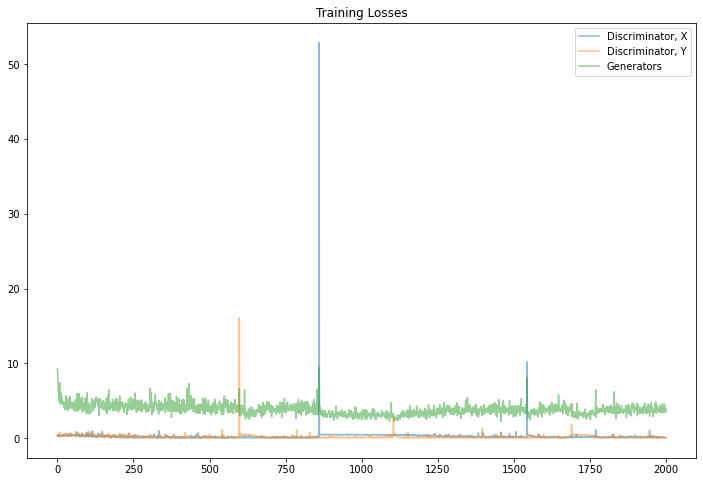

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [23]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


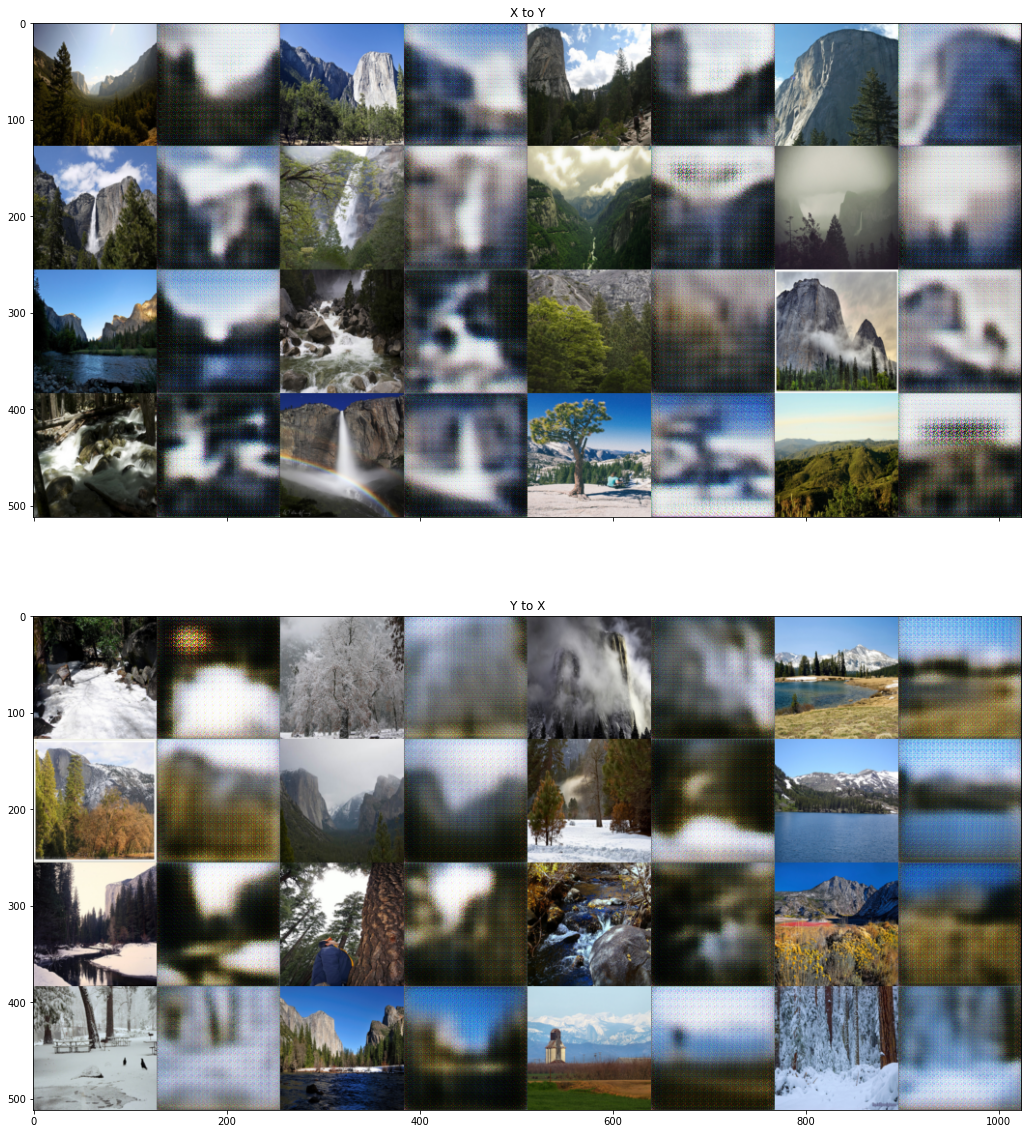

In [24]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

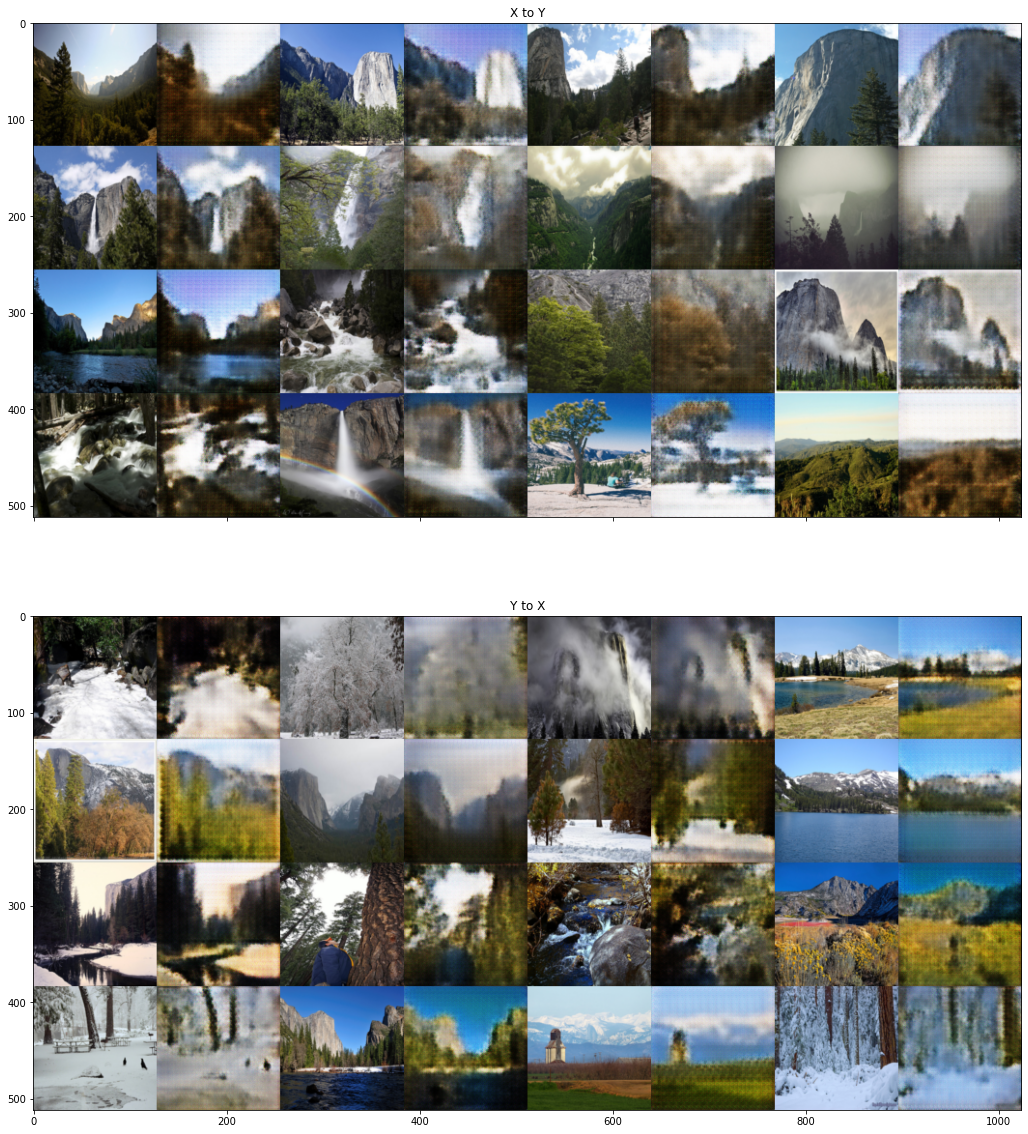

In [25]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.